In [1]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connecting, creating and loading the dataset in MongoDB
client = MongoClient("mongodb://mongo:27017/")
db = client['Retails']
transactions = db['transactions']

transactions.drop() # empty the collection to be able to test again with clean data or not clean data  

df = pd.read_csv("../datasets/OnlineRetail.csv") # it could be done directly form the xlsx file



In [3]:
# let's inspect some few entries
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [4]:
# let's see if there are columns with missing data
df.info() # there are missing descriptions and customer ids

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# let's see general statistics data
df.describe() # we can appreciate there are negative values for UnitPrice

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [6]:
# let's insepct some of those cases
df[df["UnitPrice"] < 0] # by reading the descrition, we can see now they were probably manually inserted to fix an error.

InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

<AxesSubplot:>

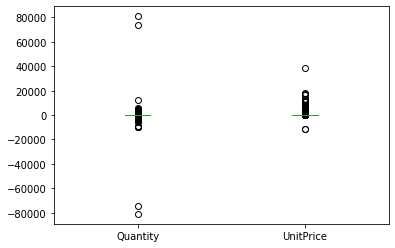

In [7]:
# let's visualize the distribution of quantity and unit price
# outliers shown as individual circles

df.boxplot(column=['Quantity', 'UnitPrice'], grid=False)

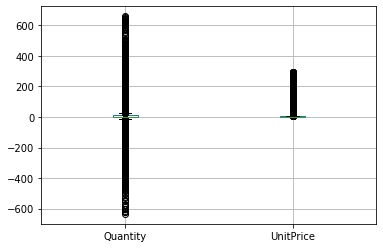

In [8]:
clean_flag = True #change it to True if you want to clean the data

if (clean_flag):
    # cleaning.
    # as a standard cleaning, we will remove entries that are more than 3 standard deviations away from the mean
    # https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
    from scipy import stats
    import numpy as np
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]
    df = df[(np.abs(stats.zscore(df['UnitPrice'])) < 3)]
    # let's visualize the distribution of quantity and unit price
    df.boxplot(column=['Quantity', 'UnitPrice'])
    # items with missing description will be assigned an empty string
    df["Description"] = df["Description"].fillna('')


In [9]:
if (clean_flag):
        # let's see the data again
        df.describe() # we see we have negative quantities but we accept them because we consider them as items being returned

In [10]:
# inserting the data to MongoDB
transactions.insert_many(df.to_dict('records'))
# Check the collections
db.list_collection_names()

['transactions']

In [11]:
# Grouping all transactions by invoice
transactions_per_invoice = db.transactions.aggregate([
    {"$group" : 
     {'_id':"$InvoiceNo",
     "StockCode": { "$addToSet": "$StockCode" },
     "Country": { "$addToSet": "$Country" }
     }}
])

In [12]:
# Showing the results
for transaction in transactions_per_invoice:
    print(" * InvoiceNo = {InvoiceNo}, StockCodes = {StockCode}, Countries = {Country}".format(
         InvoiceNo=transaction["_id"],
         StockCode=transaction["StockCode"],
         Country=transaction["Country"],
   ))

 * InvoiceNo = 543754, StockCodes = ['22697', '22692', '22846', '22878', '22872', '22870', '22084', '22423', '22698', '22193', '22877', '22873', '22871', '22869', '22191', '22839', '22875', '22876', '22868', '22499', '21922', '22874', '22699'], Countries = ['United Kingdom']
 * InvoiceNo = C550127, StockCodes = ['37446', '37449'], Countries = ['United Kingdom']
 * InvoiceNo = 558096, StockCodes = ['22654', '22442', '23245', '22776', '21974', '82482', '21391', '22906', '21648', '21609', '22665', '17012C', '22770', '22443', '22795', '20972', '20653', '21992', '20836', '21991', '22766', '17012F', '22606', '85039B', '22620', '21613', '23300', '23299', '21110', '84920', '21259', '22251', '22749', '22273', '21713', '21890', '22800', '20702', '21891', '21851', '21794', '21108', '20748', '21382', '21867', '20617', '84912B', '22464', '22667', '22768', '22907', '23301', '22604', '21714', '21993', '84913B', '23306', '22759', '23298', '21647', '72741', '22320', '22796', '21900', '23111', '22989', 

 * InvoiceNo = 574331, StockCodes = ['22383', '21498', '16161U', '22384', '23206', '20728', '23545', '21500', '23583', '22382', '22328', '22045', '21499', '23084', '21731'], Countries = ['United Kingdom']
 * InvoiceNo = 578322, StockCodes = ['23313', '21257', '22086', '23493', '22141', '22144', '21258', '22734', '22910', '23494'], Countries = ['United Kingdom']
 * InvoiceNo = 578808, StockCodes = ['85199S', '23215', '22151', '82580', '21257', '84970L', '84971S', '22467', '15044D', '23162', '21154', '84945', '15044C', '22457', '22818', '20767', '22139', '22042', '20971', '84832', '15044A', '82578', '82581', '21774', '22381', '21775', '22792', '23360', '23350', '23318', '85199L', '72351A', '22379', '23168', '21326', '21494', '22348', '84879', '21314', '23353', '21558', '47591D', '84821', '23349', '20972', '23152', '21559', '22816'], Countries = ['United Kingdom']
 * InvoiceNo = 557298, StockCodes = ['21094', '22333', '23306', '23099', '23307', '47566B', '21086', '47566'], Countries = ['U

 * InvoiceNo = 577784, StockCodes = ['84692', '21787', '21786', '21621', '21626', '22993', '84993A', '21212'], Countries = ['United Kingdom']
 * InvoiceNo = 538190, StockCodes = ['22469', '22470', '21034', '82482', '22694', '82494L', '85123A', '85066', '85061W', '22696'], Countries = ['United Kingdom']
 * InvoiceNo = 551573, StockCodes = ['22726'], Countries = ['United Kingdom']
 * InvoiceNo = 549711, StockCodes = ['22431', '20727', '15036', '20856', '84920', '22327', '22432', '21878', '21643', '23007', '20725', '22433', '21912', '22326', '21888', '23076', '23010', '22483', '21156', '21056', '22662', '21578', '22084', '23008'], Countries = ['United Kingdom']
 * InvoiceNo = 578688, StockCodes = ['22959', '22684', '22939', '22139', '22704', '20765', '85123A', '17003', '22679', '22632', '22686', '23332', '23079', '22179', '22199', '23471', '23472', '79321', '23322', '20829', '16169E', '37413', '82483', '84030E', '23323', '22726', '22865', '20769', '20828', '84360', '23232', '22727', '2149

 * InvoiceNo = C543761, StockCodes = ['22569'], Countries = ['United Kingdom']
 * InvoiceNo = 551013, StockCodes = ['22457', '22839', '22842', '22424', '22840', '22841', 'POST', '22314', '22843', '22722', '22312'], Countries = ['European Community']
 * InvoiceNo = 551578, StockCodes = ['90037D'], Countries = ['United Kingdom']
 * InvoiceNo = 569012, StockCodes = ['23507', '23508', '22553', '23320', '22979', '22966', '23350', '20974', '23176', '21915', '23466', '23368'], Countries = ['United Kingdom']
 * InvoiceNo = 572339, StockCodes = ['21733', '23319', '20685', '23351', '22086', '21288', '23284'], Countries = ['United Kingdom']
 * InvoiceNo = 551964, StockCodes = ['20851'], Countries = ['United Kingdom']
 * InvoiceNo = 572700, StockCodes = ['72818'], Countries = ['United Kingdom']
 * InvoiceNo = 580685, StockCodes = ['22923', '23209', '22866', '22867', '23445', '84029E', '23204', '23207', '23583', '22633', '23264', '23681', '21877', '22924', '22865', '48194'], Countries = ['United Ki

 * InvoiceNo = 536583, StockCodes = ['21156'], Countries = ['United Kingdom']
 * InvoiceNo = 552514, StockCodes = ['22989', '84970L', '22922', '22969', '85135C', '22666', '21531', '84212', '84536A', '84692', '21935', '22502', '37342', '84247G', '22412', '85203', '72586', '22399', '23284', '17129F', '20719', '84078A', '23162', '22698', '22917', '20761', 'DOT', '22900', '84946', '22907', '22914', '21933', '84849D', '22357', '22699', '82581', '84978', '84913B', '85087', '90085', '23298', '22748', '22928', '84913A', '22264', '17084N', '20685', '22360', '21070', '20733', '48188', '21626', '22921', '90083', '22386', '22953', '20652', '21508', '21931', '21367', '85169B', '21899', '23202', '15058A', '22359', '20717', '21705', '21272', '22692', '84997A', '21385', '21932', '22690', '84536B', '22055', '84997B', '21454', '21868', '22424', '21813', '22508', '21181', '21455', '22090', '20731', '21992', '85150', '21558', '23253', '84813', '22620', '84970S', '22244', '84912A', '22913', '22723', '23163

 * InvoiceNo = 551436, StockCodes = ['20725', '22969', '21929', '22840', '20711', '22376', '20726', '22671', '22673', '21755', '22675', '21936', '22674', '21874', '21876', '23208', '22171', '22843', '22672', '22499', '21872', '22374', '22382', '21930', '22842', '21868', '22381', '22375', '22372', '21937', '22652', '22384', '22371', '22841'], Countries = ['United Kingdom']
 * InvoiceNo = C557515, StockCodes = ['23322', '22470', '21429', '72802B'], Countries = ['United Kingdom']
 * InvoiceNo = 543359, StockCodes = ['15060B', '72741', '85014A', '22171', '72351B', '21733', '22639', '22173', '22794', '22781'], Countries = ['United Kingdom']
 * InvoiceNo = 576381, StockCodes = ['22197', '23191', '23078', '22187', '20972', '82494L', '22356', '84029E', '22661', '22699', '20723', '21232', '84978', '22045', '85099C', '22029', '22457', '23203', '84378', '22212', '82486', '22037', '20724', '84006', '21506', '16169E', '21481', '21212', '22355', '23240', '79321'], Countries = ['United Kingdom']
 * I

 * InvoiceNo = 566213, StockCodes = ['22139', '21181', '21166', '23407', '23378', '84077', '21232', '23110', '23411', '22424', '22689', '23316', '23319', '22726', '23380', '21889', '22630', '22572', '23012', '21314', '22980', '23291', '23287', '22274', '22910', '22646', '23236', '22940', '23288', '22745', '22151', '22729', '23014', '23247', '22273', '23545', '23169', '22961', '21340', '23234', '22971', '23013', '23318', '23285', '23310', '23021', '22990', '21731', '23345', '22747', '22645', '23275', '23111', '22812', '23297', '85048', '23112', '23359', '22748', '23231', '22086', '22943', '22988', '23085', '22746', '22725', '23209', '23198', '84375', '22969', '21791', '22271', '23289', '22077'], Countries = ['United Kingdom']
 * InvoiceNo = 567668, StockCodes = ['46776C', '23393', '23399', '21212', '21892', '22328', '23202', '21949', '21224', '21678', '21680', '22692', '21868', '22424', '21775', '22792', '22446', '85131B', '23204', '22107', '84032A', '79190A', '21232', '46776B', '20774'

 * InvoiceNo = C552706, StockCodes = ['21843', '37446'], Countries = ['United Kingdom']
 * InvoiceNo = 563440, StockCodes = ['22161', '79163', '16054', '35816P', '16048', '21088', '21084', '85212', '21642', '21096', '35818B', '35923', '23187', '21090', '21208', '16045', '72225C', '21179'], Countries = ['United Kingdom']
 * InvoiceNo = 547003, StockCodes = ['15044D', '15056BL', '85014B', '15056P', '20679', '15056N'], Countries = ['United Kingdom']
 * InvoiceNo = 541123, StockCodes = ['22500', '20846', '21754', '22623', '20749', '21755', '22139', '22276', '21713', '22399', '21136', '85184C', '21528', '21915', '21459', '84970L', '21508', '22817', '22260', '85187', '21507', '16161U', '20750', '22497', '22763', '21756', '22762', '21460', '22138', '84836', '22617', '22761', '21781', '22029', '22045'], Countries = ['United Kingdom']
 * InvoiceNo = 545928, StockCodes = ['71279', '22720', '21930', '22967', '23052', '22848', '20712', '22993', '21164', '22722', '22849', '21033', '21929', '21181',

 * InvoiceNo = 579473, StockCodes = ['23375', '23436', '21833', '22910', '22111', '22491', '21731', '22866', '22489', '23506', '84375', '23510', '20981', '23480', '23367', '20982', '20983', '84078A', '22475', '22959', '21479', '22086', '23351', '22083'], Countries = ['United Kingdom']
 * InvoiceNo = 566597, StockCodes = ['23204', '23243', '22730', '23205', '23240', '22699', '23192', '23173', '22624', '85099C', '23245', '23167', '22457', '22384', '71477', '22993', '22784', '23073', '22961'], Countries = ['United Kingdom']
 * InvoiceNo = 572348, StockCodes = ['72802B', '23071', '72802C', '23057', '23055', '23056', '23072'], Countries = ['United Kingdom']
 * InvoiceNo = 566590, StockCodes = ['23347', '22970', '84006', '22064', '84077', '22659', '22900', '21731', '22892', '23079', '22636', '21508', '21509', '21507', '22710', '21790', '22713', '22109', '23005'], Countries = ['United Kingdom']
 * InvoiceNo = 544693, StockCodes = ['22427', '22429', '22426', '22843', '22722', '22720'], Countri

 * InvoiceNo = 568135, StockCodes = ['22578', '23292', '23173', '20652', '20978', '22660', '21755', '23434', '82567', '23367', '85123A', '22439', '22076', '84596B', '23108', '35964', '84596F', '82583', '23084', '35915B', '79144C', '90165B', '90190C', '22378', '20676', '22599', '21992', '23291', '23365', '23640', '23188', '23510', '23319', '22701', '23435', '23317', '21175', '22077', '47593B', '84029G', '20719', '22299', '22340', '84946', '22820', '23424', '22163', '85087', '22982', '84568', '84032B', '20840', '22577', '85099B', '23205', '84006', '21242', '21528', '22815', '23169', '20726', '21116', '21744', '21218', '35953', '84347', '22961', '21108', '23632', '22904', '21739', '22452', '21003', '21166', '23629', '22653', '23423', '22580', '84947', '21098', '21314', '21238', '22728', '23300', '22197', '22814', '37450', '22161', '23096', '22139', '72816', '23201', '84378', '21811', '23275', '21731', '21328', '23290', '22712', '21843', '23200', '23393', '23118', '21934', '20668', '21064'

 * InvoiceNo = C556272, StockCodes = ['22766'], Countries = ['United Kingdom']
 * InvoiceNo = 556722, StockCodes = ['23240', '23309', '23235', '23239', '23237', '23244', '23245', '23092', '23236', '23188'], Countries = ['United Kingdom']
 * InvoiceNo = 573880, StockCodes = ['22812'], Countries = ['United Kingdom']
 * InvoiceNo = 579456, StockCodes = ['22398', '23281', '23452', '21773', '23416', '22494', '23353', '22496', '21034', '22576', '23503', '22677', '23275', '22163', '23318', '82581', '21774', '47421', '23284', '22804', '22212', '21947', '23493', '23209', '21592', '22670', '22624', '84843', '22277', '82582', '22585', '22984', '23287', '22181', '22419', '84380', '22326', '23354', '85034B', '85227', '21084', '22676', '23084', '22306', '22097', '21739', '85169A', '23428', '21383', '84792', '82578', '85178', '85015', '21775', '35471D', '82567', '84596B', '22203', '22626', '22467', '20914', '23282', '22495', '22551', '21733', '22093', '85123A', '21090', '82580', '22098'], Countries =

 * InvoiceNo = 553062, StockCodes = ['22896', '85099B', '85099C', '85099F'], Countries = ['United Kingdom']
 * InvoiceNo = 554358, StockCodes = ['22470', '21770'], Countries = ['United Kingdom']
 * InvoiceNo = 566396, StockCodes = ['23161', '23245', '22994', '23000', '21918', '23173', '23175', '22699', '23336', '23339', '22697', '22998', '22999', '23338', '23174', '22197', '22698', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = 577518, StockCodes = ['84832', '22697', '22699', '22429', '23301', '23013', '22113', '23110'], Countries = ['United Kingdom']
 * InvoiceNo = 538147, StockCodes = ['M'], Countries = ['United Kingdom']
 * InvoiceNo = 555331, StockCodes = ['84800L'], Countries = ['United Kingdom']
 * InvoiceNo = 553186, StockCodes = ['21272', '82583', '82551', '22670', '21166', '21181', '21870', '21874'], Countries = ['United Kingdom']
 * InvoiceNo = 556790, StockCodes = ['22842', '84832', '21136', '22354', '23167', '22841', '23165', '23020', '23240', '23245', '22776', '23

 * InvoiceNo = 556471, StockCodes = ['23268', '22602', '85199S', '21591', '85152', '21174', '22628', '23298', '23091', '85123A', '23269', '23226'], Countries = ['United Kingdom']
 * InvoiceNo = C559498, StockCodes = ['21931', '23245'], Countries = ['United Kingdom']
 * InvoiceNo = 566224, StockCodes = ['21928', '84968A'], Countries = ['United Kingdom']
 * InvoiceNo = 559980, StockCodes = ['21832', '22437', '15056BL', '23310', '15056N', '20679', '22436', '15056P'], Countries = ['United Kingdom']
 * InvoiceNo = 567188, StockCodes = ['15056N'], Countries = ['Cyprus']
 * InvoiceNo = 547491, StockCodes = ['84836', '22178', '22077', '22335', '22595', '22784', '72051S', '22822', '85123A'], Countries = ['United Kingdom']
 * InvoiceNo = 571412, StockCodes = ['23394', '35970', '22734', '23354', '23427', '46000S', '22816', '23434', '23395', '23393'], Countries = ['United Kingdom']
 * InvoiceNo = 572108, StockCodes = ['23471', '84347', '23274', '23459', '23284', '82582', '23101', '23414', '23145',

 * InvoiceNo = 567213, StockCodes = ['22633', '22469', '20726', '22439', '85123A', '20974', '20982', '20981', '20983', '22383', '22141', '23302', '23332', '22694', '20725', '20984', '72131', '22639', '22355', '21820', '21818', '23330', '20727', '72128', '23206', '22865', '72130', '23329', '72133', '22952', '72132', '22142', '22866', '22867', '23439', '22834', '21787', '23333', '21789', '72134', '23208'], Countries = ['United Kingdom']
 * InvoiceNo = C572117, StockCodes = ['23395'], Countries = ['United Kingdom']
 * InvoiceNo = 563832, StockCodes = ['21034', '47566', '84879', '23024', '84947'], Countries = ['United Kingdom']
 * InvoiceNo = 551322, StockCodes = ['85099F'], Countries = ['United Kingdom']
 * InvoiceNo = C539565, StockCodes = ['22649', '84406B'], Countries = ['United Kingdom']
 * InvoiceNo = 554547, StockCodes = ['23190', '23084', '23166', '23165'], Countries = ['United Kingdom']
 * InvoiceNo = C558716, StockCodes = ['51014L', '21829', '22374', '22998', '22997', '22992', '2

 * InvoiceNo = 580695, StockCodes = ['22942', '23350', '22139', '22974', '22575', '21668', '22972', '23351', '22703', '22173', '15044A', '22301', '17003', '82484', '22423', '23296', '23322', '22757', '20971', '23295', '22211', '22909', '15044C', '21730', '23321', '22701', '21446', '22988', '22072', '22465', '23330', '84536A', '23581', '22755', '23498', '35004G', '84509G', '21034', '23263', '23323', '23266', '22645', '22509', '22075', '22464', '22487', '22500', '22144', '22208', '22210', '22977', '23552', '21264', '22971', '48187', '21993', '23344', '22975', '22749', '23031', '23343', '15044D', '22467', '21733', '85123A', '23313', '22076', '22196', '71477', '22215', '84945', '84536B', '23035', '22753', '22754', '23352', '23332', '84819', '22141', '21810', '22756', '22940', '22910', '23334', '22430', '22758', '20972', '21109', '23264', '21263', '22644', '23005', '23331', '22721', '23570', '23265', '23349', '22349', '22350', '23143', '84535B', '23084', '22732', '22209', '22142', '22970', 

 * InvoiceNo = C544432, StockCodes = ['22487'], Countries = ['United Kingdom']
 * InvoiceNo = 571443, StockCodes = ['22816', '23273', '23274', '22694', '22142', '22141', '22940', '22938', '22470', '22144', '22941', '22158', '21591'], Countries = ['United Kingdom']
 * InvoiceNo = 577807, StockCodes = ['22175', '82486', '23459', '84509A', '84987', '23393', '22089', '23406', '82483', '21108', '47585A', '47580', '23405', '22151', '22776', '21974', '82484', '84616'], Countries = ['United Kingdom']
 * InvoiceNo = 542407, StockCodes = ['21673', '48173C', '21668', '48184', '21069', '22983', '21068', '22714', '21523', '21355', '22814', '21508', '21524', '22805', '22245', '22026', '21071', '21520', '82494L'], Countries = ['United Kingdom']
 * InvoiceNo = 546166, StockCodes = ['22219', '84879', '72351A'], Countries = ['United Kingdom']
 * InvoiceNo = 548534, StockCodes = ['22525', '84077', '22519', '22517', '22179', '22516', '22147', '22750', '22752', '22271', '20971', '22556', '21790', '22518', 

 * InvoiceNo = 541672, StockCodes = ['22726', '22728', '22730', '22727', '22729'], Countries = ['United Kingdom']
 * InvoiceNo = 548380, StockCodes = ['22127'], Countries = ['United Kingdom']
 * InvoiceNo = 543587, StockCodes = ['21498', '22326', '22704', '85232A', '48184', '21906', '22692', '21500', '22212', '22173', '22631', '21080', '21035', '22907', '22989', '21499'], Countries = ['Germany']
 * InvoiceNo = 554131, StockCodes = ['21078', '23107', '22508', '82484', '79030G', '84879', '22487', '84946', '82482', '22335', '22824', '85066', '21232', '23088', '23300', '84596J', '22297', '37479B', '23093', '20931', '22430', '22302', '84755', '20749', '23091', '22919', '23099', '85123A', '21340', '21136', '22224'], Countries = ['United Kingdom']
 * InvoiceNo = 580512, StockCodes = ['20724', '22554', '23473', '85099B', '23583', '23582', '23475', '23493', '21389', '22138', '22555', '21452', '23480', '20712', 'POST', '21114', '20750', '23344', '22139'], Countries = ['Germany']
 * InvoiceNo = 5

 * InvoiceNo = 544650, StockCodes = ['22458', '22605', '22489', '21903', '22477', '21174', '22607', '22371', '22606'], Countries = ['United Kingdom']
 * InvoiceNo = 558752, StockCodes = ['21163', '84971S', '21901', '22336', '23302', '23132', '22251', '21135', '23202', '23146', '22139', '22556', '22178', '23301', '21932', '22268', '21794', '85123A', '23140', '20713', '23208', '23138', '23148', '21933', '22464', '22381', '22219', '23065', '23152', '23206', '22296', '22297', '23199', '23147', '23200', '85066', '22384', '23131', '23300'], Countries = ['United Kingdom']
 * InvoiceNo = C566965, StockCodes = ['21259'], Countries = ['United Kingdom']
 * InvoiceNo = 566954, StockCodes = ['23325'], Countries = ['United Kingdom']
 * InvoiceNo = 578340, StockCodes = ['22568'], Countries = ['United Kingdom']
 * InvoiceNo = 553733, StockCodes = ['71459', '23164', '23206', '15044A', '15044B'], Countries = ['United Kingdom']
 * InvoiceNo = C559031, StockCodes = ['82580'], Countries = ['United Kingdom'

 * InvoiceNo = 574874, StockCodes = ['C2', '22594', '23534', '23541', '20712', '23532', '23314', '23199', '23536', '22578', '22593', '21929'], Countries = ['EIRE']
 * InvoiceNo = C574957, StockCodes = ['23084'], Countries = ['United Kingdom']
 * InvoiceNo = 542901, StockCodes = ['21217', '22180', '21781', '22171', '22427', '84792'], Countries = ['United Kingdom']
 * InvoiceNo = 551250, StockCodes = ['22487', '22994', '21930', '82581', '47566B', '22788', '22352', '21977', '21215', '22041', '21770', '22982', '20668', '22384', '21198', '22682', '21929', '22666', '22896', '22465', '21935', '20724', '22807', '84378', '22383', '22457', '21882', '21672', '22664', '22719', '22676', '21927', '21199', '21041', '23207', '22090', '23206', '22775', '21975', '22995', '47599B', '22681', '79302M', '82580', '84992', '72800E', '21925', '21931', '47590B', '22355', '15058B', '22087', '21926', '85054', '21640', '22485', '20726', '22773', '22753', '47422'], Countries = ['United Kingdom']
 * InvoiceNo = 5526

 * InvoiceNo = 547618, StockCodes = ['21547'], Countries = ['United Kingdom']
 * InvoiceNo = 563202, StockCodes = ['85066', '22797'], Countries = ['France']
 * InvoiceNo = 553858, StockCodes = ['84692', '22384', '22662', '23298', '22493', '21830', '22173', '47590B', '84792', '47566', '47590A', '22721', '22090'], Countries = ['United Kingdom']
 * InvoiceNo = 548942, StockCodes = ['84947', '22178', '84946'], Countries = ['United Kingdom']
 * InvoiceNo = 561881, StockCodes = ['23206', '22386', '20728', '20726', '20972', '22273', '20712', '22149', '22150', '22383', '21936', '20725', '22384', '85099F', '21929', '22621', '21928', '82482', '23209', '47566', '85099B', '22745', '82494L', '22382'], Countries = ['United Kingdom']
 * InvoiceNo = 536970, StockCodes = ['22423'], Countries = ['United Kingdom']
 * InvoiceNo = 543973, StockCodes = ['22261', '21135', '22156', '22668', '22087', '84800S', '85062', '21818', '84800L', '22260', '84970S', '85227', '20668', '22789', '21695', '22776', '84946', 

 * InvoiceNo = 544166, StockCodes = ['48173C', '22692', '22690', '22366'], Countries = ['United Kingdom']
 * InvoiceNo = 552696, StockCodes = ['22847', '22605', '21136', '15056BL', '15036', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = 564366, StockCodes = ['82486', '22430', '22469', '84879', '21535', '47566', '22427', '23020', '84946', '82482', '22470', '23094', '84945', '48184', '23253', '23112', '23093', '21533', '23169', '22294', '23298'], Countries = ['United Kingdom']
 * InvoiceNo = C536383, StockCodes = ['35004C'], Countries = ['United Kingdom']
 * InvoiceNo = C577131, StockCodes = ['22827'], Countries = ['United Kingdom']
 * InvoiceNo = 540185, StockCodes = ['22052', '84970L', '22156', '21726', '22554', '21724', '22469', '21755', '22704', '22555', '85123A', '22693', '21985', '48194', '22193', '21361', '22470', '16156S', '22627', '22428', '21725', '22361', '22766', '21500', '21719', '16169M', '22759', '16161P', '22796'], Countries = ['United Kingdom']
 * InvoiceNo = 54

 * InvoiceNo = 537469, StockCodes = ['22112'], Countries = ['United Kingdom']
 * InvoiceNo = 552008, StockCodes = ['POST', '22847', '22849'], Countries = ['Germany']
 * InvoiceNo = 542127, StockCodes = ['85066'], Countries = ['United Kingdom']
 * InvoiceNo = 536616, StockCodes = ['21137'], Countries = ['United Kingdom']
 * InvoiceNo = 575367, StockCodes = ['22600', '22736', '22603', '22602', '23434', '22579', '22594', '22940', '23435', '22734', '22577', '22065', '22141', '22909', '22578', '22574', '35967', '23266', '22307', '23382', '22573', '23265', '22595', '23264', '22581', '85199S', '22738', '22593', '22737', '22601', '22142', '22144', '22576', '22306', '22952'], Countries = ['United Kingdom']
 * InvoiceNo = 575581, StockCodes = ['POST', '22944', '85015', '23395', '23396'], Countries = ['France']
 * InvoiceNo = 541267, StockCodes = ['84917', '22782', '84915', '20803', '22646', '22178', '20801', '22961', '22063', '22783', '22626', '22845', '82613D', '22624', '22722', '22969', '21110

 * InvoiceNo = 572907, StockCodes = ['23243', '22720', '23096', '22989', '22722', '22138', '22907', '84978', '23353', '47559B', '23349', '47591D', '22818', '23403', '22139'], Countries = ['United Kingdom']
 * InvoiceNo = 544353, StockCodes = ['35004B', '22848', '22845', '22727', '22844'], Countries = ['United Kingdom']
 * InvoiceNo = 546828, StockCodes = ['22502'], Countries = ['United Kingdom']
 * InvoiceNo = 539636, StockCodes = ['22847', '22445', '21680', '22652', 'POST', '22849', '22624', '22627', '22962', '22863', '22961', '22963'], Countries = ['Germany']
 * InvoiceNo = 546876, StockCodes = ['22713', '23230'], Countries = ['United Kingdom']
 * InvoiceNo = 548650, StockCodes = ['21977', '22832', '82494L', '21181', '22673', '22767', '82482', '84946', '22741', '22969', '84949', '22672', '84992', '22413', '85123A', '22675', '20914', '22674', '84947', '22557', '21770', '22740', '21175', '22178'], Countries = ['United Kingdom']
 * InvoiceNo = 552299, StockCodes = ['22964', '22843', '22

 * InvoiceNo = C539944, StockCodes = ['22776'], Countries = ['United Kingdom']
 * InvoiceNo = 545853, StockCodes = ['22188', '22189', '84763', '85123A', '21713', '85174', '22863', '22443', '22285', '22855', '22430', '82494L', '84970L', '84950', '22789', '82482', '21896'], Countries = ['United Kingdom']
 * InvoiceNo = 566975, StockCodes = ['22385', '23344', '84879', '22382', '22910', '85099B', '22992', '23318', '23107', '23330', '21930', '21498', '22663', '22818', '22457', '23203', '23353', '22959', '21500', '23343', '22816', '20727'], Countries = ['United Kingdom']
 * InvoiceNo = 559510, StockCodes = ['22699', '23171', '20723', '23174', '23309', '22178', '23164', '84988', '23162', '23173', '23209', '23299', '84949', '20725', '22962', '23170', '22911', '23205', '23298', '20727', '21559', '22197', '23163', '23172', '21558', '22963', '23208', '21974', '23161', '22356', '22460', '23207', '47566', '23175'], Countries = ['United Kingdom']
 * InvoiceNo = 536384, StockCodes = ['22224', '22427'

 * InvoiceNo = 539107, StockCodes = ['22971', '22960', '21915'], Countries = ['United Kingdom']
 * InvoiceNo = 568795, StockCodes = ['23042', '23041', '22371', '23296', '47590A', '21509', '23294', '23040', '84991', '21213', '23293', '23309', '21742', '22090', '22488', '22185', '23108', '84978', '23086', '21122'], Countries = ['United Kingdom']
 * InvoiceNo = 575972, StockCodes = ['20728', '47578A', '23307', '22579', '23215', '22596', '23321', '22338', '22960', '22896', '23583', '23493', '23209', '22694', '21263', '21811', '22600', '23220', '23159', '22602', '22422', '22603', '23154', '22329', '23224', '21469', '22576', '21731', '22867', '21584', '22411', '23263', '23266', '23323', '23329', '21561', '22384', '23100', '22557', '23144', '22086', '22581', '23157', '22554', '85049E', '22910', '23334', '22328', '23223', '23035', '23332', '22562', '23469', '23089', '22131', '23274', '85123A', '22555', '22632', '22993', '21329', '23301', '21744', '22810', '23343', '23221', '23225', '21819', '2

 * InvoiceNo = 564335, StockCodes = ['21172', '23301', '21626', '22500', '22867', '22917', '22834', '22217', '21754', '21755', '84836', '22916', '22720', '23344', '20723', '21179', '23200', '23343', '23313', '23184', '23298', '22614', '23318', '22920', '22921', '21900', '22115', '22413', '16014', '48188', '16015', '21034', '22179', '23079', '22216', '21164', '79321', '22616', '22479', '16016', '21624', '22111', '22918', '21220', '84884A', '22478', '22701', '21586', '22852', '23243', '22804', '22909', '22592', '23146', '21982', '21985', '47504K', '22941', '85053', '22092', '22096', '20719', '23355', '35970', '23108', '22511', '22113', '21967', '23439', '22097', '22091', '22722', '20713', '23204', '22633', '22356', '23199', '22661', '48129', '82582', '21981', '21986', '22349', '21980', '22945', '23202', '21481', '22700', '20711', '23205', '21621', '22355', '21625', '22673', '22477', '23182', '85231B', '85123A', '84459A', '22919', '82600', '22632', '21733'], Countries = ['United Kingdom']

 * InvoiceNo = 570230, StockCodes = ['22093', '21258', '21928', '23295', '21929', '22098', '23036', '21621', '21819', '22583', '22082', '72140E', '85231B', '23294', '22092', '23296', '21326', '21894', '21695', '84836', '22339', '85169A', '21331', '22091', '22906', '22720', '21124', '21693', '21992', '85104', '85039B', '22411', '22197', '71459', '21684'], Countries = ['United Kingdom']
 * InvoiceNo = 576624, StockCodes = ['23119', '23286', '23157', '22910', '23288', '23285', '23355', '23449', '21209', '84596B', '23598', '23442', '23356', '23287', '22086'], Countries = ['United Kingdom']
 * InvoiceNo = 553879, StockCodes = ['23066', '47566', '84077', '22170', '21790', '84988', '22139', '21936', '71477', '23057', '21703', '21915', '21891', '23203', '21531', '22898', '22621', '20725', '20717', '22799', '21892', '21535', '21080', '22896', '85099B', '21937', '22908', '23199', '22652', '20727', '21155', '21843', '23298', '23163', '23055', '23206', '22796', '22411', '22149', '23177', '85066', 

 * InvoiceNo = 542648, StockCodes = ['82484', '21484', '21135', '22328', '22720', '22427', '84879', '22624', '22627', '22849', '84279P', '22423', '20752', '22467', '21137', 'POST', '21116', '22847', '22605', '84832', '22077'], Countries = ['Germany']
 * InvoiceNo = 561368, StockCodes = ['POST'], Countries = ['United Kingdom']
 * InvoiceNo = 542005, StockCodes = ['85099B', '21498', '21246', '21936', '20725', '85014B', '85099F', '85099C', '22386', '20676', '22740'], Countries = ['United Kingdom']
 * InvoiceNo = C551683, StockCodes = ['22362'], Countries = ['United Kingdom']
 * InvoiceNo = 571510, StockCodes = ['22952', '22077', '22732', '22180', '22734', '23318'], Countries = ['United Kingdom']
 * InvoiceNo = 577056, StockCodes = ['90133', '90160D', '90161B', '90129F', '84946', '90198B', '17021', '90129B', '23323', '21631', '21633', '90120C', '90158', '90198A', '22118', '90160C', '90161C', '90120B', '90157', '21755'], Countries = ['United Kingdom']
 * InvoiceNo = 556330, StockCodes = ['2

 * InvoiceNo = 560426, StockCodes = ['20727', '20728', '23206', '20726', '23201', '20914', '22662', '23203', '82600', '22384', '22383', '85099C', '20725', '85152', '23208', '23209', '21931', '22382', '23202', '23207'], Countries = ['United Kingdom']
 * InvoiceNo = 569920, StockCodes = ['22619', '22460', '23145', '22601', '22892', '22621', '22617', '22138', '85231B', '20914', '22602', '23144', '22603', '22139'], Countries = ['United Kingdom']
 * InvoiceNo = 575387, StockCodes = ['20979', '20724', '20978', '20719', '22621'], Countries = ['United Kingdom']
 * InvoiceNo = 566050, StockCodes = ['84879', '22941', '22778', '21264', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = 547401, StockCodes = ['21174', '84804A', '23050', '22487', '22989', '22570', '85078', '22907', '22855', '22568', '22148', '22890', '22722', '22251', '22771', '22967', '22084', '22569', '21043', '22773', '85230B', '22957', '84800L', '22150', '22077', '22851', '21078'], Countries = ['United Kingdom']
 * InvoiceN

 * InvoiceNo = 574272, StockCodes = ['23431', '22086'], Countries = ['United Kingdom']
 * InvoiceNo = 551302, StockCodes = ['48189'], Countries = ['United Kingdom']
 * InvoiceNo = 578707, StockCodes = ['84596B', '20975', '21411', '84510C', '21584', '84859B', '84527', '23320', '22737', '85032A', '22352', '23338', '21205', '21034', '23694', '85035C', '23501', '22969', '23504', '84510A', '21531', '23339', '21373', '20780', '84859C', '22083', '84859A', '20992', '21985', '21129', '21115', '21739', '16218', '22906', '23350', '84509A', '21559', '23375', '22816', '21914', '22372', '22595', '22766', '85066', '22781', '90099', '21238', '23442', '79066K', '22578', '23458', '20781', '84509C', '20978', '22588', '21429', '90098', '85034C', '23114', '23229', '21912', '23369'], Countries = ['United Kingdom']
 * InvoiceNo = 555515, StockCodes = ['22846', '22847', '21871', '22728', '22191', '22907', '22727', '23168', '22627', '21781', '84879', '22195', '22252', '23108', '22730', '22192', '21868', '22424

 * InvoiceNo = C577737, StockCodes = ['23084', '23042', '84978', '84949', '20979', '22597', '22910', '22734', '23393', '22863', '23221', '23225', '22599', '23022'], Countries = ['United Kingdom']
 * InvoiceNo = 553744, StockCodes = ['85141'], Countries = ['United Kingdom']
 * InvoiceNo = C561229, StockCodes = ['22796', '22784'], Countries = ['United Kingdom']
 * InvoiceNo = 542391, StockCodes = ['84455'], Countries = ['United Kingdom']
 * InvoiceNo = 561534, StockCodes = ['23020', '84970L', '21122', '22434', '22488', '22814', '22436', '21136', '22178', '21504', '22139', '22037', '22457', '85123A', '22439', '23162', '21754', '23550', '23184', '82482', '23007', '23310', '22617', '21121', '21833', '82494L', '23120', '84879', '21124', '84077', '22138', '23122', '23190', '22029', '23338', '23297', '23549'], Countries = ['United Kingdom']
 * InvoiceNo = 580758, StockCodes = ['23575', '23578'], Countries = ['United Kingdom']
 * InvoiceNo = C539253, StockCodes = ['22423'], Countries = ['United

 * InvoiceNo = 555876, StockCodes = ['21391', '22608', '47566', '51014A', '84596B', '21634', '84596F', '21933', '84596G', '22715', '85032A', '16045', '85015', '22161', '21212'], Countries = ['United Kingdom']
 * InvoiceNo = 564159, StockCodes = ['22629', '20726', '22630', '22384', '22382'], Countries = ['France']
 * InvoiceNo = 575691, StockCodes = ['22139', '21216', '22072', '82484', '23181', '23399', '23104', '22846', '22847'], Countries = ['United Kingdom']
 * InvoiceNo = 566492, StockCodes = ['POST', '21232'], Countries = ['France']
 * InvoiceNo = 577411, StockCodes = ['23506', '22629', '23509', '21787', '21791', '84077', '22533', '22382', '23207', '22529', '23316', '22380', '21481', '85184C', '23315', '22554', '23169', '22613', '20726', '21790', '23392', '22851', '23367', '22551', '21121', '22627', '22112', '21124', '72741', '21789', '47310M', '84030E', '23681', '23382', '84828', '21123', '22624', '23371', '23368', '23583', '22659', '22631', '21788', '21704', '21745', '22534', '23

 * InvoiceNo = 555011, StockCodes = ['21188', '22927', '21658', '22928'], Countries = ['United Kingdom']
 * InvoiceNo = C569682, StockCodes = ['23397', '84968C', '23239', '11001'], Countries = ['United Kingdom']
 * InvoiceNo = 541214, StockCodes = ['21485', '70006', '84906', '35004C', '21755', '21429', '21754', '22693', '21534', '22457', '22433', '85184C', '22111', '21877', '21756', '21114', '22435', '37370', '22483', '21845', '84828', '22728', '22487', '22113', '21313', '22776', '22192', '85087', '22431', '22926'], Countries = ['United Kingdom']
 * InvoiceNo = 578010, StockCodes = ['85099B'], Countries = ['United Kingdom']
 * InvoiceNo = 550786, StockCodes = ['21718'], Countries = ['United Kingdom']
 * InvoiceNo = 572294, StockCodes = ['20727', '84030E', '22567', '23377', '23306', '21155', '23078', '22557', '22899', '22333', '21156', '22662', '22384', '22978', '21411', '22907', '22112', '22951', '23184', '20754', '21211', '22990', '22523', '22381', '21918', '20685', '84987', '21789', 

 * InvoiceNo = 543534, StockCodes = ['82482', '21975', '85099B', '21976', '22151', '85099C', '21977', '21914', '21915', '22276', '84836', '82494L', '21212'], Countries = ['United Kingdom']
 * InvoiceNo = 548222, StockCodes = ['22900', '22616', '22659'], Countries = ['United Kingdom']
 * InvoiceNo = 544475, StockCodes = ['21137'], Countries = ['United Kingdom']
 * InvoiceNo = 568894, StockCodes = ['22045', '21497', '85099F', '23193', '21731', '82552', '22500', '23345', '23396', '23367', '22762', '82581', '23013', '22712', '23298', '20750', '22385', '22086', '22782', '23346', '23377', '21984', '22662', '22496', '22614', '21164', '21389', '21929', '82551', '23240', '23368', '23280', '22992', '21983', '23092', '22139', '22829', '21136', '22602', '23203', '22227', '22710', '22457', '23108', '22629', '21115', '22029', '22090', '84879', '22466', '23206', '23176', '23395', '21981', '21194', '22708', '21818', '23177', '85066', '22630', '23394', '23380', '21509', '23012', '23014', '22050', '2215

 * InvoiceNo = 578683, StockCodes = ['20975', '35970', '20764', '85123A', '71477'], Countries = ['United Kingdom']
 * InvoiceNo = 569886, StockCodes = ['90191'], Countries = ['United Kingdom']
 * InvoiceNo = C564492, StockCodes = ['S'], Countries = ['United Kingdom']
 * InvoiceNo = C564907, StockCodes = ['21429', '85066', '23296', '22720', '22180', '23168', '22804'], Countries = ['United Kingdom']
 * InvoiceNo = 572929, StockCodes = ['23032', '23031'], Countries = ['United Kingdom']
 * InvoiceNo = 557469, StockCodes = ['21114', '21363', '22293', '22766', '35961', '22796', '23147', '23148', '22335', '82482', '23245', '82494L', '22252', '47566', '84818', '21391', '21136', '22167', '47343A', '21385', '22212', '35648', '23146', '21364', '21340', '84459A', '22227', '21621', '22336', '22291', '22292', '21135'], Countries = ['United Kingdom']
 * InvoiceNo = 552802, StockCodes = ['21216', '22197', '71459', '22565', '22789', '22989', '22666', '22993', '22077', '22768', '22961', '21533', '20972'

 * InvoiceNo = 542603, StockCodes = ['23231', '22859', '84879', '22856', '22960', '22858', '85123A', '22423', '21670', '22860', '21669', '22957', '21673', '22986'], Countries = ['United Kingdom']
 * InvoiceNo = 554021, StockCodes = ['20886'], Countries = ['United Kingdom']
 * InvoiceNo = 556820, StockCodes = ['22435', '15056BL', '23306', '21559', '22352', '20750', '15056N', '21558', '23203', '21746', '23209', '23238', '23240', '23245', '22976', '23237', '22432'], Countries = ['France']
 * InvoiceNo = 539484, StockCodes = ['21481', '22557', '37449', '21479', '22738', '22931', '21877', '22943', '22411', '84380', '22930', '22461', '21034', '22630', '21098', '21657', '22952', '22956', '21975', '22636', '22951', '21524', '22107', '22629', '22508', '22834', '22971', '22424', '22937', '22977', '22961', '22972', '84988', '22109', '22941', '22417', '22975', '85123A', '21623', '22736', '22973', '22199', '22690', '84378', '22180', '84992', '22416', '22809', '21929', '22310', '84375', '85049E', '2

 * InvoiceNo = 581472, StockCodes = ['23298', '23170', '21181', '82494L', '23171', '22699', '22697', '82482', '22627', '22624', '22423', '22698', '85123A', '22784', '23172', '82600', '22795'], Countries = ['United Kingdom']
 * InvoiceNo = 550001, StockCodes = ['84792', '23206', '22139', '84406B', '85123A', '22088', '21084', '20914', '22741', '22801', '22767', '22499', '21090', '22090', '22089', '47566'], Countries = ['United Kingdom']
 * InvoiceNo = C556677, StockCodes = ['23169'], Countries = ['United Kingdom']
 * InvoiceNo = 543371, StockCodes = ['21181', '22374', '85194L', '21868', '21158', '21232', '16011', '85152', '22241', '22499', '85039B', '22371', '21904', '85036C', '21889', '22375', '85150', '35815P', '20659', '20762', '20931', '85040B', '22027', '21705', '21864', '20932', '21679', '22550', '21163', '21912', '85123A', '72802C', '21867', '20765', '82600', '84218', '22904', '21680', '21385', '82567', '20622', '20655', '22469', '21755', '20764', '20669', '22464', '21162', '22249

 * InvoiceNo = 557226, StockCodes = ['23203', '23119', '15036', '23298', '21533', '21621', '84212', '47566', '23308', '21539', '23204', '23202', '22667', '23307', '85099F', '23121'], Countries = ['United Kingdom']
 * InvoiceNo = 539009, StockCodes = ['22358', '82494L', '21470', '90060D', '22425', '84849D', '22776', '22801', '22627', '90042A', '82583', '79329', '84751B', '21658', '90136', '90035A', '90133', '90178A', '21463', '90179A', '84949', '22624', '22625', '85146', '22032', '79067', '90060B', '22423', '82600', '21464', '22429', '21534', '22222', '22033', '22173'], Countries = ['United Kingdom']
 * InvoiceNo = 557251, StockCodes = ['22983', '21062', '21498', '21504', '22037', '22333', '21059', '22436', '21506', '21497', '22331', '22814', '21063', '21495', '22985'], Countries = ['United Kingdom']
 * InvoiceNo = 561892, StockCodes = ['23166', '23154', '23009', '82486', '22297', '23010', '23167', '22752', '20717'], Countries = ['United Kingdom']
 * InvoiceNo = 562708, StockCodes = ['8

 * InvoiceNo = 557742, StockCodes = ['84944', '23250', 'C2', '23169', '23249', '23165', '21084', '22561', '23167', '84970S', '21658', '21090', '23166', '23252', '23168', '84978', '18097C', '23251', '22443'], Countries = ['EIRE']
 * InvoiceNo = 552968, StockCodes = ['21755', '23052', '23054', '23051', '23053', '21754', '23050', '23049', '21136'], Countries = ['United Kingdom']
 * InvoiceNo = 578719, StockCodes = ['21821', '23218', '22047', '21136', '21678', '22082', '22811', '23220', '22955', '23356', '23489', '23238', '22909', '21576', '22910', '21990', '23520', '22908', '21619', '22992', '22911', '85040A', '21693', '22659', '22816', '21981', '23349', '23214', '23355', '23310', '23084', '23192', '21731', '23207', '84879', '22906', '22024', '23318'], Countries = ['United Kingdom']
 * InvoiceNo = 575951, StockCodes = ['22196', '21703', '21892', '21704', '21212', '22560', '22993', '22568', '22561'], Countries = ['United Kingdom']
 * InvoiceNo = 556730, StockCodes = ['21564'], Countries = 

 * InvoiceNo = 546145, StockCodes = ['21537'], Countries = ['United Kingdom']
 * InvoiceNo = C555252, StockCodes = ['23110', '22794'], Countries = ['United Kingdom']
 * InvoiceNo = 560117, StockCodes = ['21479', '72741', '85152', '47504K', '22902', '21875', '21175', '84029G'], Countries = ['United Kingdom']
 * InvoiceNo = 548604, StockCodes = ['21899', '22274', '84692', '47566', '22318', '21901', '22722', '22844', '21900', '20749', '22781', '21902', '22273', '22453', '22811'], Countries = ['United Kingdom']
 * InvoiceNo = 555523, StockCodes = ['22432', '22961', '22492', '22077', '23255', '22082', '23298', '23254', '22326', '22352', '22436', '22968', '20682', 'POST', '22898', '22179', '22742', '85185B', '22331', '22431', '85049G', '23204', '85049E', '23256', '22327', '22328'], Countries = ['Germany']
 * InvoiceNo = C554793, StockCodes = ['84077'], Countries = ['United Kingdom']
 * InvoiceNo = 567968, StockCodes = ['23275', '22750', '20977', 'POST', '21329', '22150', '20969', '22563', '2

 * InvoiceNo = 553706, StockCodes = ['23170', '23084', '22778', '23172', '23171'], Countries = ['United Kingdom']
 * InvoiceNo = 543264, StockCodes = ['21239', '22469', '22595', '20675', '20676', '22380', '21244', '21238', '22457', '21156', '21240', '21902', '21900', '82600', '20677', '21901', '21243', '21245', '22379', '21211', '20674', '21899', '22381', '21242'], Countries = ['United Kingdom']
 * InvoiceNo = 542351, StockCodes = ['84520B', '22776', '21080', '22220'], Countries = ['United Kingdom']
 * InvoiceNo = 553882, StockCodes = ['22727', '22729', '22629'], Countries = ['United Kingdom']
 * InvoiceNo = 565430, StockCodes = ['16169K', '22507', '22637', '16258A', '22727', '84806B', '15039', '22187', '21908', '22372', '22375', '21917', '20774', '23232', '22371', '22099', '22620', '22729', '23252', '22624', '22302', '22303', '22093', '22893', '22035', '22908', '23233', '16169E', '22725', '21899', '21892', '23547', '22941', '22673', '22174', '84806A', '21715', '21890', '22704', '21452

 * InvoiceNo = 560845, StockCodes = ['23284', '10133', '22610', '16054', '23169', '47504K', '71459', '20712', '22784', '20914', '23191', '84755', '22843', '21523', '22624', '20685', '22430', '84879', '22425', '22925', '20772'], Countries = ['United Kingdom']
 * InvoiceNo = 565468, StockCodes = ['22470', '23041', '23040'], Countries = ['United Kingdom']
 * InvoiceNo = 567148, StockCodes = ['23168', '82482', '23314', '22938', '22952', '85152', '22950', '21181', '22720', '23200', '22386', '22411', '22180', '21258', '21928', '23295', '22909', '82580', '16169E', '21259', '21535', '23340', '85099B', '23343', '21429', '22077', '22961', '22734', '23344', '23293', '85053', '22663', '23203'], Countries = ['United Kingdom']
 * InvoiceNo = 547122, StockCodes = ['22720', '23233', '22730', '22090', '22434', '21172', '22892', '21876', '22727', '23232', '22993', '21900', '22115', '21174', '22084', '22726'], Countries = ['United Kingdom']
 * InvoiceNo = 540401, StockCodes = ['22423', '22507'], Countrie

 * InvoiceNo = 539482, StockCodes = ['22418', '21868', '21648', '20986', '21642', '21238', '22537', '21242', '21557', '20677', '22493'], Countries = ['United Kingdom']
 * InvoiceNo = 547134, StockCodes = ['23178', '22883', '22957', '22879', '22887', '22884', '22824', '48184', '22882', '23181', '22880', '21380', '22295', '85174'], Countries = ['United Kingdom']
 * InvoiceNo = 572913, StockCodes = ['22339', '22818', '22507', '21791', '23356', '72817', '22549', '22941', '22534', '21915', '21624', '22548', '23123', '22338', '23340', '22596', '23280', '22505', '23368', '23376', '22621', '22909', '23322', '22786', '22115', '23382', '22099', '85036B', '22435', '21770', '21248', '23311', '84030E', '22738', '22187', '85035B', '22460', '85032A', '23312', '21352', '47566', '23314', '35637A', '82552', '21530', '21793', '22733', '22869', '21912', '21623', '21891', '21733', '20914', '23133', '22530', '23343', '23169', '23344', '22156', '23103', '22153', '22577', '22093', '21163', '22308', '84032B', 

 * InvoiceNo = 552192, StockCodes = ['20718', '48187', '21535', '21539', '23148', '22960', '82482', '21531', '22423', '21216', '23253', '21770', '21533', '22831', '22692', '21843'], Countries = ['United Kingdom']
 * InvoiceNo = 554326, StockCodes = ['48188', '21792', '21363', '23298', '22699', '85130A', '21524', '85019A', '22055', '47566', '23162', '22423', '84459A', '22057', '48194', '22267', '23284', '35971', '21364', '23170', '22156', '85019B', '21135', '21415', '21907', '22639', '85019C', '23299', '23173'], Countries = ['United Kingdom']
 * InvoiceNo = 559528, StockCodes = ['17003', '20774', '82483', '22800', '20828', '22806', '22457', '85123A', '20773', '82486', '20767', '22170', '10133', '20768', '85213', '72351B', '10135', '23065', '23120', '82484', '22791', '21313', '22487', '22171', '82494L', '23082', '82482'], Countries = ['United Kingdom']
 * InvoiceNo = 556010, StockCodes = ['16015', '16014', '16016', '15036'], Countries = ['United Kingdom']
 * InvoiceNo = C566943, StockCod

 * InvoiceNo = 554279, StockCodes = ['47566'], Countries = ['United Kingdom']
 * InvoiceNo = 578006, StockCodes = ['22577', '21485', '22114', '22307', '21051', '22300', 'C2', '84347', '21494', '23493', '23368', '21616', '23355', '22578', '22112', '23494', '22835', '22952', '22988', '21810', '22966'], Countries = ['United Kingdom']
 * InvoiceNo = 542272, StockCodes = ['22489', '21791', '22623', '21912', '22241', '22560', '22961', '21790', '22469', '22493', '21915', '22492', '22957', '22548', '22607', '22966', '22622', '22925', '22960', '22550', '22666', '22858', '22250', '22561', '21889', '21888', '21914', '22860', '22248', '22605', '21913', '22491', '22926', '84077', '22720', '22859', '22247', '22470', '22907', '22927', '22249'], Countries = ['United Kingdom']
 * InvoiceNo = 542897, StockCodes = ['20679', '15056BL', '22804', '85123A', '21733'], Countries = ['United Kingdom']
 * InvoiceNo = 538999, StockCodes = ['22800', '21012', '22423', '22086', '21843', '22082', '22798', '22051', '21

 * InvoiceNo = 553046, StockCodes = ['23202', '22386', '20728', '20726', '23199', '23200', '20727', '23203', '22384', '85099C', '23283', '85099B', '21931', '21524', '20718', '22382'], Countries = ['United Kingdom']
 * InvoiceNo = 547997, StockCodes = ['20857'], Countries = ['United Kingdom']
 * InvoiceNo = 538013, StockCodes = ['22158', '21494', '85150', '72232', '21744', '22696', '22153', '21730', '21743', '22469', '22695', '22207'], Countries = ['United Kingdom']
 * InvoiceNo = C563593, StockCodes = ['D'], Countries = ['Netherlands']
 * InvoiceNo = 574340, StockCodes = ['23076', '22632', '22553', '84378', '84380', '84596F', '23508', '84596B', '21915', '22865', '51014A', '22530', '22557', '22437', '22077', '22435', '22966', '23502', '85049E', '23439', '85049A', '22866', '23503', '20961'], Countries = ['United Kingdom']
 * InvoiceNo = 550516, StockCodes = ['21340'], Countries = ['United Kingdom']
 * InvoiceNo = 558613, StockCodes = ['21972', '20728', '23176', '48129', '22605', '22440',

 * InvoiceNo = 579009, StockCodes = ['22900'], Countries = ['United Kingdom']
 * InvoiceNo = 553388, StockCodes = ['82551', '22029', '22197', '23156', '23282', '23047', '22030', '23093', '22773', '21673', '22716', '23298', '22028', '22931', '22759', '22983', '22564', '22936', '47559B', '22998', '21519', '22937', '23084', '23280', '22171', '48138'], Countries = ['United Kingdom']
 * InvoiceNo = 546391, StockCodes = ['21380', '20971', '22568', '22149', '22693', '21448', '22147'], Countries = ['United Kingdom']
 * InvoiceNo = 554066, StockCodes = ['85099C', '84971S', '21929', '82482', '84946', '84949', '21428', '22776', '47566', '21928', '22854', '71038', '23298', '82486', '22795', '84947', '21733', '22189', '85066', '21430'], Countries = ['United Kingdom']
 * InvoiceNo = 539272, StockCodes = ['22371', '21506', '22607', '22273'], Countries = ['United Kingdom']
 * InvoiceNo = 567077, StockCodes = ['21162', '84997B', '84997D', '20956', '22470', '23411', '22142', '84997C', '72741', '22175', 

 * InvoiceNo = C551841, StockCodes = ['22719'], Countries = ['United Kingdom']
 * InvoiceNo = 554359, StockCodes = ['21703', '21213', '22417', '21930', '23168', '85099B', '22427', '21933', '22424', '84380', '84378', '23301', '23203', '21932', '22993', '47343A', '22385', '22386'], Countries = ['United Kingdom']
 * InvoiceNo = 558777, StockCodes = ['90164A', '15056N', '21314', '22504', '22995', '23300', '21238', '15036', '22653', '21944', '35916B', '22605', '22246', '22427', '90214J', '21003', '20718', '21781', '22061', '22785', '22499', '20713', '22209', '15034', '20902', '23182', '22961', '22697', '85099B', '21197', '21528', '22815', '23205', '16236', '84569D', '84748', '21135', '16020C', '20667', '35916A', '84877B', '90116', '23112', '22640', '21900', '21934', '22411', '23286', '21984', '84251G', '84991', '22210', '21328', '20754', '22229', '22089', '23166', '21530', '21658', '21731', '22311', '21471', '22464', '23007', '22718', '85099C', '21578', '84378', '22423', '84673A', '84638', 

 * InvoiceNo = 569659, StockCodes = ['85036C', '23355', '22312', '85152', '23115', '17012B', '17012A', '21181', '21166', '84029G', '23379', '51014A', '23381', '22437', '22114', '23543', '21165', '22413', '23356'], Countries = ['United Kingdom']
 * InvoiceNo = 547566, StockCodes = ['POST'], Countries = ['Portugal']
 * InvoiceNo = 541669, StockCodes = ['21733', '22558', '85129D', '85123A', '21845', '47504H', '85129B', '22314', '22804', '35914', '22847', '21535', '22079', '22508', '20832', '22312', '35911B', '21390', '22311'], Countries = ['United Kingdom']
 * InvoiceNo = 553578, StockCodes = ['22998', '22697', '22699', '22728', '47566', '22996', '22698', '23089', '22727', '15056BL'], Countries = ['United Kingdom']
 * InvoiceNo = 547896, StockCodes = ['79321', '22726', '22483', '23077', '22728', '21975', '22382', '22064', '22090', '21181', '82578', '21361', '22727', '82583', '22094', '72801D', '21165', '85123A', '22752', '22467', '22255', '82600', '22753', '47480', '22961', '22964', '2318

 * InvoiceNo = 559164, StockCodes = ['21080', '21094', '22083', '21380', '22090', '20974'], Countries = ['United Kingdom']
 * InvoiceNo = 545695, StockCodes = ['47599A', '21041', '22195', '21356', '22138', '22722', '22760', '22841', '22980', '22721', '22561', '22968', '22480', '84380', '47599B', '22723', '22894', '21354', '22280', '85049F', '22482', '84763', '21563', '22481', '21080', '85049E', '47567B', '21042', '22897', '22467', '22904', '22560', '21358', '22993', '22196', '22193', '84536B', '21210', '21231', '22429', '20914', '21621', '22558', '22961', '22851', '21218', '20754', '47566', '22979', '21171', '22079', '22999', '47566B', '22720', '22489', '21382', '21035', '22459', '22458', '21876', '22357', '22348', '22667', '22115', '21216', '22982', '22567', '22652', '21155', '22557', '20996', '22896', '22628', '85049G', '84536A', '84375', '22989', '22279', '22960', '21217', '84378', '21174', '22329', '22895', '22358'], Countries = ['United Kingdom']
 * InvoiceNo = 563345, StockCodes 

 * InvoiceNo = 571940, StockCodes = ['22739', '84946', '22144', '22464', '22576', '23333', '23350', '22086', '22581', '23359', '22297', '23481', '23353', '85048', '22573', '23354', '22169', '23102', '23323', '23247', '22578', '85049A', '84970L', '22574', '22945', '22577', '23321', '23145', '22588', '23334', '85049E', '23351', '22579', '23538', '23101', '23228', '22632', '22189'], Countries = ['United Kingdom']
 * InvoiceNo = 563954, StockCodes = ['22560', '22551', '21165', '21791', '22457', '22623', '22456', '22139', '22556', '21915', '21790', '48116', '22622', '22607', '22488', '22554', '22729', '22302', '22303', '21531', '84755', '22728', '21889', '22304', '22726', '71459', '22605', '21914', '22730', '20685', '22727'], Countries = ['United Kingdom']
 * InvoiceNo = 572544, StockCodes = ['20970', '22619', '84879', '37500', '23318', '22144', '21172', '35970', '22637', '23166', '21115', '22620', '23319', '23510', '21084', '23570', '23267', '22557', '23365', '21588', '85099B', '23368', '2

 * InvoiceNo = 542382, StockCodes = ['22192', '21733', '72351B', '22808', '15060B', '85014A', '21181', '22269', '85175', '22967', '22191'], Countries = ['United Kingdom']
 * InvoiceNo = 562134, StockCodes = ['22722'], Countries = ['United Kingdom']
 * InvoiceNo = 541206, StockCodes = ['22466', '21986', '21981', '20676', '22028', '22630', '22968', '21238', '21509', '21507', '22956', '22029', '22715', '22326', '22629', '22963', '84997B', '22243', '22024', '22661', '22378', '22491', '22090', '22356', '20718', '21717', '22613', '21429', '22961', '21976', '21218', '22467', '22551', '21210', '22962', '84992', '22898', '21428', '22035', '21212', '21080', '21931', '22908', '22355', '22897', '22558', '22333', '22899', '22759', '20750', '22652', '22557', '21669', '22554', '21430', '21156', '22714', '22489', '22667', '22951', '21731', '21124', '22417', '20724', '20675', '22399', '21078', '20719', '21240', '22367', '22955', '22507', '22331', '22345', '20725', '22505', '22666', '22960', '21217'], C

 * InvoiceNo = 570661, StockCodes = ['22303', '22302', '21829', '22400', '22727', '22725', '22730', '22193', '22726', '22693'], Countries = ['United Kingdom']
 * InvoiceNo = 540817, StockCodes = ['21733', '21754', '22783', '85123A', '21755', '21340', '22822', '21428', '22855', '22854', '22794', '82494L', '82484', '21407', '22789', '82482'], Countries = ['United Kingdom']
 * InvoiceNo = 538710, StockCodes = ['85064', '21326', '22457', '85123A', '22427', '22178', '10135', '22470', '22963', '22782', '21666', '84755'], Countries = ['United Kingdom']
 * InvoiceNo = 552814, StockCodes = ['22824'], Countries = ['United Kingdom']
 * InvoiceNo = C536812, StockCodes = ['22595', '22130', '22578', '22574', '22593', '22588'], Countries = ['United Kingdom']
 * InvoiceNo = 552263, StockCodes = ['23008', '23207', '21718', '21716', '22781', '23209', '23007'], Countries = ['United Kingdom']
 * InvoiceNo = 578535, StockCodes = ['85175', '72741', '15036'], Countries = ['United Kingdom']
 * InvoiceNo = 545

 * InvoiceNo = C540652, StockCodes = ['22655'], Countries = ['United Kingdom']
 * InvoiceNo = 541001, StockCodes = ['22827'], Countries = ['United Kingdom']
 * InvoiceNo = 580513, StockCodes = ['22597', '21990', '22554', '22581', '22386', '23581', '23695', '16054', '23298', '22662', '21917', '22867', '22645', '85099F', '21015', '21918', '23310', '23320', '82581', '22598', '22422', '20985', '22383', '22600', '21929', '23321', '22510', '22701', '22816', '22599', '23375', '21991', '23206', '22553', '23354', '22400', '20973', '23090', '21462', '23067', '22633', '22703', '23076', '22551', '84596F', '85123A', '84596B', '22578', '22434', '22897', '23582', '22065', '22754', '21931', '20978', '20727', '23200', '22557', '16225', '35961', '47559B', '20986', '22411', '22865', '22099', '20975', '22834', '21930', '47566', '21264', '22396', '70006', '22895', '23697', '22804', '23203', '20992', '23322', '84596G', '23491', '22505', '23209', '23371', '21265', '20996', '22755', '21109', '22118', '21914',

 * InvoiceNo = 569120, StockCodes = ['20750', '21559', '22090', '23298', '23389', '22352', '22539', '21156', '23367', 'POST', '23509', '23506', '22629', '23368'], Countries = ['France']
 * InvoiceNo = 575136, StockCodes = ['23247', '23463', '23485', '23129', '23274', '23319', '84970S', '47590A', '22592', '23273', '22086', '23210', '85049E', '47590B', '23320', '23243', '23189', '35970', '22966', '22075', '85049A', '22722'], Countries = ['United Kingdom']
 * InvoiceNo = 576317, StockCodes = ['23266', '84879', '23263', '23265', '35970', '23264', '22909', '22340', '23344'], Countries = ['United Kingdom']
 * InvoiceNo = 540351, StockCodes = ['21055', '22644', '21975', '22605', '22557', '21056', '21917', 'POST', '22551', '21980', '10125', '22650', '21054', '22645', '20725', '22209', '22951', '21918', '22637', '21212', '22606', '85032A'], Countries = ['France']
 * InvoiceNo = 579672, StockCodes = ['84987', '22730', '22952', '22727', '21974', '22627', '23245', '22138', '22726', '22728', '21770

 * InvoiceNo = 562137, StockCodes = ['85227', '23293', '23295', '85099F', '23309', '23545', '21929', '22386', '23203', '23296', '23294', '23297', '22326'], Countries = ['Germany']
 * InvoiceNo = C567532, StockCodes = ['84879', '21136'], Countries = ['United Kingdom']
 * InvoiceNo = 563754, StockCodes = ['21463', '21621', '22037', '20972', '22749', '23099', '22565', '20682', '22028', '21464', '23076', '21922', '22207', '22906'], Countries = ['United Kingdom']
 * InvoiceNo = 566829, StockCodes = ['84029E', '22114', '23355', '23357', '22112', '21481', '22111'], Countries = ['United Kingdom']
 * InvoiceNo = 579251, StockCodes = ['22469', '82600'], Countries = ['United Kingdom']
 * InvoiceNo = 559414, StockCodes = ['22855'], Countries = ['United Kingdom']
 * InvoiceNo = 547037, StockCodes = ['22900', '22659'], Countries = ['United Kingdom']
 * InvoiceNo = 544107, StockCodes = ['21922', '22084', '22269', '22499', '21793', '22595', '21925', '22262', '22260', '21926', '47566B', '22457'], Count

 * InvoiceNo = 574904, StockCodes = ['85017B'], Countries = ['United Kingdom']
 * InvoiceNo = 556195, StockCodes = ['22961', '21977', '23307', '23309', '23236', '85099B', '21930', '23321', '23208', '22666', '21232', '23245', '21929', '23243', '22720', '21216', '22383', '22411', '20712', '23203', '20726', '23199', '22386', '22469', '23206'], Countries = ['United Kingdom']
 * InvoiceNo = C547808, StockCodes = ['21257', '37450'], Countries = ['United Kingdom']
 * InvoiceNo = 546920, StockCodes = ['22961', '22445', '22326', '22423', '22419', '22649', '21231', '21700', '22728', '20719', '21232', '22741', 'POST', '21787', '22962', '21577', '22720', '22908'], Countries = ['Germany']
 * InvoiceNo = 542572, StockCodes = ['85064'], Countries = ['United Kingdom']
 * InvoiceNo = 558369, StockCodes = ['21082'], Countries = ['United Kingdom']
 * InvoiceNo = 559943, StockCodes = ['21578'], Countries = ['United Kingdom']
 * InvoiceNo = 537301, StockCodes = ['84926A', '85123A', '22694', '22158', '22450

 * InvoiceNo = 555567, StockCodes = ['22557', '46000M', '22652', '85049D', '23298', '21843', '23300', '23165', '21792', '22721', '22907', '22348', '21172', '22489', '23166', '21793', '22965', '21382', '47566', '22556', '21218', '22077', '22851', '22740', '23169', '23162', '85049C', '22555', '84536B', '23167', '20914', '22993', '22960', '23173', '22558', '22741', '22315', '85049E', '84536A', '22554', '20996', '21080'], Countries = ['United Kingdom']
 * InvoiceNo = 555744, StockCodes = ['22208', '21673', '20836', '35471D', '20838', '21373', '16043', '21672', '85032B', '21670', '22209', '35965', '20840', '21671', '85032C', '22771', '85159A', '22161'], Countries = ['United Kingdom']
 * InvoiceNo = 551696, StockCodes = ['23208', '22672', '21169', '23204', '23207', '22356', '20723', '85132C', '47566', '82582', '23206', '22413', '35598B', '47559B', '85132A', '82551', '82001S', '22355', '23205', '21931', '85132B', '22671', '23201', '20724', '21903', '21154', '85123A', '21137', '82600'], Countr

 * InvoiceNo = 566771, StockCodes = ['23397', '21012', '85071B', '85169A', '22113', '22859', '23083', '84879', '17012A', '23320', '47566', '84077', '21906', '21992', '22466', '23250', '22726', '79066K', '21064', '23112', '22781', '20963', '23118', '23268', '23252', '22441', '21065', '22588', '21990', '22622', '22925', '23205', '21790', '22961', '84832', '23221', '22592', '85053', '79191C', '84347', '23282', '23398'], Countries = ['United Kingdom']
 * InvoiceNo = 549376, StockCodes = ['17014A'], Countries = ['United Kingdom']
 * InvoiceNo = 571883, StockCodes = ['23367', '22944', '23313', '22798', '21755', '21742', '21617', '21810', '21899', '23494', '23534', '22910', '23252', '23082', 'M', '22158', '23536', '22578', '22915', '23265', '22594', '22154', '22913', '23419', '23417', '22599', '23264', '22948', '21476', '23269', '21824', '23117', '22739', '23083', '22400', '35970', '22142', '22784', '23244', '22598', '22083', '21807', '22734', '22579', '22694', '22211', '21916', '23493', '210

 * InvoiceNo = 578325, StockCodes = ['22303', '22507', '84380', '21889', '21888', '23570', '22585', '20752', '23200', '22895', '23438', '21288', '23337', '22965', '22607', '22906', '21588', '21292', '23374', '23424', '21592', '84375'], Countries = ['United Kingdom']
 * InvoiceNo = 579269, StockCodes = ['72225C', '72741', '85038', '85034B', '21494', '72122', '22809'], Countries = ['United Kingdom']
 * InvoiceNo = 568945, StockCodes = ['21733', '23356', '23133', '84030E', '23344', '21485', '22114', '22804', '23199', '21931', '22111', '23202', '84029E', '21929'], Countries = ['United Kingdom']
 * InvoiceNo = 568700, StockCodes = ['22847', '22716', '22619', '21871', '21071', '22139', '22717'], Countries = ['United Kingdom']
 * InvoiceNo = 581014, StockCodes = ['85123A', '22384', '85099B', '23203', '23583', '23581'], Countries = ['United Kingdom']
 * InvoiceNo = 568944, StockCodes = ['23265', '23263', '22736', '23354', '22581', '22593', '22738', '23351', '22595', '23264', '22851', '22086', 

 * InvoiceNo = 559989, StockCodes = ['22441', '23245', '23292', '21658', '23209', '23108', '22989', '23256', '47566', '22328', '23290', '23236', '21696', '20727', '21877', '23196', '23298', '22846', '22847', '20914', '22993', '23112', '21871', '22326'], Countries = ['United Kingdom']
 * InvoiceNo = 567288, StockCodes = ['22979', '22278', '22750', '21154', '20914', '22096', '22092', '22674', '23198', '23397', '85035A', '22093', '21902', '21929', '22624', '22989', '22098', '22993', '20751', '22429', '20752', '21528', '85099B', '23339', '20762', '23288', '23190', '23287', '20728', '23338', '23286', '22197', '20986', '47559B', '21034', '85099F', '22107', '85059', '48187', '22491', '47599A', '22024', '23285'], Countries = ['United Kingdom']
 * InvoiceNo = 544187, StockCodes = ['22558', '20914', '21754', '21980', '51014C', '21745', '21625', '22652', '22139', '22492', '22961', '21213', '22969', '21967', '20725'], Countries = ['United Kingdom']
 * InvoiceNo = 561362, StockCodes = ['84415A'], C

 * InvoiceNo = C564490, StockCodes = ['21395', '85132C'], Countries = ['United Kingdom']
 * InvoiceNo = 545815, StockCodes = ['84792', '47590B', '22293', '22249', '22798', '22291', '22292', '21390', '22251', '47590A', '47566'], Countries = ['United Kingdom']
 * InvoiceNo = 546658, StockCodes = ['22895', '22749', '22975', '22939', '22438', '22693', '21670', '22993', '22983', '22196', '21672', '21671', '85185B', '22805', '22960', '22822', '22897', '23006', '22568', '22966', '22896', '21217', '21506', '22775', '21354', '84925F', '22031', '22774', '22723', '22978', '23184', '22977', '84673B'], Countries = ['United Kingdom']
 * InvoiceNo = C566384, StockCodes = ['22843', '22201', '21588'], Countries = ['United Kingdom']
 * InvoiceNo = 558044, StockCodes = ['22847', '23197', '23237', '23206', '23243'], Countries = ['United Kingdom']
 * InvoiceNo = C551509, StockCodes = ['22968'], Countries = ['United Kingdom']
 * InvoiceNo = 558731, StockCodes = ['20728', '21892', '22646', '23202', '22899', 

 * InvoiceNo = 566874, StockCodes = ['22866', '22355'], Countries = ['United Kingdom']
 * InvoiceNo = 568197, StockCodes = ['20711', '22338', '22577', '22579', '85099B', '23202', '21929', '22578', '20725', '22336', '21928', '35953', '22944', '21811', '22663', '23408', '23411', '21930', '21823', '21824', '22340', '20713', '22339', '21015', '20712', '22662', '22411', '22386', '23206', '21014'], Countries = ['United Kingdom']
 * InvoiceNo = 570681, StockCodes = ['POST'], Countries = ['Norway']
 * InvoiceNo = C579890, StockCodes = ['84947', '23374', '84945'], Countries = ['United Kingdom']
 * InvoiceNo = 580374, StockCodes = ['22682', '22677', '82552', '22676', '23461', '23458', '23411', '82578', '23404', '22673', '22678', '22212', '21770', '22763', '82483', '22686', '22679', '22467', '23471'], Countries = ['United Kingdom']
 * InvoiceNo = 555585, StockCodes = ['22386', '85099F', '85099B', '22207'], Countries = ['United Kingdom']
 * InvoiceNo = 552340, StockCodes = ['21922'], Countries = [

 * InvoiceNo = 552731, StockCodes = ['22704', '22045', '22555', '16161U', '22326', 'POST', '22630', '23232', '22551', '22711', '22556', '22329', '20750', '22328', '22705', '16156L', '22138', '16156S', '22629'], Countries = ['Denmark']
 * InvoiceNo = C554266, StockCodes = ['23199', '23126', '22433', '22431', '22244'], Countries = ['Germany']
 * InvoiceNo = C538536, StockCodes = ['22834'], Countries = ['United Kingdom']
 * InvoiceNo = C559417, StockCodes = ['22617'], Countries = ['United Kingdom']
 * InvoiceNo = 557662, StockCodes = ['84946', '22778', '22178'], Countries = ['United Kingdom']
 * InvoiceNo = C549685, StockCodes = ['85132A'], Countries = ['United Kingdom']
 * InvoiceNo = C546886, StockCodes = ['84461', '21843', '22423'], Countries = ['Germany']
 * InvoiceNo = 548613, StockCodes = ['84596E'], Countries = ['United Kingdom']
 * InvoiceNo = 551429, StockCodes = ['10002'], Countries = ['United Kingdom']
 * InvoiceNo = 574237, StockCodes = ['85071B', '23129', '21615', '82482', '2

 * InvoiceNo = 569341, StockCodes = ['82600'], Countries = ['United Kingdom']
 * InvoiceNo = 557069, StockCodes = ['POST', '23084', '22029', '22629', '23204', '22382', '23199', '20682', '23206', '20728', '22385', '21509', '22662', '20712', '15056N', '22027', '21931', '22035', '22355', '23201', '15056BL', '20726', '22139', '22383', '21936', '22663', '23203', '20719'], Countries = ['France']
 * InvoiceNo = 573400, StockCodes = ['22495', '22496', '23328', '22485'], Countries = ['United Kingdom']
 * InvoiceNo = 580124, StockCodes = ['22379', '23212', '20712', '35471D', '23311', '23176', '22139', 'C2', '23312', '23080', '22153', '22617', '22834', '22138'], Countries = ['EIRE']
 * InvoiceNo = 556903, StockCodes = ['23283', '20712', '20713', '22844', '23202', '23322', '22607', '20685', '22379', '21927', '23321', '22381', '21621', '22354', '23091'], Countries = ['United Kingdom']
 * InvoiceNo = 564760, StockCodes = ['21288', '23206', '21380', '20728', '21986', '21992', '35911A', '21507', '8438

 * InvoiceNo = 552868, StockCodes = ['22037'], Countries = ['United Kingdom']
 * InvoiceNo = 562548, StockCodes = ['23084'], Countries = ['United Kingdom']
 * InvoiceNo = C562786, StockCodes = ['M'], Countries = ['United Kingdom']
 * InvoiceNo = 549435, StockCodes = ['37447', '84457', '21383', '21843', '21212', '22699', '21124', '21080', '21094', '22938', '22857', '21122', '22423', '22698', '84378', '21125', '21086', '22957', '20971', '84991', '22967'], Countries = ['Portugal']
 * InvoiceNo = C562992, StockCodes = ['22847'], Countries = ['United Kingdom']
 * InvoiceNo = C565666, StockCodes = ['22187', '22188'], Countries = ['United Kingdom']
 * InvoiceNo = 556935, StockCodes = ['85099C', '22621', '85099F', '22171', '22378', '22356', '22382', '22355', '20723', '22381', '84832', '21975', '85099B', '22469', '20728', '23200', '23146', '21213', '22384', '22961', '22380', '84596B', '84596F', '23203'], Countries = ['United Kingdom']
 * InvoiceNo = 565725, StockCodes = ['23000', '22196', '2315

 * InvoiceNo = 538064, StockCodes = ['85038', '21899', '22332', '22297', '21385', '10133', '22469', '22695', '21224', '21904', '21902', '21900', '85123A', '21622', '22909', '20982', '20981', '21901', '20983', '22952', '21221', '22163', '21930', '21823'], Countries = ['United Kingdom']
 * InvoiceNo = 546092, StockCodes = ['22167', '47599A', '21868', '47566', '84819', '22064', '47566B', '82484', '82494L', '22969', '22907', '84997D', '22960', '22513', '15056N', '82483', '22423', '22968', '47599B', '20749', '82486', '22749', '84997A', '22851'], Countries = ['United Kingdom']
 * InvoiceNo = C543841, StockCodes = ['M'], Countries = ['United Kingdom']
 * InvoiceNo = C576868, StockCodes = ['23581'], Countries = ['United Kingdom']
 * InvoiceNo = 580988, StockCodes = ['84879', '22600', '85053', '22424', '22601', '22602', '23562', '22077', '23575', '22603'], Countries = ['United Kingdom']
 * InvoiceNo = 572922, StockCodes = ['21080', '35004G', '22098', '47503A', '22094', '23050', '22727', '23352'

 * InvoiceNo = 545713, StockCodes = ['21212', '21481', '21864', '22110', '22328', '20717', '22898', '20961', '21989', '22551', '22076', '21621', '22174', '21041', '22665', '22835', '21484', '21955', '82583', '21524', '21243', '35970', '21232', '22553', '21244', '22326', '22380', '84380', '20728', '21479', '47559b', '20734', '21866', '22725', '22896', '84692', '22631', '21082', '21929', '21671', '22694', '22666', '20719', '22377', '47580', '20966', '21154', '20724', '22083', '84029G', '22077', '21078', '21668', '20723', '22327', '22079', '22075', '21327', '21424', '22645', '22112', '22637', '20677', '22384', '21556', '21215', '21155', '22084', '21239', '21242', '22355', '22646', '22151', '22729', '21426', '84997b', '21329', '22733', '21912', '22555', '85049g', '22613', '21976', '20960', '22382', '22356', '22499', '22113', '22732', '22727', '22728', '22074', '22726', '21238', '22644', '22746', '22426', '21523', '79321', '22625', '22367', '21240', '22423', '21672', '22549', '22417', '2067

 * InvoiceNo = 570711, StockCodes = ['21622'], Countries = ['United Kingdom']
 * InvoiceNo = 550348, StockCodes = ['22501', '21136', '21479', '22584', '22585', '22294', '22350', '22439', '20982', '20981', '22349', '21902', '21900', '21901', '22113', '21899', '22460', '22502', '84879', '82484', '22582'], Countries = ['United Kingdom']
 * InvoiceNo = 549748, StockCodes = ['22993', '20914', '22423', '21843', '22179'], Countries = ['United Kingdom']
 * InvoiceNo = C559149, StockCodes = ['23146', '21936'], Countries = ['United Kingdom']
 * InvoiceNo = 563850, StockCodes = ['22101', '22134', '23154', '48173C'], Countries = ['United Kingdom']
 * InvoiceNo = 574165, StockCodes = ['22208', '51014A', '22759', '21314', '82616B', '23186', '84032A', '51014C', '22211', '82616C', '84032B', '21993', '21287', '85034A'], Countries = ['United Kingdom']
 * InvoiceNo = 563951, StockCodes = ['21974', '23227', '21929', '21340', '20725', '22698', '21210', '22699', '15056N', '22697'], Countries = ['United King

 * InvoiceNo = C572995, StockCodes = ['23404'], Countries = ['United Kingdom']
 * InvoiceNo = 567185, StockCodes = ['23309', '22329', '22848', '22383', '22507', '85123A', '21733', '21754', '23133', '20914', '22632', '20719', '84378', '23322', '22694', '84992', '23132', '23307', '22840', '21212', '85099B', '23321', '22847', '22846', '21931', '23199', '22386', '22121', '23206', '22759', '84380', '22838', '20712', '22470', '20979', '85099F', '23439', '20713', '22866', '23204', '22356'], Countries = ['United Kingdom']
 * InvoiceNo = C564494, StockCodes = ['BANK CHARGES'], Countries = ['United Kingdom']
 * InvoiceNo = C577775, StockCodes = ['22220', '22236', '22776'], Countries = ['Germany']
 * InvoiceNo = 551537, StockCodes = ['21499', '21621', '21094', '23007', '22372', '21086', '21080'], Countries = ['United Kingdom']
 * InvoiceNo = 580062, StockCodes = ['85177', '22144', '23084', '23486', '22785', '22491', '23571', '23318', '23531', '21479', '22766', '16225', '23311', '23393', '23395', 

 * InvoiceNo = 578283, StockCodes = ['22385', '23084', '23200', '20712', '23301', '23691', '23571'], Countries = ['United Kingdom']
 * InvoiceNo = 567696, StockCodes = ['23091'], Countries = ['United Kingdom']
 * InvoiceNo = 574052, StockCodes = ['20914', '23582', '23371', '22138', '22617', '84559B', '84375', '84559A', '22635', '22382', '20679', '15056BL', '22174', '23008', '21175', '47504K', '23581', '85017B', '21932'], Countries = ['United Kingdom']
 * InvoiceNo = 574303, StockCodes = ['22955', '23294', '23175', '23296', '23174', '21975', '23173', '84991', '23295'], Countries = ['United Kingdom']
 * InvoiceNo = 557218, StockCodes = ['22847', '23201', '23188', '23241', '23242'], Countries = ['United Kingdom']
 * InvoiceNo = 561687, StockCodes = ['22784'], Countries = ['United Kingdom']
 * InvoiceNo = C576232, StockCodes = ['21259', '22138'], Countries = ['United Kingdom']
 * InvoiceNo = C566946, StockCodes = ['21314'], Countries = ['United Kingdom']
 * InvoiceNo = 537794, StockCodes =

 * InvoiceNo = 562767, StockCodes = ['71477', '21174', '22470', '22112', '21730', '22424', '82494L', '22835', '84879', '22847', '21733', '85123A', '23091', '84945'], Countries = ['United Kingdom']
 * InvoiceNo = 572933, StockCodes = ['23203', '22630', '23296', '23284', '22574', '22178', '22689', '22629', '22594', '22712', '47566', '22840', '22024', '22469', '22595', '22593', '21915', '22086', '20727', '20728', '23293', '22620', '22692', '20712', '22573', '21733'], Countries = ['United Kingdom']
 * InvoiceNo = 574523, StockCodes = ['22940', '22273', '22750', '23127', '20970', '22271', '23126', '22749', '20971'], Countries = ['United Kingdom']
 * InvoiceNo = 546679, StockCodes = ['21121', '22068', '21989', '21327', '21211', '21250', '21172', '82552', '21942', '21411', '22327', '21391', '21930', '22085', '21967', '22386', '20727', '22332', '21988', '22437', '21818', '21114', '21213', '22553', '21479', '21374', '23053', '22316', '21207', '21238', '22995', '71459', '21934', '22133', '21679'

 * InvoiceNo = 548561, StockCodes = ['22614', '21981', '22554', '20711', '22120', '84949', '22666', '22179', '21523', '22969', '84970L', '22423', '22555', '22457', '22383', '85123A', '48194', '21754', '22784', '84997A', '22654', '22551', '21982', '21755', '22382', '48187', '22427', '84997D', '22464', '22487', '22617', '22138', '22796', '10135', '21756'], Countries = ['United Kingdom']
 * InvoiceNo = 543674, StockCodes = ['15056N', '47566', '21471'], Countries = ['United Kingdom']
 * InvoiceNo = C555411, StockCodes = ['22694'], Countries = ['United Kingdom']
 * InvoiceNo = 560291, StockCodes = ['23049', '75049L', '84032A', '21731', 'DOT', '20713', '22379', '48185', '21169', '20718', '20685', '22699', '85123a', '22381', '23199', '21786', '22385', '22386', '21843', '22411', '84380', '21430', '20712', '21928', '21929', '22670', '22844', '22502', '23051', '20711', '84993a', '21931', '85099B', '21218', '23284', '21116', '84997a', '22456', '23052', '21165', '21947', '22507', '21874', '22663',

 * InvoiceNo = C538874, StockCodes = ['21877', '22230', '82494L', '22244'], Countries = ['United Kingdom']
 * InvoiceNo = 542219, StockCodes = ['20725', '22384', '22969', '22131', '22930', '22960', '84050', '22666', '21949', '22723', '22328', '22961', '22127', '22283', '22383', '21947', '22423', '22136', '84378', '22097', '22094', '22617', '22470', '22636', '21070', '22135', '22327', '22937', '22935', '22195', '20728', '20727', '84380', '22326', '21068'], Countries = ['United Kingdom']
 * InvoiceNo = 546479, StockCodes = ['22432', '20726', '22957', '20750', '22895', '22567', '22620', '15056P', '22197', '23176', '22993', '21746', '23052', '23049', '23053', 'POST', '21094', '21039', '23050', '22966', '47566'], Countries = ['France']
 * InvoiceNo = 543899, StockCodes = ['22726', '22411', '20725', '20658', '21212', '22503', '84692', '20717', '21259', 'C2', '21340', '21832', '22083', '85169C', '21754', '22983', '21121', '22312', '85169A', '84798B', '84809A', '84803A', '21933', '22730', '475

 * InvoiceNo = 561085, StockCodes = ['47566', '22661', '21930', '22720', '22356', '47566B', '23204', '22079', '20713', '85099F', '85099C', '22382', '23207', '21967', '84978', '23208', '22662', '21980', '22411', '22384', '23298', '21213', '22385', '22386', '23199', '23200', '20728', '20727', '23206', '21931', '21986', '20711', '23323', '22081', '23321', '23202', '20829', '23322', '21033', '21929', '20725', '21928', '23209', '20719', '22663', '22383', '22082', '20724', '20726', '23201'], Countries = ['United Kingdom']
 * InvoiceNo = 540999, StockCodes = ['20803', '20801', '37327', '21633', '21631', '22383', '22379', '22511', '22834', '20725', '21424', '21426', '21876', '22381', '22510', '22700', '22701', '21425'], Countries = ['United Kingdom']
 * InvoiceNo = 544464, StockCodes = ['M', '85206A', '22131', '21426', '22562', '20658', '22436', '22355', '21428', '84559B', '85049G', '22564', '22563', '22021', '20719', '84218', '85049C', '22439', '22507', '84596F', '21424', '20669', '22999', '8

 * InvoiceNo = 571843, StockCodes = ['23568', '23564', '23566'], Countries = ['United Kingdom']
 * InvoiceNo = 542124, StockCodes = ['22585', '22622', '22561', '22491', '20972', '22489', '22570', '21462'], Countries = ['United Kingdom']
 * InvoiceNo = C553561, StockCodes = ['22502', '21843'], Countries = ['United Kingdom']
 * InvoiceNo = C554864, StockCodes = ['22960', '22962'], Countries = ['United Kingdom']
 * InvoiceNo = 563932, StockCodes = ['22939'], Countries = ['United Kingdom']
 * InvoiceNo = 581138, StockCodes = ['20724', '20719', '22355', '23204'], Countries = ['United Kingdom']
 * InvoiceNo = 546190, StockCodes = ['22993', '22979', '22980', '23049', '22971', '22970', '23051', '23050', '23052'], Countries = ['United Kingdom']
 * InvoiceNo = 558879, StockCodes = ['22460', '22456', '84879', '85099B', '84946', '84978', '22464', '20677', '20725', '22457', '71459', '21238', '20914', '21239', '22178', '22668', '23298', '20727'], Countries = ['United Kingdom']
 * InvoiceNo = C539719

 * InvoiceNo = C541826, StockCodes = ['22423', '22149', '71459'], Countries = ['United Kingdom']
 * InvoiceNo = 544645, StockCodes = ['22474', '22653', '47591D', '22380', '22630', '22662', '22570', '21731', '22664', '84997D', '84997B', '22629', '22382', '22460', '22492', '84997A', '20726', '22472', '22139', '22654', '22301', '22367', '22324', '22969', '22302', '22303', '21704', '22568'], Countries = ['United Kingdom']
 * InvoiceNo = 551292, StockCodes = ['23208', '23199', '23201', '23078', '23284', '23206', '23204', '23077', '23205'], Countries = ['United Kingdom']
 * InvoiceNo = 550334, StockCodes = ['48116', '21179', '22660', '48187', '21181', '20685', '21523', '84375', '48138', '22151', '21524', '85152', '21878', '22900', '22690', '48184', '21917', '84946', '22970', '21326', '21754', '22796', '84991', '22692', '48173C', '85150'], Countries = ['United Kingdom']
 * InvoiceNo = 536395, StockCodes = ['21314', '22726', '21977', '22114', '84991', '21212', '22730', '21484', '84879', '22867

 * InvoiceNo = C538084, StockCodes = ['22859', '22860'], Countries = ['Germany']
 * InvoiceNo = 549979, StockCodes = ['46000M'], Countries = ['United Kingdom']
 * InvoiceNo = 545059, StockCodes = ['22336', '84247K', '85049H', '72349B', '22814', '22078', '21407', '22694', '21990', '84375', '85038', '21926', '22488', '22081', '84569D', '22716', '22469', '22294', '22961', '22895', '22082', '22507', '22904', '84378', '20992', '21329', '22983', '21326', '22464', '84836', '21313', '85152', '21993', '22079', '21166', '21992'], Countries = ['United Kingdom']
 * InvoiceNo = 560428, StockCodes = ['21634'], Countries = ['United Kingdom']
 * InvoiceNo = 571181, StockCodes = ['48173C'], Countries = ['United Kingdom']
 * InvoiceNo = 573745, StockCodes = ['21876', '22938', '22138', '22844', '22617', '23571', '21892', '22852', '22568', '22587', '71053', '21915', '21174', '22845', '23118', '22853', '21890'], Countries = ['United Kingdom']
 * InvoiceNo = C562160, StockCodes = ['22456'], Countries = ['Un

 * InvoiceNo = 570126, StockCodes = ['51014C', '82580', '23405', '23322', '22465', '22111', '23321', '21212', '21429', '22485', '21340', '22173', '23146', '22964', '22193', '23403', '22367', '23356', '22470', '23148', '22191', '22464', '85032C', '23269', '85032A', '20718', '23333', '22424', '82578', '82581', '85032B', '47591D', '23406', '23268', '23342'], Countries = ['United Kingdom']
 * InvoiceNo = 543113, StockCodes = ['22708', '22766', '22961', '22622', '20972', '23231', '22829', '22549', '21756', '16161P', '85016', '21755', '48184', '22692', '21754', '22748', '22749', '22745', '22743', '22960', '22969', '84969', '21658', '22722', '85015', '22720'], Countries = ['United Kingdom']
 * InvoiceNo = 541963, StockCodes = ['46775D', '84050', '71053', '21333', '22767', '22776', '22176', '22174', '22175', '22768', '72741'], Countries = ['United Kingdom']
 * InvoiceNo = 553689, StockCodes = ['22768', '84970L', '22379', '22224', '22606', '85099B', '84970S'], Countries = ['United Kingdom']
 * 

 * InvoiceNo = 566291, StockCodes = ['23209', '85066', '72133', '21980', '23380', '23400', '23300', '84380', '22666', '85014B', '21986', '22644', '23426', '22795', '22766', '22427', '23256', '22192', '20718', '82484', '22508', '21166', '23439', '85152', '23333', '22617', '22138', '22776', '23208', '21754', '22632', '82483', '23301', '84347', '22193', '22191', '82482', '21755', '22514', '23254', '22469', '22964', '22692', '22110', '22940', '48138', '84755', '21407', '23412', '23332', '22149', '22320', '22918', '22921', '85014A', '22147', '22384', '23298', '23330', '22902', '22652', '22920', '22121', '23329', '22325', '22523', '22720', '23107', '21035', '82494L', '22169', '72741', '22916', '22927', '22917', '84836', '21793', '22867', '22645', '48187', '22517', '22900', '84378', '21985', '22457', '22522', '22526', '22173', '22114', '23146', '21485', '21174', '21175', '22456', '23341', '47504K', '22925', '22966', '23321', '22693', '22111', '72131', '22625', '22624', '22616', '22515', '2313

 * InvoiceNo = 544203, StockCodes = ['POST', '21715', '21746', '21716', '22551', '22565', '20699', '21561', '21747', '22272', '84569B', '20728', '21559', '20694', '22273', '20726', '22432', '22630', '22090', '21718', '21913', '22431', '47566B', '84569A', '22554', '20725', '22629'], Countries = ['Belgium']
 * InvoiceNo = 573887, StockCodes = ['21524', '22139', '82486', '22138', '22720', '82483', '22553'], Countries = ['United Kingdom']
 * InvoiceNo = 550947, StockCodes = ['21319'], Countries = ['United Kingdom']
 * InvoiceNo = 542364, StockCodes = ['21324'], Countries = ['United Kingdom']
 * InvoiceNo = 541809, StockCodes = ['22746', '22725', '22734', '84692', '22111', '22631', '21082', '21929', '21523', '22694', '20719', '22367', '22423', '22654', '22417', '20724', '20675', '21485', '22077', '84029G', '21078', '21668', '20723', '21930', '22327', '22089', '48187', '85123a', '20685', '22747', '21327', '22637', '22112', '20677', '21211', '22384', '22088', '22411', '21934', '22652', '84991

 * InvoiceNo = 576671, StockCodes = ['23344', '85071A', '22661', '20727'], Countries = ['United Kingdom']
 * InvoiceNo = 562431, StockCodes = ['22385', '20674', '23202', '22386', '21242', '21668'], Countries = ['United Kingdom']
 * InvoiceNo = 576897, StockCodes = ['22796', 'POST', '22306', '85034C', '22067', '22768', '72741', '72807C', '22307', '37449', '22767', '22065'], Countries = ['Malta']
 * InvoiceNo = 544657, StockCodes = ['21916', '21531', '21217', '22960', '22624', '22302', '22502', '22989', '82599', '22568', '22896', '22966', '20971', '22178', '22974', '21175', '22698', '21876', '84978', '22907', '22570', '22938', '22487', '22705', '47566B', '22699', '22977', '22720', '21035', '22986', '22846', '22084', '21155', '21527', '22897', '22898', '22430', '21259', '21535', '21212', '22840', '22174', '22692', '21621', '22704', '85123A', '22203', '22429', '22073', '22090', '22970', '21181', '21041', '22424', '22831', '37449', '22894', '22569', '84380', '22630', '22505', '21592', '2072

 * InvoiceNo = 552566, StockCodes = ['23199', '23201'], Countries = ['United Kingdom']
 * InvoiceNo = 563697, StockCodes = ['23199', '85071C', '22419', '23300', '22197', '22662', '82552', '22421', '35965', '21162', '85132C', '23333', '22378', '82578', '82581', '21179', '21903', '84596F', '22663', '84596B', '23203', '23301', '22189', '21928', '22093', '23209', '47574A', '82580', '20725', '21163', '23322', '21929', '23332', '20914', '84596G', '23321', '85099B', '22998'], Countries = ['United Kingdom']
 * InvoiceNo = 576923, StockCodes = ['21199', '21218', '21439', '22549', '23505', '23238', '23240', '21217', '23493', '22616', '22621', '22660', '23494', '21197', '22911', '23391', '22466', '20750', '22902', '23365', '21198', '23009', '21216', '23480', '23380', '21731', '23084', '23237', '22667', '23245', '22489'], Countries = ['Japan']
 * InvoiceNo = 572910, StockCodes = ['20728', '20727', '23144', '22831', '21914', '22863', '22630', '22384', '22326', '22629', '21172', '20973', '23084', '2

 * InvoiceNo = 573895, StockCodes = ['22421', '23574'], Countries = ['United Kingdom']
 * InvoiceNo = C558901, StockCodes = ['22456'], Countries = ['United Kingdom']
 * InvoiceNo = 573371, StockCodes = ['84988', '22196', '23275', '23328', '21430', '21080', '22851'], Countries = ['United Kingdom']
 * InvoiceNo = 564966, StockCodes = ['84988'], Countries = ['United Kingdom']
 * InvoiceNo = 577087, StockCodes = ['22846', '22847', 'POST'], Countries = ['Belgium']
 * InvoiceNo = 543094, StockCodes = ['20728', '21931', '21080', '47590B', '22908', '84992', '22052', '21985', '22457', '22383', '22196', '48194', '84378', '21385', '84580', '47566B', '47566', '20713', '22113', '21355', '16161U', '22667', '16161P', '47590A', '35961', '22296', '22297', '22386'], Countries = ['United Kingdom']
 * InvoiceNo = 541240, StockCodes = ['21354', '22417', '85131A', '21213', '21975', '22435', '22469', '84378', '21563', '21564', '21368', '22136', '22956', '21355', '84050', '84992', '22470', '21357', '22892', '

 * InvoiceNo = 554320, StockCodes = ['16053'], Countries = ['United Kingdom']
 * InvoiceNo = 574719, StockCodes = ['23228', '23221', '21136', '23414', '84832', '22603', '22082', '23032', '22600', '22457', '35970', '84946', '22945', '23027', '84879', '23270', '22601'], Countries = ['United Kingdom']
 * InvoiceNo = 579453, StockCodes = ['22596', '22571', '23264', '22581', '23266', '23319', '22942', '20718', '23215'], Countries = ['United Kingdom']
 * InvoiceNo = 552234, StockCodes = ['85231B', '85123A', '21922', '85202', '22994', '23000', '23007', '21172', '22801', '47566', '21930', '21993', '22381', '20727', '22333', '22086', '84598', '22385', '23144', '22652', '23200', '22282', '21675', '22411', '21900', '21934', '85039A', '21196', '85131D', '22501', '84968C', '22607', '22794', '21903', '23201', '22693', '23203', '85053', '21195', '21811', '21882', '22029', '22423', '22499', '22654', '21094', '22722', '35965', '84993A', '47599A', '21199', '22427', '22661', '21366', '22931', '47563A', '

 * InvoiceNo = 570423, StockCodes = ['20726', '21328', '23320', '22327', '22079', '22382', '72818', '23290', '22751', '23345', '21327', '22629', '23275', '22749', '72817', '22630', '22662', '23266', '22147', '22326', '23263', '20728', '20727', '22086', '22599', '23390', '23265', '23346', '20972', '22735', '22966', '22328', '21935', '22910', '23307', '20725', '23198', '21329', '22750', '22383', '23289', '22329', '22598', '22080', '22586', '22736', '23389'], Countries = ['United Kingdom']
 * InvoiceNo = 569514, StockCodes = ['23300', '23376', '85049A', '22734', '23242', '22940', '85049G', '23527', '85049E', '22910', '22114', '22749', '22751', '22273', '22077', '20971', '22271', '22950', '23439', '22113', '22952', '85177', '22112', '23378', '85178', '22737', '22651', '22086', '22738', '22835', '20972', '23525', '85176', '23542', '22865', '22307'], Countries = ['United Kingdom']
 * InvoiceNo = 577823, StockCodes = ['22865', '23084'], Countries = ['United Kingdom']
 * InvoiceNo = 546634, St

 * InvoiceNo = 554060, StockCodes = ['22659'], Countries = ['United Kingdom']
 * InvoiceNo = 577520, StockCodes = ['22045', '20713', '23328', '21902', '23156', '23489', '23202', '84006', '21899', '22725', '22992', '23546', '23209', '23336', '21896', '22197', '23694', '21900', '22419', '23188', '23100', '22420', '21098', '23232', '23200', '23231', '23318', '23320', '23208', '23090', '21894', '22029', '23275'], Countries = ['United Kingdom']
 * InvoiceNo = 580120, StockCodes = ['22385', '22419', '23390', '85099B', '22355', 'POST', '23084', '21731', '22435', '51014L'], Countries = ['France']
 * InvoiceNo = 555524, StockCodes = ['22697', '23093', '22899', '21155', '22384', '23300', '23102', '21900', '23172', '22662', '84978', '21876', '22776', '82482', '21166', '82494L', '23175', '22699', '23171', '22381', '21868', '23174', '22294', '23169', '22939', '21755', '21174', '22698', '22423', '85123A', '23301', '22626', '22383', '23173', '22441', '22799', '23170', '20717', '22896'], Countries = [

 * InvoiceNo = 557427, StockCodes = ['22908', '23242', '85159B', '23206', '23119', '22899', '22169', '22726', '21917', '22728', '22727', '23110', '23275', '23245', '85132C', '47566', '22948', '22730', '23154', 'POST', '22467', '23240', '23209', '22729', '23236', '22328', '23308', '22725', '23241'], Countries = ['Denmark']
 * InvoiceNo = 553929, StockCodes = ['21731'], Countries = ['United Kingdom']
 * InvoiceNo = 555240, StockCodes = ['22918', '22316', '22197', '47599B', '21238', '22920', '71053', '22668', '20676', '21977', '21213', '21988', '23206', '20727', '22921', '22357', '21973', '22916', '47599A', '22917', '22171', '21462', '22690', '21086', '21989', '48194', '22919', '22383', '21242', '84212', '21987'], Countries = ['United Kingdom']
 * InvoiceNo = 576613, StockCodes = ['21340', '22941', '22859', '84879'], Countries = ['United Kingdom']
 * InvoiceNo = 554086, StockCodes = ['23108', '23206', '23209', '23201', '23205', '23066', '23203', '23207', '23204'], Countries = ['United Kin

 * InvoiceNo = C548487, StockCodes = ['22798', '22667', '22637'], Countries = ['United Kingdom']
 * InvoiceNo = 575203, StockCodes = ['23084'], Countries = ['United Kingdom']
 * InvoiceNo = 577769, StockCodes = ['22187', '23206', '22086', '23344', '21914', '21790', '22077', '22766', '85066', '20983', '22553', '22551', '22383', '23199', '20982', '20981', '22867', '21165', '21164', '20677', '23583', '22554'], Countries = ['United Kingdom']
 * InvoiceNo = 580380, StockCodes = ['21620'], Countries = ['United Kingdom']
 * InvoiceNo = 539502, StockCodes = ['22817', '22953', '21164', '21518', '21065', '20984', '82599', '22616', '21519', '21738', '22534', '22412', '21175', '22752', '22531', '20982', '22983', '20983', '22530', '22467', '21165', '82600', '21982', '22311', '22312', '22834', '22971', '22970', '21520', '22891', '22942', '21181', '21967', '82582', '22713', '22943', '22614', '22313', '22413', '21905'], Countries = ['United Kingdom']
 * InvoiceNo = C550672, StockCodes = ['23199'], Cou

 * InvoiceNo = 580724, StockCodes = ['23389', '22064'], Countries = ['United Kingdom']
 * InvoiceNo = 546318, StockCodes = ['85123A'], Countries = ['United Kingdom']
 * InvoiceNo = 542148, StockCodes = ['22817', '21617', '21982', '21615', '15036', '21935', '21618', '16161U', '22355', '21620', '22467'], Countries = ['United Kingdom']
 * InvoiceNo = C550647, StockCodes = ['22960', '47599B'], Countries = ['United Kingdom']
 * InvoiceNo = 564918, StockCodes = ['16046'], Countries = ['United Kingdom']
 * InvoiceNo = 546301, StockCodes = ['82552', '21977', '21169', '21174', '23178'], Countries = ['United Kingdom']
 * InvoiceNo = 536537, StockCodes = ['22333', '21694', '22798', '20867', '22801', '22781', '22183', '22277', '22800', '21688', '22423'], Countries = ['United Kingdom']
 * InvoiceNo = 562781, StockCodes = ['23300', '47591D', '20982', '21677', '20981', '21983', '21985', '84945', '22457', '21523', '21524', '21899', '48187', '22795', '21982', '48116', '22077', '22692', '48194', '23301'

 * InvoiceNo = 543812, StockCodes = ['21790', '22720', '21584', '22249', '22667', '22914', '84978', '22470', '22099', '21430', '71459', '21061', '85049D', '22557', '22925', '85049G', '85049A', '21592', '21164', '79321', '85049H', '21896', '22666', '22960', '21106', '22268', '22242', '22457', '22456', '22410', '22284', '84849B', '22077', '22083', '22948', '21868', '22085', '22241', '22722', '21889', '47590A', '21058', '84763', '22956', '22243', '22280', '47590B', '22285', '85049E', '22488', '20984', '22250', '22558', '22674', '22530', '82600', '85214', '22555', '22477'], Countries = ['United Kingdom']
 * InvoiceNo = 570807, StockCodes = ['22195', '22993', '23513', '84378', '85179A', '16161P', '23525', '23529', '21014', '22427', '23541', '21352', '23531', '23534', '22965', '22625', '22624', '22627', '22274', '23494', '22138', '22617'], Countries = ['United Kingdom']
 * InvoiceNo = 561904, StockCodes = ['22075', '85049E'], Countries = ['United Kingdom']
 * InvoiceNo = 563369, StockCodes =

 * InvoiceNo = 569714, StockCodes = ['71496A', '21935', '20984', '16045', '23391', '23209', '23240', '20974', '20981', '22383', '20719', '21932', '22376', '23388', '20724', '22610', '23389', '23207', '22609', '22382', '71496B', '23208', '20973', '20975', '23390', '21934', '22371', '22662', '16054', '22372', '20728', '47310M'], Countries = ['United Kingdom']
 * InvoiceNo = 571241, StockCodes = ['22065', '22630', '22945', '22363', '22111', '22940', '21080', '22697', '22959', '22807', '23309', '21976', '22358', '72816', '21591', '23293', '22114', '20982', '84988', '21618', '22092', '22993', '21524', '22951', '23358', '22091', '21615', '21327', '85173', '22712', '22627', '23108', '84926D', '21706', '22699', '22633', '22361', '21620', '21992', '21877', '84030E', '21977', '22816', '22307', '22095'], Countries = ['United Kingdom']
 * InvoiceNo = 571563, StockCodes = ['22141', '23110', '23118', '23356', '23323', '23401', '22865', '16161P', '20777', '85123A', '21479', '20775', '23103', '22111',

 * InvoiceNo = 570482, StockCodes = ['20728', '21986', '21981', '23379', '23264', '23380', '23077', '23265', '22781', '20712', '23319', '23349', '21967', '22107', '22739', '23439', '22866', '23208', '22776', '22615', '22633', '23065', '23207', '23350', '22382', '72760B', '20726', '22632', '21932', '22919', '23352', '22735', '20711', '85099B', '23202', '22910', '22920', '23381', '22086', '23298', '22738', '22386', '23377', '23200', '22918', '21984', '22614', '20727', '23266', '22662', '22411', '23263', '85099C', '85099F', '22921', '22865', '23310', '22867', '22917', '22834', '23318', '22384', '22487', '21930', '22916', '21982', '47504K', '23351', '22587', '23201', '23203', '21985', '22383', '22049', '22616', '20725'], Countries = ['United Kingdom']
 * InvoiceNo = 579734, StockCodes = ['84859C'], Countries = ['United Kingdom']
 * InvoiceNo = 561241, StockCodes = ['21122', '21977', '21121', '22964', '23307', '21975', '23308', '21124', '84380', '23297'], Countries = ['United Kingdom']
 * I

 * InvoiceNo = 541530, StockCodes = ['21773', '22328', '21481', '22915', '22922', '84755', '22131', '21165', '21754', '21733', '21870', '22851', '22178', '21915', '21755', '22195', '90057', '84818', '22699', '22855', '22059', '22343', '22627', '22629', '22772', '21658', '71459', '22113', '22045', '22781', '84509G', '21314', '22393', '22614', '21559'], Countries = ['United Kingdom']
 * InvoiceNo = 562603, StockCodes = ['22712', '22951', '22035', '22023', '22993', '22024', '22966', '22968', '21509'], Countries = ['United Kingdom']
 * InvoiceNo = 556830, StockCodes = ['23169', '22467', '22781'], Countries = ['United Kingdom']
 * InvoiceNo = C580714, StockCodes = ['22720', '20979'], Countries = ['Germany']
 * InvoiceNo = 536571, StockCodes = ['22065', '22952', '85099C', '85032D', '84760S', '35954', '35957', '22444', '22696', '21352', '21790', '84754', '72816', '85045', '84360', '35598D', '35598B', '85048'], Countries = ['United Kingdom']
 * InvoiceNo = 539338, StockCodes = ['22530', '22951

 * InvoiceNo = C538628, StockCodes = ['22461', '21452'], Countries = ['United Kingdom']
 * InvoiceNo = 538837, StockCodes = ['85135B'], Countries = ['United Kingdom']
 * InvoiceNo = C562185, StockCodes = ['22381'], Countries = ['United Kingdom']
 * InvoiceNo = 573178, StockCodes = ['23404', '85199S', '21218', '84987', '23129', '22572', '23267', '22576', '21217', '22571', '23094', '23130', '22424', '22842', '22840'], Countries = ['United Kingdom']
 * InvoiceNo = 539996, StockCodes = ['21784'], Countries = ['United Kingdom']
 * InvoiceNo = 543181, StockCodes = ['22191', '22194', '22193', '22192'], Countries = ['Switzerland']
 * InvoiceNo = 539985, StockCodes = ['84030E', '21843', '84029G', '82600', '82483', '90165B', '85123A', '20966', '22113', '22312', '84050', '22667', '22666', '20754'], Countries = ['United Kingdom']
 * InvoiceNo = 540838, StockCodes = ['21356', '20727', '21747', '22557', '22178', '22961', '21746', '22918', '84378', '22555', '21873', '22930', '22384', '22917', '85059'

 * InvoiceNo = 539353, StockCodes = ['21754', '22666', '20983', '21156', '85123A', '21430', '22483', '47591D', '21915', '21891', 'POST', '21756', '85174', '10133', '21914', '82494L', '21892', '21389', '22667', '20696', '22960', '84584'], Countries = ['Portugal']
 * InvoiceNo = 569238, StockCodes = ['23291', '20728', '20727', '22328', '23502', '21080', '21212', '21987', '23292', '23504', '23289', '22383', '23505', '21989', '21086', '22417', '22329', '23350', '22382', '22085', '21094', '23345', '22326', '21558', '47590A', '23346', '62018', '21213', '21988', '23206'], Countries = ['United Kingdom']
 * InvoiceNo = C572022, StockCodes = ['22456'], Countries = ['United Kingdom']
 * InvoiceNo = 569302, StockCodes = ['22174', '22730', '22619', '22374', '23207', '20713', '23193', '85099F', '22727', '22629', '23310', '22637', '22371', '22142', '22418', '22662', '22726', '22728', '22384', '22487', '22197', '21034', '23365', '22386', '20727', '22398', '85099B', '22659', '23242', '84755', '20725', 

In [13]:
# Finding which product sold the most
product_sale_max = db.transactions.aggregate([
    {"$group" : {'_id':"$StockCode",
    "total_sale": { '$sum': "$Quantity" } }},
    {"$sort": { "total_sale": -1 } },
    {"$limit" : 1 }
])

In [14]:
# Showing the results
for max_sold_product in product_sale_max:
      print(" Max sold product: stockCode = {stockCode}, Quantity = {Quantity}".format(
         stockCode=max_sold_product["_id"],
         Quantity=max_sold_product["total_sale"]
   ))

 Max sold product: stockCode = 85099B, Quantity = 44163


In [15]:
# Finding customer that spent the most money
costumer_spend_max = db.transactions.aggregate([
    { 
        "$match": 
        {
            "CustomerID": 
            { 
                "$exists": True, 
                "$ne": np.nan
            }
        }    
    },
    {"$group" : {'_id':"$CustomerID",
    "total_price": { '$sum': { '$multiply': [ "$UnitPrice", "$Quantity" ] } } }},
    {"$sort": { "total_price": -1 } },
    {"$limit" : 1 }
])

In [16]:
for max_spender in costumer_spend_max:
        print(" Max spending customer: CustomerID = {CustomerID}, Price = {Price}".format(
         CustomerID=max_spender["_id"],
         Price=max_spender["total_price"]
   ))

 Max spending customer: CustomerID = 14646.0, Price = 268174.46


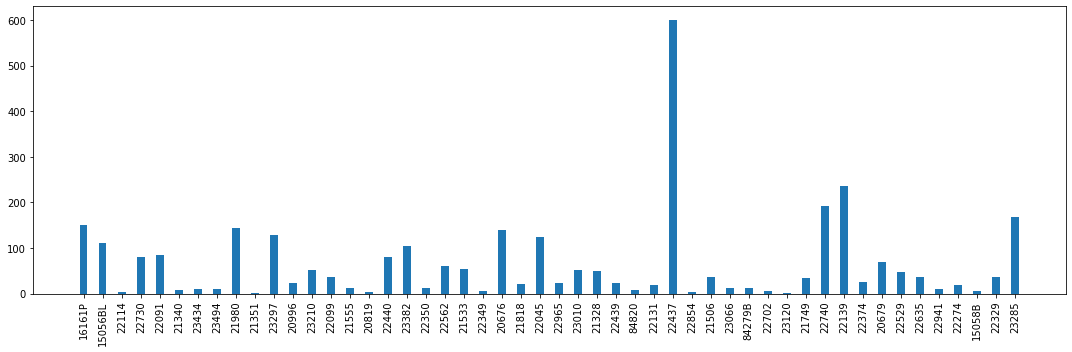

In [17]:
# Chart showig the distribution of each product for each of the available countries
# This question was not very clear for me so I will provide two solutions

# Solution one, showing products for a chosen country

# getting the data organized in the desired way
sum_per_porduct_per_country = db.transactions.aggregate([
    {"$group" : {'_id':{ 
        "product": "$StockCode",
        "country": "$Country",
      },
      "total": { "$sum" : "$Quantity" } }},
      {"$group" : { 
      '_id' :  "$_id.country",
      "products": { 
          "$push": { 
              "product":"$_id.product",
              "total_quantity":"$total"
          }
      }
   }
 }
])

# Store the data into dictionary
#I did not find a better way to deal with the results of the aggreation method as I am new to MongoDB
products_per_country_dict = {}

for product_per_country in sum_per_porduct_per_country:
    products_per_country_dict[product_per_country["_id"]] = product_per_country["products"]


country_str = "France" # Choose your country 
query_country = products_per_country_dict[country_str]

# Get the data into lists to plot them
product_codes = []
quantities = []
product_codes = [pp['product'] for pp in query_country]
quantities = [pp['total_quantity'] for pp in query_country]

# Choose a sub set of products to be able to plot quickly
start_ind = 10 # Choose your value 
end_ind = 60 # Choose your value

sub_product_codes = product_codes[start_ind:end_ind]
sub_quantities = quantities[start_ind:end_ind]
 
y_pos = np.linspace(0.5, 100, len(sub_product_codes))
    
#fig = plt.figure()
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 5))
#ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
plt.bar(y_pos,sub_quantities)
# Create names on the x-axis
plt.xticks(y_pos, sub_product_codes)
plt.tight_layout()
plt.show()

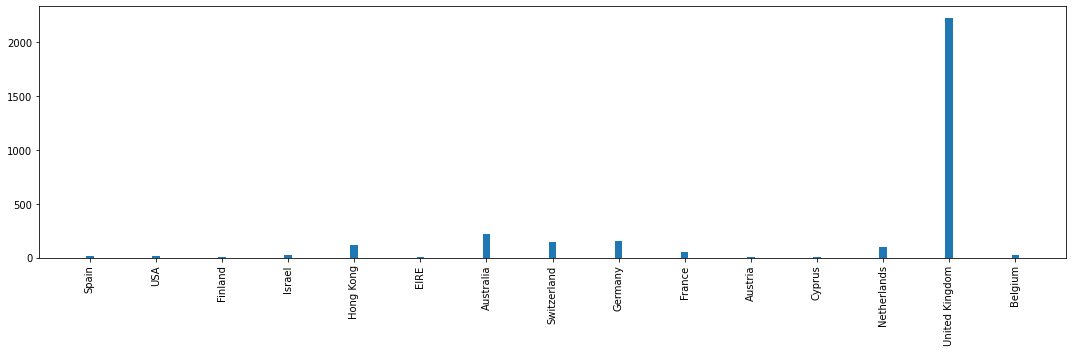

In [18]:
# Solution two, showing countries for a chosen product 

# getting the data organized in the desired way
sum_per_country_per_product = db.transactions.aggregate([
    {"$group" : {'_id':{ 
        "product": "$StockCode",
        "country": "$Country",
      },
      "total": { "$sum" : "$Quantity" } }},
      {"$group" : { 
      '_id' :  "$_id.product",
      "countries": { 
          "$push": { 
              "country":"$_id.country",
              "total_quantity":"$total"
          }
      }
   }
 }
])

# Store the data into dictionary
#I did not find a better way to deal with the results of the aggreation method as I am new to MongoDB
country_per_products_dict = {}

for country_per_product in sum_per_country_per_product:
    country_per_products_dict[country_per_product["_id"]] = country_per_product["countries"]


product_sortCode_str = "20675" # Choose your country 
query_product = country_per_products_dict[product_sortCode_str]

# Get the data into lists to plot them
countries = []
quantities = []
countries = [pp['country'] for pp in query_product]
quantities = [pp['total_quantity'] for pp in query_product]


y_pos = np.linspace(0.5, 100, len(countries))
    
#fig = plt.figure()
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(15, 5))
#ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
plt.bar(y_pos,quantities)
# Create names on the x-axis
plt.xticks(y_pos, countries)
plt.tight_layout()
plt.show()

In [19]:
# average unit price
avg_unit_price = db.transactions.aggregate([
    {"$group" : {'_id':"_id",
    "avg_price": { '$avg': "$UnitPrice" } }},
])

In [20]:
# Showing the results
for avg_price in avg_unit_price:
    print(" Average Price = {Price}".format(
         Price=avg_price["avg_price"]
   ))

 Average Price = 3.515939758791258


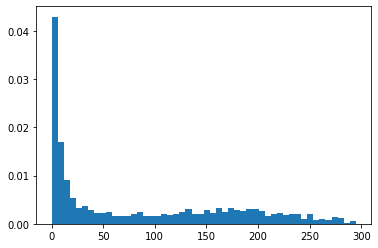

In [21]:
# Chart showing the distribution of prices
prices = db.transactions.distinct('UnitPrice')

plt.hist(prices, bins=50, density=True)
plt.show()

In [22]:
# ratio between price and quantity for each invoice
ratio_price_quantity = db.transactions.aggregate([
    
     { "$project": {
         "InvoiceNo" : "$InvoiceNo",
        "totalPrice": {"$multiply":["$Quantity", "$UnitPrice"]} , 
         "Quantity": "$Quantity"}
    }, 

     {"$group" : {'_id':"$InvoiceNo", 
                  "QuantityInvoice" : { "$sum": "$Quantity" },
                  "totalPriceInvoice" : { "$sum": "$totalPrice" }
                  }},
    { "$project": {
        "ratio": { "$cond": [ { "$eq": [ "$QuantityInvoice", 0 ] }, "N/A", {"$divide":["$totalPriceInvoice", "$QuantityInvoice"]} ] }
    } }
])

In [23]:
for ratio in ratio_price_quantity:
     print(" * InvoiceNo = {InvoiceNo}, ratio price to quantity = {ratio_price}".format(
         InvoiceNo=ratio["_id"],
         ratio_price=ratio["ratio"]
   ))

 * InvoiceNo = 543754, ratio price to quantity = 3.814028776978417
 * InvoiceNo = C550127, ratio price to quantity = 4.283333333333333
 * InvoiceNo = 558096, ratio price to quantity = 3.134137931034483
 * InvoiceNo = 560438, ratio price to quantity = 294.92
 * InvoiceNo = 556308, ratio price to quantity = -0.0
 * InvoiceNo = 549934, ratio price to quantity = 2.202
 * InvoiceNo = 544280, ratio price to quantity = 1.319479768786127
 * InvoiceNo = 572053, ratio price to quantity = 2.08
 * InvoiceNo = 555359, ratio price to quantity = 1.2479545454545455
 * InvoiceNo = 578333, ratio price to quantity = 1.6483168316831682
 * InvoiceNo = 562150, ratio price to quantity = 1.776
 * InvoiceNo = 581241, ratio price to quantity = 1.0939490445859872
 * InvoiceNo = C569996, ratio price to quantity = 1.5041176470588233
 * InvoiceNo = 579446, ratio price to quantity = 1.4360869565217391
 * InvoiceNo = 570010, ratio price to quantity = 2.4006250000000002
 * InvoiceNo = 557137, ratio price to quantity =

 * InvoiceNo = C548713, ratio price to quantity = 2.45
 * InvoiceNo = C541787, ratio price to quantity = 39.95
 * InvoiceNo = 555001, ratio price to quantity = 1.6247368421052635
 * InvoiceNo = 540545, ratio price to quantity = 1.5441923076923076
 * InvoiceNo = 572509, ratio price to quantity = 1.8734562211981567
 * InvoiceNo = C538350, ratio price to quantity = 1.7
 * InvoiceNo = 555568, ratio price to quantity = 1.6684139784946237
 * InvoiceNo = C575841, ratio price to quantity = 1.25
 * InvoiceNo = 563255, ratio price to quantity = 4.430833333333333
 * InvoiceNo = 555581, ratio price to quantity = 2.7451724137931035
 * InvoiceNo = 558720, ratio price to quantity = 8.25
 * InvoiceNo = 552961, ratio price to quantity = 1.583
 * InvoiceNo = 577133, ratio price to quantity = 0.9114035087719299
 * InvoiceNo = 560448, ratio price to quantity = 1.6363636363636365
 * InvoiceNo = 537892, ratio price to quantity = 1.8750588235294117
 * InvoiceNo = 550438, ratio price to quantity = 2.967666666

 * InvoiceNo = 566933, ratio price to quantity = 4.58
 * InvoiceNo = 540537, ratio price to quantity = 1.4125641025641027
 * InvoiceNo = 558232, ratio price to quantity = 1.3814814814814815
 * InvoiceNo = 578629, ratio price to quantity = 0.0
 * InvoiceNo = 579291, ratio price to quantity = 4.80069109947644
 * InvoiceNo = 569657, ratio price to quantity = 0.0
 * InvoiceNo = 568228, ratio price to quantity = 1.042962226640159
 * InvoiceNo = 559297, ratio price to quantity = 1.0300240384615384
 * InvoiceNo = 564841, ratio price to quantity = 3.961221719457013
 * InvoiceNo = 577043, ratio price to quantity = 1.9433333333333334
 * InvoiceNo = 578695, ratio price to quantity = 0.42790697674418604
 * InvoiceNo = 549289, ratio price to quantity = 1.2376973684210526
 * InvoiceNo = 580214, ratio price to quantity = 1.765
 * InvoiceNo = 581584, ratio price to quantity = 1.1720000000000002
 * InvoiceNo = 549728, ratio price to quantity = 1.2680898876404494
 * InvoiceNo = C577151, ratio price to q

 * InvoiceNo = 564060, ratio price to quantity = 1.47814332247557
 * InvoiceNo = 571851, ratio price to quantity = 1.0953459119496856
 * InvoiceNo = 553572, ratio price to quantity = 2.3201960784313727
 * InvoiceNo = 543247, ratio price to quantity = 1.8055555555555556
 * InvoiceNo = 559981, ratio price to quantity = 2.4534146341463416
 * InvoiceNo = 545894, ratio price to quantity = 2.224842105263158
 * InvoiceNo = 567385, ratio price to quantity = 2.281359223300971
 * InvoiceNo = 578043, ratio price to quantity = 1.8831221719457014
 * InvoiceNo = 564953, ratio price to quantity = 1.293173076923077
 * InvoiceNo = 538899, ratio price to quantity = 2.122413793103448
 * InvoiceNo = 580715, ratio price to quantity = 1.25
 * InvoiceNo = 581236, ratio price to quantity = 0.6695698924731183
 * InvoiceNo = 573152, ratio price to quantity = 1.9575862068965515
 * InvoiceNo = 538716, ratio price to quantity = 1.45
 * InvoiceNo = 581379, ratio price to quantity = 2.104059405940594
 * InvoiceNo = 

 * InvoiceNo = 545156, ratio price to quantity = 0.805076923076923
 * InvoiceNo = 547233, ratio price to quantity = 1.5334951456310681
 * InvoiceNo = 546742, ratio price to quantity = 1.3706225680933852
 * InvoiceNo = C545720, ratio price to quantity = 11.45
 * InvoiceNo = 554117, ratio price to quantity = 1.0737620192307693
 * InvoiceNo = 558107, ratio price to quantity = 1.6634666666666666
 * InvoiceNo = 565480, ratio price to quantity = 2.55
 * InvoiceNo = 538126, ratio price to quantity = 2.8000000000000003
 * InvoiceNo = 562103, ratio price to quantity = 0.82
 * InvoiceNo = 545712, ratio price to quantity = 4.013333333333334
 * InvoiceNo = 536520, ratio price to quantity = 1.5913197969543147
 * InvoiceNo = 553884, ratio price to quantity = 4.3034042553191485
 * InvoiceNo = C559608, ratio price to quantity = 1.8700000000000003
 * InvoiceNo = 563444, ratio price to quantity = 2.8274897119341564
 * InvoiceNo = 558126, ratio price to quantity = 2.653625498007968
 * InvoiceNo = 571906,

 * InvoiceNo = 568091, ratio price to quantity = -0.0
 * InvoiceNo = 572035, ratio price to quantity = 1.5141816009557945
 * InvoiceNo = 538155, ratio price to quantity = 2.6767647058823525
 * InvoiceNo = 541866, ratio price to quantity = 1.8713452914798205
 * InvoiceNo = C544057, ratio price to quantity = 9.95
 * InvoiceNo = C559022, ratio price to quantity = 1.6499999999999997
 * InvoiceNo = 550997, ratio price to quantity = 1.3903418803418803
 * InvoiceNo = 542574, ratio price to quantity = -0.0
 * InvoiceNo = 553501, ratio price to quantity = 4.95
 * InvoiceNo = 567635, ratio price to quantity = 1.6501923076923077
 * InvoiceNo = 573276, ratio price to quantity = 1.528370786516854
 * InvoiceNo = 568480, ratio price to quantity = 3.357627118644068
 * InvoiceNo = 573481, ratio price to quantity = 2.7156249999999997
 * InvoiceNo = 548310, ratio price to quantity = 2.688101265822785
 * InvoiceNo = 550836, ratio price to quantity = 4.8088235294117645
 * InvoiceNo = 569385, ratio price to

 * InvoiceNo = 571276, ratio price to quantity = 2.2956050955414016
 * InvoiceNo = C539277, ratio price to quantity = 8.5
 * InvoiceNo = 561796, ratio price to quantity = 2.2304347826086954
 * InvoiceNo = 574044, ratio price to quantity = 3.1954545454545453
 * InvoiceNo = C543742, ratio price to quantity = 1.25
 * InvoiceNo = C561328, ratio price to quantity = 9.45
 * InvoiceNo = C566944, ratio price to quantity = 1.65
 * InvoiceNo = C559738, ratio price to quantity = 9.95
 * InvoiceNo = 570404, ratio price to quantity = 0.7778623188405797
 * InvoiceNo = 575148, ratio price to quantity = 2.2835135135135136
 * InvoiceNo = 581167, ratio price to quantity = 1.9844444444444445
 * InvoiceNo = 562615, ratio price to quantity = 1.2613861386138614
 * InvoiceNo = 555628, ratio price to quantity = 2.6208108108108106
 * InvoiceNo = 539313, ratio price to quantity = 2.335671641791045
 * InvoiceNo = 536534, ratio price to quantity = 2.2676470588235293
 * InvoiceNo = 566904, ratio price to quantity 

 * InvoiceNo = 578852, ratio price to quantity = 1.4783025830258303
 * InvoiceNo = 553056, ratio price to quantity = 16.95
 * InvoiceNo = 565204, ratio price to quantity = 0.5394097222222222
 * InvoiceNo = 567457, ratio price to quantity = 1.5291356542617047
 * InvoiceNo = 542269, ratio price to quantity = 2.6084169884169888
 * InvoiceNo = 548888, ratio price to quantity = -0.0
 * InvoiceNo = 550364, ratio price to quantity = 4.227777777777778
 * InvoiceNo = 550701, ratio price to quantity = 2.1882978723404256
 * InvoiceNo = 556024, ratio price to quantity = 2.7627272727272727
 * InvoiceNo = 571122, ratio price to quantity = 0.8000000000000002
 * InvoiceNo = 547378, ratio price to quantity = 5.587037037037037
 * InvoiceNo = 556827, ratio price to quantity = 1.6993069306930693
 * InvoiceNo = 542431, ratio price to quantity = 3.0971014492753626
 * InvoiceNo = 567912, ratio price to quantity = 0.658955223880597
 * InvoiceNo = 572134, ratio price to quantity = 5.455970149253732
 * InvoiceN

 * InvoiceNo = 580547, ratio price to quantity = -0.0
 * InvoiceNo = 545980, ratio price to quantity = 1.799805194805195
 * InvoiceNo = C544433, ratio price to quantity = 1.25
 * InvoiceNo = 547687, ratio price to quantity = 1.604954954954955
 * InvoiceNo = 551085, ratio price to quantity = 1.8168474576271187
 * InvoiceNo = 554641, ratio price to quantity = 2.125862068965517
 * InvoiceNo = 544591, ratio price to quantity = 1.3064568764568765
 * InvoiceNo = C563197, ratio price to quantity = 1.25
 * InvoiceNo = 565119, ratio price to quantity = 1.0001895734597157
 * InvoiceNo = C543837, ratio price to quantity = 9.075
 * InvoiceNo = 554099, ratio price to quantity = 1.4937265917602995
 * InvoiceNo = 556891, ratio price to quantity = 1.5868181818181817
 * InvoiceNo = 547577, ratio price to quantity = 1.7841666666666667
 * InvoiceNo = 545565, ratio price to quantity = -0.0
 * InvoiceNo = 560033, ratio price to quantity = 2.102773892773893
 * InvoiceNo = 566563, ratio price to quantity = 1

 * InvoiceNo = 574880, ratio price to quantity = 1.0857771260997067
 * InvoiceNo = 569133, ratio price to quantity = 0.4663963963963964
 * InvoiceNo = C540270, ratio price to quantity = 4.924999999999999
 * InvoiceNo = 571377, ratio price to quantity = 4.424242424242424
 * InvoiceNo = 563717, ratio price to quantity = 1.975
 * InvoiceNo = C549788, ratio price to quantity = 4.25
 * InvoiceNo = 570119, ratio price to quantity = 2.95
 * InvoiceNo = 576648, ratio price to quantity = 1.304408163265306
 * InvoiceNo = 561773, ratio price to quantity = 2.0744318181818184
 * InvoiceNo = 569099, ratio price to quantity = 3.25
 * InvoiceNo = 576407, ratio price to quantity = -0.0
 * InvoiceNo = 551352, ratio price to quantity = 2.1687142857142856
 * InvoiceNo = 555653, ratio price to quantity = 1.4217326732673268
 * InvoiceNo = 571447, ratio price to quantity = 3.29
 * InvoiceNo = 576079, ratio price to quantity = 1.9531884057971016
 * InvoiceNo = 546914, ratio price to quantity = 2.5673913043478

 * InvoiceNo = 548640, ratio price to quantity = 7.95
 * InvoiceNo = 558906, ratio price to quantity = 0.7777737881508079
 * InvoiceNo = C564208, ratio price to quantity = 7.05
 * InvoiceNo = 548663, ratio price to quantity = 7.3181355932203385
 * InvoiceNo = 573490, ratio price to quantity = -0.0
 * InvoiceNo = 574669, ratio price to quantity = 1.8590000000000002
 * InvoiceNo = 576196, ratio price to quantity = 0.69455
 * InvoiceNo = C578136, ratio price to quantity = 3.316666666666667
 * InvoiceNo = 566256, ratio price to quantity = 2.6134883720930233
 * InvoiceNo = 551324, ratio price to quantity = 0.0
 * InvoiceNo = 580259, ratio price to quantity = 1.5014285714285716
 * InvoiceNo = 581139, ratio price to quantity = 1.594341085271318
 * InvoiceNo = 554027, ratio price to quantity = 2.068085106382979
 * InvoiceNo = C565925, ratio price to quantity = 18.0
 * InvoiceNo = 580619, ratio price to quantity = 0.46438559322033895
 * InvoiceNo = 576110, ratio price to quantity = 0.0
 * Invoi

 * InvoiceNo = 541316, ratio price to quantity = 2.58953488372093
 * InvoiceNo = 548676, ratio price to quantity = -0.0
 * InvoiceNo = C569891, ratio price to quantity = 3.4257894736842105
 * InvoiceNo = C572968, ratio price to quantity = 1.85
 * InvoiceNo = 578529, ratio price to quantity = -0.0
 * InvoiceNo = 570964, ratio price to quantity = 1.4920927601809955
 * InvoiceNo = 580405, ratio price to quantity = 3.6483333333333334
 * InvoiceNo = 544934, ratio price to quantity = 2.7624113475177303
 * InvoiceNo = 576833, ratio price to quantity = 0.5696977329974812
 * InvoiceNo = 580906, ratio price to quantity = 3.1433333333333335
 * InvoiceNo = 578096, ratio price to quantity = 2.6237500000000002
 * InvoiceNo = 561089, ratio price to quantity = 2.72948717948718
 * InvoiceNo = 545176, ratio price to quantity = 0.0
 * InvoiceNo = 540639, ratio price to quantity = 1.2111965811965812
 * InvoiceNo = 558686, ratio price to quantity = 1.3445255474452553
 * InvoiceNo = 543001, ratio price to q

 * InvoiceNo = 580123, ratio price to quantity = 4.08256880733945
 * InvoiceNo = 559318, ratio price to quantity = 0.6789655172413793
 * InvoiceNo = C560643, ratio price to quantity = 3.95
 * InvoiceNo = 575680, ratio price to quantity = 1.3960618556701032
 * InvoiceNo = 563696, ratio price to quantity = 2.1864102564102565
 * InvoiceNo = 574588, ratio price to quantity = 3.4045454545454548
 * InvoiceNo = 558964, ratio price to quantity = 1.239146005509642
 * InvoiceNo = 543198, ratio price to quantity = 3.749999999999999
 * InvoiceNo = C569990, ratio price to quantity = 4.15
 * InvoiceNo = 556397, ratio price to quantity = 1.79
 * InvoiceNo = 578011, ratio price to quantity = 1.434264705882353
 * InvoiceNo = 538134, ratio price to quantity = 0.0
 * InvoiceNo = 546114, ratio price to quantity = 0.0
 * InvoiceNo = C557657, ratio price to quantity = 8.5
 * InvoiceNo = 563543, ratio price to quantity = 2.5113919413919414
 * InvoiceNo = 558454, ratio price to quantity = 2.675438596491228
 *

 * InvoiceNo = 544165, ratio price to quantity = 3.0272549019607844
 * InvoiceNo = 574154, ratio price to quantity = 1.8234453781512605
 * InvoiceNo = 541670, ratio price to quantity = 2.0696996996997
 * InvoiceNo = 554366, ratio price to quantity = 3.24
 * InvoiceNo = 564133, ratio price to quantity = 1.9081521739130436
 * InvoiceNo = 545701, ratio price to quantity = 2.052312348668281
 * InvoiceNo = 551437, ratio price to quantity = 2.0105263157894733
 * InvoiceNo = 547684, ratio price to quantity = 2.3117878787878787
 * InvoiceNo = 580073, ratio price to quantity = 1.880253164556962
 * InvoiceNo = 581187, ratio price to quantity = 2.0500000000000003
 * InvoiceNo = 547820, ratio price to quantity = 0.9084615384615384
 * InvoiceNo = 555469, ratio price to quantity = 0.0
 * InvoiceNo = 539720, ratio price to quantity = 2.446
 * InvoiceNo = C548915, ratio price to quantity = 1.45
 * InvoiceNo = 562727, ratio price to quantity = 2.7503571428571427
 * InvoiceNo = 552541, ratio price to qu

 * InvoiceNo = 544450, ratio price to quantity = 2.558450704225352
 * InvoiceNo = 554963, ratio price to quantity = 3.9262500000000005
 * InvoiceNo = 556963, ratio price to quantity = -0.0
 * InvoiceNo = 558377, ratio price to quantity = -0.0
 * InvoiceNo = 571212, ratio price to quantity = 1.9592207792207794
 * InvoiceNo = 579543, ratio price to quantity = 5.553333333333334
 * InvoiceNo = 580508, ratio price to quantity = 1.83
 * InvoiceNo = 542597, ratio price to quantity = 7.591904761904762
 * InvoiceNo = 548658, ratio price to quantity = 2.55
 * InvoiceNo = C537444, ratio price to quantity = 5.95
 * InvoiceNo = 575612, ratio price to quantity = 1.451516452074392
 * InvoiceNo = 555282, ratio price to quantity = 1.87635528330781
 * InvoiceNo = 567889, ratio price to quantity = 2.5428358208955224
 * InvoiceNo = 562928, ratio price to quantity = 1.04677808727948
 * InvoiceNo = 569683, ratio price to quantity = 1.3531720430107528
 * InvoiceNo = 556017, ratio price to quantity = 1.262807

 * InvoiceNo = 570868, ratio price to quantity = 0.0
 * InvoiceNo = 572907, ratio price to quantity = 1.8611111111111112
 * InvoiceNo = 544353, ratio price to quantity = 5.996666666666667
 * InvoiceNo = 546828, ratio price to quantity = 5.95
 * InvoiceNo = 539636, ratio price to quantity = 2.700683760683761
 * InvoiceNo = 546876, ratio price to quantity = 0.42
 * InvoiceNo = 548650, ratio price to quantity = 1.3326086956521739
 * InvoiceNo = 552299, ratio price to quantity = 6.708823529411765
 * InvoiceNo = 554791, ratio price to quantity = 1.45
 * InvoiceNo = 556890, ratio price to quantity = 2.08909626719057
 * InvoiceNo = 569740, ratio price to quantity = 1.8275
 * InvoiceNo = C570902, ratio price to quantity = 3.3954545454545455
 * InvoiceNo = 545429, ratio price to quantity = 2.2511940298507462
 * InvoiceNo = 552271, ratio price to quantity = 2.592241379310345
 * InvoiceNo = 562114, ratio price to quantity = 4.179013157894737
 * InvoiceNo = 544322, ratio price to quantity = 0.9307

 * InvoiceNo = 565792, ratio price to quantity = 1.6082142857142858
 * InvoiceNo = 569243, ratio price to quantity = 2.1918217054263565
 * InvoiceNo = C552698, ratio price to quantity = 2.95
 * InvoiceNo = 551980, ratio price to quantity = 3.1214285714285714
 * InvoiceNo = 537700, ratio price to quantity = 4.544117647058823
 * InvoiceNo = 538365, ratio price to quantity = 3.319607843137255
 * InvoiceNo = 555348, ratio price to quantity = 3.2223287671232876
 * InvoiceNo = 564716, ratio price to quantity = 1.8735638297872341
 * InvoiceNo = C569942, ratio price to quantity = 6.75
 * InvoiceNo = 544970, ratio price to quantity = 2.41875
 * InvoiceNo = 574103, ratio price to quantity = 1.1959288537549406
 * InvoiceNo = 563073, ratio price to quantity = 0.8538502673796791
 * InvoiceNo = 562138, ratio price to quantity = 4.233660130718954
 * InvoiceNo = 566594, ratio price to quantity = 2.3948979591836737
 * InvoiceNo = 578372, ratio price to quantity = 4.654999999999999
 * InvoiceNo = 578691

 * InvoiceNo = 562805, ratio price to quantity = 3.59
 * InvoiceNo = 554377, ratio price to quantity = 0.0
 * InvoiceNo = 550504, ratio price to quantity = 1.8927586206896552
 * InvoiceNo = 577783, ratio price to quantity = 1.6948905109489052
 * InvoiceNo = 576600, ratio price to quantity = 2.621917808219178
 * InvoiceNo = 568001, ratio price to quantity = 2.860618556701031
 * InvoiceNo = C537853, ratio price to quantity = 4.792857142857143
 * InvoiceNo = 556504, ratio price to quantity = 1.141151515151515
 * InvoiceNo = C537998, ratio price to quantity = 3.75
 * InvoiceNo = 545993, ratio price to quantity = 2.116030150753769
 * InvoiceNo = 543595, ratio price to quantity = 1.4770506912442396
 * InvoiceNo = C560148, ratio price to quantity = 1.79
 * InvoiceNo = 566325, ratio price to quantity = 0.0
 * InvoiceNo = C543819, ratio price to quantity = 3.413157894736842
 * InvoiceNo = C557521, ratio price to quantity = 0.38999999999999996
 * InvoiceNo = 564666, ratio price to quantity = 1.8

 * InvoiceNo = 562942, ratio price to quantity = 7.6891304347826095
 * InvoiceNo = 569388, ratio price to quantity = 7.08
 * InvoiceNo = 554283, ratio price to quantity = 2.1144534412955465
 * InvoiceNo = 554929, ratio price to quantity = 1.172108626198083
 * InvoiceNo = 537389, ratio price to quantity = 2.4833333333333334
 * InvoiceNo = C559705, ratio price to quantity = 1.65
 * InvoiceNo = 547815, ratio price to quantity = 2.1620264317180617
 * InvoiceNo = 542997, ratio price to quantity = 8.997954545454546
 * InvoiceNo = 537392, ratio price to quantity = 2.0768750000000002
 * InvoiceNo = 550218, ratio price to quantity = 1.8675789473684212
 * InvoiceNo = 574836, ratio price to quantity = 1.988867924528302
 * InvoiceNo = C538802, ratio price to quantity = 2.85
 * InvoiceNo = 555320, ratio price to quantity = 7.410588235294117
 * InvoiceNo = 553506, ratio price to quantity = 1.9300000000000002
 * InvoiceNo = C556057, ratio price to quantity = 4.95
 * InvoiceNo = 572882, ratio price to

 * InvoiceNo = 570514, ratio price to quantity = 2.2785458612975393
 * InvoiceNo = C574095, ratio price to quantity = 3.0566666666666666
 * InvoiceNo = 575894, ratio price to quantity = 0.28043202033036846
 * InvoiceNo = C576850, ratio price to quantity = 4.935714285714285
 * InvoiceNo = 538135, ratio price to quantity = 0.0
 * InvoiceNo = 568873, ratio price to quantity = 1.664179104477612
 * InvoiceNo = 577326, ratio price to quantity = 4.882352941176471
 * InvoiceNo = 577720, ratio price to quantity = 3.4145283018867927
 * InvoiceNo = 580290, ratio price to quantity = 1.172543352601156
 * InvoiceNo = C564362, ratio price to quantity = 6.825
 * InvoiceNo = 580297, ratio price to quantity = 1.951834862385321
 * InvoiceNo = 581246, ratio price to quantity = 2.0191044776119402
 * InvoiceNo = 542905, ratio price to quantity = 1.4973056994818654
 * InvoiceNo = 548624, ratio price to quantity = 2.886
 * InvoiceNo = 550052, ratio price to quantity = 2.1340909090909093
 * InvoiceNo = 563756,

 * InvoiceNo = 568140, ratio price to quantity = 2.49
 * InvoiceNo = 576184, ratio price to quantity = 2.3375
 * InvoiceNo = 567381, ratio price to quantity = 3.5574558303886925
 * InvoiceNo = 572697, ratio price to quantity = 0.0
 * InvoiceNo = 540167, ratio price to quantity = 0.6915384615384615
 * InvoiceNo = 560257, ratio price to quantity = 1.1523328591749644
 * InvoiceNo = 569559, ratio price to quantity = 1.4299999999999997
 * InvoiceNo = 538519, ratio price to quantity = 5.216666666666667
 * InvoiceNo = 536607, ratio price to quantity = 3.2684946236559145
 * InvoiceNo = 544480, ratio price to quantity = 1.5675210708973724
 * InvoiceNo = C551892, ratio price to quantity = 1.95
 * InvoiceNo = 553418, ratio price to quantity = 1.8614583333333332
 * InvoiceNo = 550619, ratio price to quantity = 2.1471428571428572
 * InvoiceNo = 557279, ratio price to quantity = 1.38396449704142
 * InvoiceNo = 541995, ratio price to quantity = 1.899333333333333
 * InvoiceNo = C543004, ratio price to

 * InvoiceNo = 570818, ratio price to quantity = 1.5840111420612812
 * InvoiceNo = 555124, ratio price to quantity = 1.4016071428571428
 * InvoiceNo = 567462, ratio price to quantity = 1.032918918918919
 * InvoiceNo = 567615, ratio price to quantity = 1.4036550308008215
 * InvoiceNo = 577698, ratio price to quantity = 1.0090880503144655
 * InvoiceNo = 581230, ratio price to quantity = 1.0888461538461538
 * InvoiceNo = 571033, ratio price to quantity = 1.68828418230563
 * InvoiceNo = 577809, ratio price to quantity = 6.575396825396825
 * InvoiceNo = 575482, ratio price to quantity = 2.0567955801104976
 * InvoiceNo = 558077, ratio price to quantity = 1.233554006968641
 * InvoiceNo = 559604, ratio price to quantity = 0.0
 * InvoiceNo = 561488, ratio price to quantity = 2.061153846153846
 * InvoiceNo = 575601, ratio price to quantity = 2.992857142857143
 * InvoiceNo = 541602, ratio price to quantity = 1.8940909090909093
 * InvoiceNo = 537648, ratio price to quantity = 1.4856457564575647
 *

 * InvoiceNo = 576558, ratio price to quantity = 1.483157894736842
 * InvoiceNo = 579003, ratio price to quantity = 1.397289156626506
 * InvoiceNo = 543387, ratio price to quantity = 1.1601065719360568
 * InvoiceNo = 579097, ratio price to quantity = 2.657046632124352
 * InvoiceNo = 574245, ratio price to quantity = 1.45
 * InvoiceNo = 579408, ratio price to quantity = 2.264108527131783
 * InvoiceNo = 580132, ratio price to quantity = 3.418235294117647
 * InvoiceNo = 540840, ratio price to quantity = 2.414888888888889
 * InvoiceNo = 548899, ratio price to quantity = 1.9298130841121497
 * InvoiceNo = 555589, ratio price to quantity = 1.36171974522293
 * InvoiceNo = 568895, ratio price to quantity = 1.7361855670103092
 * InvoiceNo = 541978, ratio price to quantity = 7.650000000000001
 * InvoiceNo = 548497, ratio price to quantity = 2.2378068965517244
 * InvoiceNo = 539597, ratio price to quantity = 2.55
 * InvoiceNo = 546562, ratio price to quantity = 2.387669172932331
 * InvoiceNo = 546

 * InvoiceNo = C564081, ratio price to quantity = 10.95
 * InvoiceNo = 565082, ratio price to quantity = 5.378571428571428
 * InvoiceNo = C571902, ratio price to quantity = 2.8083333333333336
 * InvoiceNo = C569913, ratio price to quantity = 4.95
 * InvoiceNo = 544394, ratio price to quantity = 4.269444444444444
 * InvoiceNo = 572453, ratio price to quantity = 3.2787272727272723
 * InvoiceNo = 548373, ratio price to quantity = 3.6804656319290463
 * InvoiceNo = 571259, ratio price to quantity = 0.85
 * InvoiceNo = 553754, ratio price to quantity = 1.6176666666666664
 * InvoiceNo = 573585, ratio price to quantity = 2.858481816432557
 * InvoiceNo = 575583, ratio price to quantity = 1.4536464088397791
 * InvoiceNo = 573313, ratio price to quantity = 3.8137499999999998
 * InvoiceNo = 569362, ratio price to quantity = 3.261019108280255
 * InvoiceNo = 577956, ratio price to quantity = 0.0
 * InvoiceNo = 547867, ratio price to quantity = 1.8942546583850932
 * InvoiceNo = 572058, ratio price to

 * InvoiceNo = 580379, ratio price to quantity = -0.0
 * InvoiceNo = 575609, ratio price to quantity = 1.6735074626865671
 * InvoiceNo = 580396, ratio price to quantity = 2.256808510638298
 * InvoiceNo = 549940, ratio price to quantity = 0.8173570138470801
 * InvoiceNo = 553144, ratio price to quantity = 1.8328402366863905
 * InvoiceNo = 558477, ratio price to quantity = -0.0
 * InvoiceNo = 555822, ratio price to quantity = -0.0
 * InvoiceNo = 571286, ratio price to quantity = 2.103862660944206
 * InvoiceNo = 559516, ratio price to quantity = 4.702
 * InvoiceNo = 562809, ratio price to quantity = 3.7803448275862066
 * InvoiceNo = 568953, ratio price to quantity = 1.3436809815950919
 * InvoiceNo = C579932, ratio price to quantity = 9.95
 * InvoiceNo = 572674, ratio price to quantity = 4.186129032258065
 * InvoiceNo = C540366, ratio price to quantity = 0.72
 * InvoiceNo = 536976, ratio price to quantity = 1.9710526315789476
 * InvoiceNo = 556573, ratio price to quantity = 3.0635668789808

 * InvoiceNo = 537354, ratio price to quantity = 1.5655294117647058
 * InvoiceNo = 570023, ratio price to quantity = 3.408333333333333
 * InvoiceNo = 569212, ratio price to quantity = 2.1883410138248847
 * InvoiceNo = 566620, ratio price to quantity = 1.47
 * InvoiceNo = 577503, ratio price to quantity = 2.7476744186046513
 * InvoiceNo = 578256, ratio price to quantity = 1.45
 * InvoiceNo = C576918, ratio price to quantity = 7.45
 * InvoiceNo = 580958, ratio price to quantity = 1.4559504132231404
 * InvoiceNo = 556534, ratio price to quantity = 0.8176923076923078
 * InvoiceNo = 548338, ratio price to quantity = 1.0193567251461988
 * InvoiceNo = 565791, ratio price to quantity = 1.9750000000000003
 * InvoiceNo = C548532, ratio price to quantity = 5.416666666666667
 * InvoiceNo = 558053, ratio price to quantity = 2.628991596638655
 * InvoiceNo = 552293, ratio price to quantity = 1.5738181818181818
 * InvoiceNo = 574307, ratio price to quantity = 2.3312
 * InvoiceNo = 573019, ratio price 

 * InvoiceNo = 545063, ratio price to quantity = 2.8663829787234043
 * InvoiceNo = 567514, ratio price to quantity = 1.3266666666666667
 * InvoiceNo = C569034, ratio price to quantity = 3.085
 * InvoiceNo = 548258, ratio price to quantity = 2.547307692307692
 * InvoiceNo = 559126, ratio price to quantity = 1.45
 * InvoiceNo = C565581, ratio price to quantity = 4.95
 * InvoiceNo = C572485, ratio price to quantity = 7.775
 * InvoiceNo = 575717, ratio price to quantity = -0.0
 * InvoiceNo = 554159, ratio price to quantity = 10.5
 * InvoiceNo = 554369, ratio price to quantity = 0.83
 * InvoiceNo = 540561, ratio price to quantity = 1.256846153846154
 * InvoiceNo = 553149, ratio price to quantity = 1.9259946949602123
 * InvoiceNo = C542589, ratio price to quantity = 4.95
 * InvoiceNo = 543623, ratio price to quantity = 0.8717391304347827
 * InvoiceNo = C544665, ratio price to quantity = 2.95
 * InvoiceNo = C541693, ratio price to quantity = 2.3464285714285715
 * InvoiceNo = 559165, ratio pri

 * InvoiceNo = 571228, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = C545739, ratio price to quantity = 45.57
 * InvoiceNo = 573254, ratio price to quantity = -0.0
 * InvoiceNo = 540455, ratio price to quantity = 1.4870875763747453
 * InvoiceNo = 575186, ratio price to quantity = 1.2965240641711229
 * InvoiceNo = 580152, ratio price to quantity = 0.6181673306772908
 * InvoiceNo = 581378, ratio price to quantity = 1.2093548387096773
 * InvoiceNo = 545858, ratio price to quantity = 4.0
 * InvoiceNo = 566788, ratio price to quantity = 1.8570774263904035
 * InvoiceNo = 550289, ratio price to quantity = 1.5110362694300519
 * InvoiceNo = 575211, ratio price to quantity = 2.0986131386861313
 * InvoiceNo = 568384, ratio price to quantity = 0.0
 * InvoiceNo = 561113, ratio price to quantity = 0.9842822966507178
 * InvoiceNo = 555556, ratio price to quantity = 2.229294117647059
 * InvoiceNo = 542151, ratio price to quantity = 2.645774647887324
 * InvoiceNo = 561378, ratio price to 

 * InvoiceNo = 553942, ratio price to quantity = 2.8824404761904763
 * InvoiceNo = 556098, ratio price to quantity = 12.5
 * InvoiceNo = 564862, ratio price to quantity = 145.0
 * InvoiceNo = 544439, ratio price to quantity = 0.9015075376884423
 * InvoiceNo = 578477, ratio price to quantity = -0.0
 * InvoiceNo = C562188, ratio price to quantity = 1.79
 * InvoiceNo = 548608, ratio price to quantity = 2.443548387096774
 * InvoiceNo = 556912, ratio price to quantity = 1.1831020408163266
 * InvoiceNo = 565388, ratio price to quantity = 2.277586206896552
 * InvoiceNo = 571438, ratio price to quantity = 2.818895899053628
 * InvoiceNo = 566074, ratio price to quantity = 3.316346153846154
 * InvoiceNo = 580816, ratio price to quantity = 0.8935684647302905
 * InvoiceNo = 554325, ratio price to quantity = 2.0208163265306123
 * InvoiceNo = 558306, ratio price to quantity = -0.0
 * InvoiceNo = 543310, ratio price to quantity = -0.0
 * InvoiceNo = 553886, ratio price to quantity = 2.619230769230769

 * InvoiceNo = 558643, ratio price to quantity = 2.0341584158415844
 * InvoiceNo = 547336, ratio price to quantity = -0.0
 * InvoiceNo = 547707, ratio price to quantity = 1.95
 * InvoiceNo = 552816, ratio price to quantity = 1.6564102564102563
 * InvoiceNo = 563818, ratio price to quantity = 2.0121052631578946
 * InvoiceNo = 543043, ratio price to quantity = 3.411538461538462
 * InvoiceNo = C553032, ratio price to quantity = 2.3333333333333335
 * InvoiceNo = 557760, ratio price to quantity = 0.9075250836120402
 * InvoiceNo = 543025, ratio price to quantity = 0.6676470588235295
 * InvoiceNo = 540651, ratio price to quantity = -0.0
 * InvoiceNo = 546662, ratio price to quantity = 2.96875
 * InvoiceNo = 566982, ratio price to quantity = 0.0
 * InvoiceNo = 567824, ratio price to quantity = 37.5
 * InvoiceNo = 554116, ratio price to quantity = 2.843461538461539
 * InvoiceNo = 578067, ratio price to quantity = 3.1455719557195567
 * InvoiceNo = 578400, ratio price to quantity = 1.528454545454

 * InvoiceNo = 571944, ratio price to quantity = 0.728239608801956
 * InvoiceNo = 537811, ratio price to quantity = 3.6332432432432435
 * InvoiceNo = 575209, ratio price to quantity = 1.0375
 * InvoiceNo = 551020, ratio price to quantity = -0.0
 * InvoiceNo = 561105, ratio price to quantity = 2.1243589743589744
 * InvoiceNo = 558238, ratio price to quantity = -0.0
 * InvoiceNo = 557119, ratio price to quantity = 1.5525496688741722
 * InvoiceNo = 545074, ratio price to quantity = 1.1032374100719424
 * InvoiceNo = 552054, ratio price to quantity = 1.2792028985507247
 * InvoiceNo = C553687, ratio price to quantity = 1.67875
 * InvoiceNo = 562043, ratio price to quantity = 1.434946996466431
 * InvoiceNo = 538379, ratio price to quantity = 2.415909090909091
 * InvoiceNo = 562772, ratio price to quantity = 3.3429687500000003
 * InvoiceNo = 565405, ratio price to quantity = 2.2920833333333337
 * InvoiceNo = 566595, ratio price to quantity = 0.5647972972972973
 * InvoiceNo = 569538, ratio pric

 * InvoiceNo = 559139, ratio price to quantity = 0.9279611650485436
 * InvoiceNo = 559745, ratio price to quantity = 2.405744680851064
 * InvoiceNo = 579693, ratio price to quantity = 2.2686813186813186
 * InvoiceNo = 571280, ratio price to quantity = 2.1924752475247526
 * InvoiceNo = 578116, ratio price to quantity = 1.1045964912280701
 * InvoiceNo = 549547, ratio price to quantity = 2.92
 * InvoiceNo = 553870, ratio price to quantity = 1.210633484162896
 * InvoiceNo = 574351, ratio price to quantity = 0.6973125
 * InvoiceNo = 580538, ratio price to quantity = 1.568217821782178
 * InvoiceNo = 554705, ratio price to quantity = 2.8919047619047618
 * InvoiceNo = 545327, ratio price to quantity = 1.9314814814814814
 * InvoiceNo = 547415, ratio price to quantity = 12.75
 * InvoiceNo = 549789, ratio price to quantity = 1.0754130052724076
 * InvoiceNo = 550279, ratio price to quantity = 2.2478193146417444
 * InvoiceNo = 538668, ratio price to quantity = 2.4065217391304348
 * InvoiceNo = 5489

 * InvoiceNo = 536386, ratio price to quantity = 2.1533898305084747
 * InvoiceNo = 552695, ratio price to quantity = 1.3037920489296635
 * InvoiceNo = 568208, ratio price to quantity = 1.9262499999999998
 * InvoiceNo = 576431, ratio price to quantity = 0.0
 * InvoiceNo = C562438, ratio price to quantity = 3.766666666666667
 * InvoiceNo = 548412, ratio price to quantity = 2.2653061224489797
 * InvoiceNo = 572792, ratio price to quantity = 2.89
 * InvoiceNo = 576089, ratio price to quantity = 3.066969696969697
 * InvoiceNo = 552269, ratio price to quantity = 2.027394366197183
 * InvoiceNo = 574862, ratio price to quantity = 2.0671232876712327
 * InvoiceNo = 580023, ratio price to quantity = 1.418503937007874
 * InvoiceNo = 546560, ratio price to quantity = 1.25
 * InvoiceNo = C555398, ratio price to quantity = 4.6000000000000005
 * InvoiceNo = 552337, ratio price to quantity = 1.7555526315789474
 * InvoiceNo = C550808, ratio price to quantity = 3.2750000000000004
 * InvoiceNo = 569881, r

 * InvoiceNo = 561455, ratio price to quantity = 1.2609433962264152
 * InvoiceNo = 559507, ratio price to quantity = 1.782909090909091
 * InvoiceNo = 539142, ratio price to quantity = 1.5383177570093458
 * InvoiceNo = 553227, ratio price to quantity = 5.371428571428572
 * InvoiceNo = 562701, ratio price to quantity = 2.1455357142857143
 * InvoiceNo = 542611, ratio price to quantity = 0.9961913043478262
 * InvoiceNo = 569240, ratio price to quantity = 1.1930769230769231
 * InvoiceNo = 580106, ratio price to quantity = 1.6143809523809522
 * InvoiceNo = 569842, ratio price to quantity = 2.692895752895753
 * InvoiceNo = 538283, ratio price to quantity = 1.47
 * InvoiceNo = 550389, ratio price to quantity = 1.0511881188118812
 * InvoiceNo = C564730, ratio price to quantity = 8.5
 * InvoiceNo = 568792, ratio price to quantity = 2.8258702064896757
 * InvoiceNo = C545453, ratio price to quantity = 10.6
 * InvoiceNo = C543356, ratio price to quantity = 1.25
 * InvoiceNo = 544700, ratio price to

 * InvoiceNo = 549308, ratio price to quantity = 1.7942105263157897
 * InvoiceNo = C564998, ratio price to quantity = 2.08
 * InvoiceNo = 569013, ratio price to quantity = 3.607142857142857
 * InvoiceNo = 569857, ratio price to quantity = 2.228709677419355
 * InvoiceNo = 572318, ratio price to quantity = 1.6311453744493392
 * InvoiceNo = 574088, ratio price to quantity = 2.6578125
 * InvoiceNo = 540982, ratio price to quantity = 0.0
 * InvoiceNo = 551281, ratio price to quantity = 1.3927472527472529
 * InvoiceNo = 577405, ratio price to quantity = 2.17265306122449
 * InvoiceNo = 580025, ratio price to quantity = 2.1997272727272725
 * InvoiceNo = 580638, ratio price to quantity = 1.5979347826086956
 * InvoiceNo = 543832, ratio price to quantity = 1.5584644194756554
 * InvoiceNo = 547515, ratio price to quantity = 2.2952777777777778
 * InvoiceNo = 549909, ratio price to quantity = 2.2787596899224805
 * InvoiceNo = C548721, ratio price to quantity = 1.5333333333333332
 * InvoiceNo = 57703

 * InvoiceNo = 573633, ratio price to quantity = 7.147115384615384
 * InvoiceNo = 573868, ratio price to quantity = 1.7707692307692309
 * InvoiceNo = 551577, ratio price to quantity = -0.0
 * InvoiceNo = 562769, ratio price to quantity = 1.9080000000000001
 * InvoiceNo = 550944, ratio price to quantity = 3.045238095238095
 * InvoiceNo = C565402, ratio price to quantity = 1.25
 * InvoiceNo = 545838, ratio price to quantity = 2.045576923076923
 * InvoiceNo = 545017, ratio price to quantity = 2.086813186813187
 * InvoiceNo = 566435, ratio price to quantity = 4.444117647058825
 * InvoiceNo = 572683, ratio price to quantity = 2.0272727272727273
 * InvoiceNo = 546117, ratio price to quantity = 1.9952691218130312
 * InvoiceNo = 566289, ratio price to quantity = 1.8090625
 * InvoiceNo = 572906, ratio price to quantity = 3.3511111111111114
 * InvoiceNo = 541793, ratio price to quantity = 1.6284905660377358
 * InvoiceNo = 573632, ratio price to quantity = 2.957
 * InvoiceNo = 566317, ratio price

 * InvoiceNo = 567508, ratio price to quantity = 2.1535714285714285
 * InvoiceNo = C578282, ratio price to quantity = 4.25
 * InvoiceNo = 561528, ratio price to quantity = 1.9229343629343627
 * InvoiceNo = 580719, ratio price to quantity = 2.0263636363636364
 * InvoiceNo = 574196, ratio price to quantity = 1.875
 * InvoiceNo = 580848, ratio price to quantity = 2.4943181818181817
 * InvoiceNo = 540094, ratio price to quantity = 1.8517751479289941
 * InvoiceNo = 555147, ratio price to quantity = 2.49010989010989
 * InvoiceNo = 561088, ratio price to quantity = 2.08
 * InvoiceNo = 540835, ratio price to quantity = 1.3469565217391304
 * InvoiceNo = 561223, ratio price to quantity = 1.082695035460993
 * InvoiceNo = 552035, ratio price to quantity = 8.75
 * InvoiceNo = C554300, ratio price to quantity = 8.95
 * InvoiceNo = 553878, ratio price to quantity = 2.445492957746479
 * InvoiceNo = 561858, ratio price to quantity = 1.8125
 * InvoiceNo = 575487, ratio price to quantity = 1.143191489361

 * InvoiceNo = 554546, ratio price to quantity = 1.721359223300971
 * InvoiceNo = 554919, ratio price to quantity = 1.79
 * InvoiceNo = 573396, ratio price to quantity = 1.1244571428571428
 * InvoiceNo = 581356, ratio price to quantity = 4.112962962962963
 * InvoiceNo = 545937, ratio price to quantity = 1.4158611361587017
 * InvoiceNo = 562453, ratio price to quantity = 1.9224590163934427
 * InvoiceNo = 570112, ratio price to quantity = -0.0
 * InvoiceNo = C557411, ratio price to quantity = 5.5
 * InvoiceNo = 561097, ratio price to quantity = 2.026530612244898
 * InvoiceNo = C566078, ratio price to quantity = 45.33
 * InvoiceNo = 561520, ratio price to quantity = 0.950625
 * InvoiceNo = 566952, ratio price to quantity = 2.6190743155149936
 * InvoiceNo = C574261, ratio price to quantity = 3.102727272727273
 * InvoiceNo = 544467, ratio price to quantity = 2.7885981308411214
 * InvoiceNo = 548383, ratio price to quantity = 0.0
 * InvoiceNo = 538143, ratio price to quantity = 0.0
 * Invoic

 * InvoiceNo = C558422, ratio price to quantity = 1.6090243902439023
 * InvoiceNo = 571746, ratio price to quantity = 1.9464556962025317
 * InvoiceNo = 569528, ratio price to quantity = 1.7411181434599154
 * InvoiceNo = C543835, ratio price to quantity = 1.95
 * InvoiceNo = 569650, ratio price to quantity = 2.268857142857143
 * InvoiceNo = C571501, ratio price to quantity = 153.13
 * InvoiceNo = 539920, ratio price to quantity = 2.5552287581699344
 * InvoiceNo = 575701, ratio price to quantity = 2.112190889370933
 * InvoiceNo = 561256, ratio price to quantity = -0.0
 * InvoiceNo = 568234, ratio price to quantity = 1.3489156626506023
 * InvoiceNo = 576830, ratio price to quantity = 1.8732051282051283
 * InvoiceNo = 580615, ratio price to quantity = 1.8456019900497511
 * InvoiceNo = 540558, ratio price to quantity = -0.0
 * InvoiceNo = 548188, ratio price to quantity = 1.4012068965517241
 * InvoiceNo = 569729, ratio price to quantity = 2.063838862559242
 * InvoiceNo = 578035, ratio price

 * InvoiceNo = C560932, ratio price to quantity = 2.0833333333333335
 * InvoiceNo = C545689, ratio price to quantity = 2.8200000000000003
 * InvoiceNo = 553004, ratio price to quantity = 1.7700675675675677
 * InvoiceNo = 537041, ratio price to quantity = 2.993076923076923
 * InvoiceNo = 547103, ratio price to quantity = 1.7653846153846156
 * InvoiceNo = 546148, ratio price to quantity = -0.0
 * InvoiceNo = 560115, ratio price to quantity = 2.511111111111111
 * InvoiceNo = 555470, ratio price to quantity = 2.4710280373831774
 * InvoiceNo = 565446, ratio price to quantity = 2.0012
 * InvoiceNo = 571719, ratio price to quantity = 0.0
 * InvoiceNo = 575418, ratio price to quantity = 2.08
 * InvoiceNo = 577338, ratio price to quantity = 1.1072000000000002
 * InvoiceNo = 556468, ratio price to quantity = 3.3645454545454547
 * InvoiceNo = 556578, ratio price to quantity = 1.6013400758533503
 * InvoiceNo = 562210, ratio price to quantity = 1.5872750642673523
 * InvoiceNo = 550920, ratio price 

 * InvoiceNo = 572547, ratio price to quantity = 0.0
 * InvoiceNo = 537020, ratio price to quantity = -0.0
 * InvoiceNo = 548404, ratio price to quantity = 2.325944333996024
 * InvoiceNo = 555852, ratio price to quantity = 2.4266666666666667
 * InvoiceNo = 560691, ratio price to quantity = 1.5911641791044775
 * InvoiceNo = 557264, ratio price to quantity = 0.7208943089430895
 * InvoiceNo = 563094, ratio price to quantity = 1.247313432835821
 * InvoiceNo = 563540, ratio price to quantity = 1.6014330218068533
 * InvoiceNo = 574442, ratio price to quantity = 4.037985611510791
 * InvoiceNo = 545991, ratio price to quantity = 1.5870973451327435
 * InvoiceNo = 557127, ratio price to quantity = 1.7313235294117646
 * InvoiceNo = C579933, ratio price to quantity = 12.75
 * InvoiceNo = 580298, ratio price to quantity = 0.9805117270788913
 * InvoiceNo = 559924, ratio price to quantity = 7.95
 * InvoiceNo = 561522, ratio price to quantity = 5.1499999999999995
 * InvoiceNo = 564825, ratio price to 

 * InvoiceNo = 553706, ratio price to quantity = 1.7393103448275862
 * InvoiceNo = 543264, ratio price to quantity = 1.3711290322580645
 * InvoiceNo = 542351, ratio price to quantity = 3.9038461538461537
 * InvoiceNo = 553882, ratio price to quantity = 3.1961538461538463
 * InvoiceNo = 565430, ratio price to quantity = 1.0566176470588236
 * InvoiceNo = C555409, ratio price to quantity = 2.55
 * InvoiceNo = 568152, ratio price to quantity = 1.6907472527472527
 * InvoiceNo = C568646, ratio price to quantity = 2.2657142857142856
 * InvoiceNo = 536732, ratio price to quantity = 1.2939416058394162
 * InvoiceNo = 572562, ratio price to quantity = 1.5773309608540926
 * InvoiceNo = 546781, ratio price to quantity = 1.1728217821782179
 * InvoiceNo = 574470, ratio price to quantity = 0.2868
 * InvoiceNo = C560907, ratio price to quantity = 4.15
 * InvoiceNo = 561371, ratio price to quantity = 3.8406382978723403
 * InvoiceNo = 548334, ratio price to quantity = 3.2261904761904763
 * InvoiceNo = 55

 * InvoiceNo = C555727, ratio price to quantity = 8.0
 * InvoiceNo = 576597, ratio price to quantity = 1.5034457478005865
 * InvoiceNo = 569875, ratio price to quantity = -0.0
 * InvoiceNo = 572772, ratio price to quantity = 1.5603170522707799
 * InvoiceNo = 543390, ratio price to quantity = -0.0
 * InvoiceNo = 576874, ratio price to quantity = 2.6336923076923076
 * InvoiceNo = 572726, ratio price to quantity = 1.9159942363112392
 * InvoiceNo = C560563, ratio price to quantity = 6.083333333333333
 * InvoiceNo = 569656, ratio price to quantity = 4.15
 * InvoiceNo = 547599, ratio price to quantity = -0.0
 * InvoiceNo = 556882, ratio price to quantity = 2.3306849315068496
 * InvoiceNo = 553750, ratio price to quantity = 1.7058095238095239
 * InvoiceNo = 554378, ratio price to quantity = 0.0
 * InvoiceNo = 553405, ratio price to quantity = 1.8641025641025641
 * InvoiceNo = 573897, ratio price to quantity = 0.705970515970516
 * InvoiceNo = 551736, ratio price to quantity = 1.06
 * InvoiceNo

 * InvoiceNo = C546323, ratio price to quantity = 3.292857142857143
 * InvoiceNo = 548630, ratio price to quantity = 1.8500000000000003
 * InvoiceNo = 538532, ratio price to quantity = 2.7252136752136753
 * InvoiceNo = C554846, ratio price to quantity = 12.75
 * InvoiceNo = 567513, ratio price to quantity = 2.8820754716981134
 * InvoiceNo = 555203, ratio price to quantity = 2.217625
 * InvoiceNo = C572109, ratio price to quantity = 22.8
 * InvoiceNo = C575171, ratio price to quantity = 4.95
 * InvoiceNo = 536630, ratio price to quantity = 2.7779545454545453
 * InvoiceNo = 540800, ratio price to quantity = 0.8306593406593407
 * InvoiceNo = 577150, ratio price to quantity = 4.834378860672615
 * InvoiceNo = 577842, ratio price to quantity = 4.449435028248588
 * InvoiceNo = 562393, ratio price to quantity = 2.1416806722689077
 * InvoiceNo = 572322, ratio price to quantity = 2.4793103448275864
 * InvoiceNo = C576350, ratio price to quantity = 0.85
 * InvoiceNo = 551168, ratio price to quant

 * InvoiceNo = 547819, ratio price to quantity = 2.2426190476190477
 * InvoiceNo = 556731, ratio price to quantity = 1.9946153846153847
 * InvoiceNo = C541674, ratio price to quantity = 15.95
 * InvoiceNo = 567718, ratio price to quantity = 1.3504395604395605
 * InvoiceNo = 579185, ratio price to quantity = 4.5840000000000005
 * InvoiceNo = C579905, ratio price to quantity = 0.7200000000000001
 * InvoiceNo = C546519, ratio price to quantity = 1.4252941176470586
 * InvoiceNo = C550809, ratio price to quantity = 3.75
 * InvoiceNo = 563105, ratio price to quantity = 0.0
 * InvoiceNo = 544644, ratio price to quantity = 1.9287969924812027
 * InvoiceNo = 548680, ratio price to quantity = -0.0
 * InvoiceNo = 555260, ratio price to quantity = 1.9983950617283952
 * InvoiceNo = 561908, ratio price to quantity = 2.0083333333333333
 * InvoiceNo = 571202, ratio price to quantity = 2.95
 * InvoiceNo = 540802, ratio price to quantity = 2.011923076923077
 * InvoiceNo = C547661, ratio price to quantity

 * InvoiceNo = 554663, ratio price to quantity = 1.0072514619883042
 * InvoiceNo = 545524, ratio price to quantity = 6.618965517241379
 * InvoiceNo = 545697, ratio price to quantity = 1.3384545454545453
 * InvoiceNo = 560998, ratio price to quantity = 1.9510909090909092
 * InvoiceNo = 548332, ratio price to quantity = 3.9500000000000006
 * InvoiceNo = 563833, ratio price to quantity = 1.6605263157894736
 * InvoiceNo = 547698, ratio price to quantity = 12.75
 * InvoiceNo = 566206, ratio price to quantity = 4.950000000000001
 * InvoiceNo = 578847, ratio price to quantity = 4.25
 * InvoiceNo = 581141, ratio price to quantity = 1.0004126984126984
 * InvoiceNo = 569406, ratio price to quantity = 1.0477865821447438
 * InvoiceNo = 540945, ratio price to quantity = 0.85
 * InvoiceNo = 554279, ratio price to quantity = 4.15
 * InvoiceNo = 578006, ratio price to quantity = 1.4557303370786516
 * InvoiceNo = 542272, ratio price to quantity = 1.6371111111111112
 * InvoiceNo = 542897, ratio price to

 * InvoiceNo = 576571, ratio price to quantity = 1.9000000000000001
 * InvoiceNo = 555333, ratio price to quantity = -0.0
 * InvoiceNo = 576770, ratio price to quantity = 2.152403846153846
 * InvoiceNo = 538994, ratio price to quantity = 5.154878048780488
 * InvoiceNo = 568191, ratio price to quantity = 1.3571744791666667
 * InvoiceNo = 545989, ratio price to quantity = 9.41875
 * InvoiceNo = 564022, ratio price to quantity = 1.0701016949152542
 * InvoiceNo = 578286, ratio price to quantity = 0.29
 * InvoiceNo = 578795, ratio price to quantity = 1.31991452991453
 * InvoiceNo = 580308, ratio price to quantity = 1.7407246376811594
 * InvoiceNo = 543759, ratio price to quantity = 1.497936507936508
 * InvoiceNo = 576623, ratio price to quantity = 1.2024029574861368
 * InvoiceNo = 566241, ratio price to quantity = 1.633076923076923
 * InvoiceNo = 556062, ratio price to quantity = 3.3289473684210527
 * InvoiceNo = 552697, ratio price to quantity = 2.73
 * InvoiceNo = 544036, ratio price to q

 * InvoiceNo = C554334, ratio price to quantity = 5.95
 * InvoiceNo = C541573, ratio price to quantity = 3.39
 * InvoiceNo = 558431, ratio price to quantity = 6.2441176470588236
 * InvoiceNo = 556122, ratio price to quantity = -0.0
 * InvoiceNo = C562594, ratio price to quantity = 0.7433333333333333
 * InvoiceNo = 543044, ratio price to quantity = 2.057
 * InvoiceNo = 554524, ratio price to quantity = 1.45
 * InvoiceNo = 553214, ratio price to quantity = 1.5573825503355705
 * InvoiceNo = 537676, ratio price to quantity = 1.2098130841121495
 * InvoiceNo = C551522, ratio price to quantity = 1.875
 * InvoiceNo = 555870, ratio price to quantity = 1.040909090909091
 * InvoiceNo = 540316, ratio price to quantity = 2.2785294117647057
 * InvoiceNo = 569366, ratio price to quantity = 5.68
 * InvoiceNo = 575659, ratio price to quantity = 2.3023728813559323
 * InvoiceNo = C559252, ratio price to quantity = 34.95
 * InvoiceNo = 538076, ratio price to quantity = 1.931631205673759
 * InvoiceNo = 554

 * InvoiceNo = 545041, ratio price to quantity = 2.5117224880382776
 * InvoiceNo = C541498, ratio price to quantity = 9.95
 * InvoiceNo = 539633, ratio price to quantity = 2.0500000000000003
 * InvoiceNo = 547546, ratio price to quantity = 1.2160000000000002
 * InvoiceNo = 572651, ratio price to quantity = 1.8234491315136476
 * InvoiceNo = 574011, ratio price to quantity = 1.1374358974358976
 * InvoiceNo = C579266, ratio price to quantity = 3.2900000000000005
 * InvoiceNo = C538115, ratio price to quantity = 1.25
 * InvoiceNo = 581414, ratio price to quantity = 1.3311413043478262
 * InvoiceNo = 578631, ratio price to quantity = 6.326666666666667
 * InvoiceNo = 572461, ratio price to quantity = 2.4328787878787876
 * InvoiceNo = 576776, ratio price to quantity = -0.0
 * InvoiceNo = 561685, ratio price to quantity = 1.7495238095238095
 * InvoiceNo = C578932, ratio price to quantity = 8.399999999999999
 * InvoiceNo = 548207, ratio price to quantity = 0.0
 * InvoiceNo = 552127, ratio price 

 * InvoiceNo = 549614, ratio price to quantity = 1.3451376146788991
 * InvoiceNo = C572110, ratio price to quantity = 5.39
 * InvoiceNo = 574916, ratio price to quantity = 2.6073529411764707
 * InvoiceNo = 548323, ratio price to quantity = 0.5012953367875648
 * InvoiceNo = 544453, ratio price to quantity = 2.932352941176471
 * InvoiceNo = 565631, ratio price to quantity = 2.158732394366197
 * InvoiceNo = C550537, ratio price to quantity = 0.64
 * InvoiceNo = 540677, ratio price to quantity = 0.0
 * InvoiceNo = 551977, ratio price to quantity = 1.8193548387096776
 * InvoiceNo = 567890, ratio price to quantity = 1.332746913580247
 * InvoiceNo = 569217, ratio price to quantity = 2.328125
 * InvoiceNo = C565428, ratio price to quantity = 1.33
 * InvoiceNo = 571418, ratio price to quantity = 2.0798630136986302
 * InvoiceNo = 568919, ratio price to quantity = 1.5739525691699603
 * InvoiceNo = 556965, ratio price to quantity = 1.3125
 * InvoiceNo = 580528, ratio price to quantity = 1.44857677

 * InvoiceNo = 537781, ratio price to quantity = 1.7649484536082476
 * InvoiceNo = 566063, ratio price to quantity = 1.78
 * InvoiceNo = C566782, ratio price to quantity = 12.75
 * InvoiceNo = 568997, ratio price to quantity = 2.5021428571428572
 * InvoiceNo = 577009, ratio price to quantity = 3.4914024390243905
 * InvoiceNo = 543912, ratio price to quantity = 2.133370786516854
 * InvoiceNo = 572834, ratio price to quantity = 1.949090909090909
 * InvoiceNo = C541735, ratio price to quantity = 3.2763157894736845
 * InvoiceNo = 536382, ratio price to quantity = 3.2134328358208957
 * InvoiceNo = 545164, ratio price to quantity = 1.7724489795918366
 * InvoiceNo = 539444, ratio price to quantity = 2.2530490018148823
 * InvoiceNo = 561050, ratio price to quantity = 0.8649141630901288
 * InvoiceNo = 568688, ratio price to quantity = 1.23171875
 * InvoiceNo = 572861, ratio price to quantity = 1.6011406844106462
 * InvoiceNo = 540943, ratio price to quantity = 2.059158878504673
 * InvoiceNo = 5

 * InvoiceNo = 563377, ratio price to quantity = 1.466379821958457
 * InvoiceNo = 564109, ratio price to quantity = 0.7200000000000001
 * InvoiceNo = 571741, ratio price to quantity = 1.703939393939394
 * InvoiceNo = 572768, ratio price to quantity = 1.2167123287671233
 * InvoiceNo = 579002, ratio price to quantity = 1.0907635467980297
 * InvoiceNo = 580653, ratio price to quantity = 2.40944099378882
 * InvoiceNo = 541815, ratio price to quantity = 2.75
 * InvoiceNo = 544095, ratio price to quantity = 5.6828125
 * InvoiceNo = 560200, ratio price to quantity = 1.25
 * InvoiceNo = 551900, ratio price to quantity = 0.0
 * InvoiceNo = 537213, ratio price to quantity = 1.2357142857142858
 * InvoiceNo = 554920, ratio price to quantity = 1.666279761904762
 * InvoiceNo = 542246, ratio price to quantity = 1.8394797687861273
 * InvoiceNo = 578103, ratio price to quantity = 1.628974358974359
 * InvoiceNo = 568702, ratio price to quantity = 1.2168333333333334
 * InvoiceNo = 555823, ratio price to 

 * InvoiceNo = 563507, ratio price to quantity = 0.5788888888888889
 * InvoiceNo = 562854, ratio price to quantity = 2.242352941176471
 * InvoiceNo = 563250, ratio price to quantity = 3.0954545454545457
 * InvoiceNo = C566165, ratio price to quantity = 6.895454545454545
 * InvoiceNo = 567874, ratio price to quantity = 2.05
 * InvoiceNo = 569544, ratio price to quantity = 4.291095890410959
 * InvoiceNo = 551422, ratio price to quantity = -0.0
 * InvoiceNo = 569934, ratio price to quantity = 0.0
 * InvoiceNo = C571233, ratio price to quantity = 2.55
 * InvoiceNo = 540176, ratio price to quantity = 2.0178369905956113
 * InvoiceNo = C550536, ratio price to quantity = 2.95
 * InvoiceNo = 552298, ratio price to quantity = 3.6946874999999997
 * InvoiceNo = 553834, ratio price to quantity = 4.296913580246914
 * InvoiceNo = 550352, ratio price to quantity = 1.80576
 * InvoiceNo = 543648, ratio price to quantity = 1.4472067039106147
 * InvoiceNo = C552585, ratio price to quantity = 3.9
 * Invoic

 * InvoiceNo = 565644, ratio price to quantity = 1.9176923076923078
 * InvoiceNo = 568896, ratio price to quantity = 1.6259223300970873
 * InvoiceNo = C573925, ratio price to quantity = 0.96
 * InvoiceNo = 550898, ratio price to quantity = 2.75
 * InvoiceNo = 562113, ratio price to quantity = 3.9492924528301887
 * InvoiceNo = 567639, ratio price to quantity = 2.0061654135338345
 * InvoiceNo = 581407, ratio price to quantity = 1.6857723577235773
 * InvoiceNo = 574509, ratio price to quantity = 1.1418145161290323
 * InvoiceNo = 542154, ratio price to quantity = 4.25
 * InvoiceNo = 539660, ratio price to quantity = 1.15
 * InvoiceNo = 554829, ratio price to quantity = 0.0
 * InvoiceNo = 560580, ratio price to quantity = 3.4313879142300197
 * InvoiceNo = 565407, ratio price to quantity = 1.5408080808080806
 * InvoiceNo = 571445, ratio price to quantity = 1.8039698492462313
 * InvoiceNo = 544181, ratio price to quantity = 1.5634939759036146
 * InvoiceNo = 573096, ratio price to quantity = 1

 * InvoiceNo = 570510, ratio price to quantity = 8.25
 * InvoiceNo = 572092, ratio price to quantity = 0.8912371134020619
 * InvoiceNo = 555536, ratio price to quantity = 2.784418604651163
 * InvoiceNo = 545155, ratio price to quantity = 6.1
 * InvoiceNo = 565047, ratio price to quantity = 0.0
 * InvoiceNo = 567580, ratio price to quantity = 1.2431004366812228
 * InvoiceNo = 548559, ratio price to quantity = 6.079411764705882
 * InvoiceNo = 578620, ratio price to quantity = 2.6621698113207546
 * InvoiceNo = C575777, ratio price to quantity = 2.55
 * InvoiceNo = 566617, ratio price to quantity = 3.768901734104046
 * InvoiceNo = 549309, ratio price to quantity = 0.9202564102564103
 * InvoiceNo = 560098, ratio price to quantity = 2.5576
 * InvoiceNo = 546771, ratio price to quantity = 3.4016949152542373
 * InvoiceNo = 567304, ratio price to quantity = 2.4311764705882353
 * InvoiceNo = 573583, ratio price to quantity = 3.9259090909090912
 * InvoiceNo = 577008, ratio price to quantity = 0.9

 * InvoiceNo = 549714, ratio price to quantity = 1.2121951219512195
 * InvoiceNo = 574710, ratio price to quantity = 2.0020158102766796
 * InvoiceNo = C560123, ratio price to quantity = 2.95
 * InvoiceNo = 570228, ratio price to quantity = 2.7040425531914893
 * InvoiceNo = 546539, ratio price to quantity = 2.95
 * InvoiceNo = 556776, ratio price to quantity = 1.855
 * InvoiceNo = 566018, ratio price to quantity = 1.572392026578073
 * InvoiceNo = C580919, ratio price to quantity = 3.6485185185185185
 * InvoiceNo = 537046, ratio price to quantity = 5.044545454545454
 * InvoiceNo = 539743, ratio price to quantity = 10.14611111111111
 * InvoiceNo = 537426, ratio price to quantity = -0.0
 * InvoiceNo = 541970, ratio price to quantity = 1.0334565916398712
 * InvoiceNo = C549895, ratio price to quantity = 12.75
 * InvoiceNo = 540906, ratio price to quantity = 1.1027710843373495
 * InvoiceNo = 555848, ratio price to quantity = 2.3309890109890112
 * InvoiceNo = 575370, ratio price to quantity =

 * InvoiceNo = 542678, ratio price to quantity = 1.6852459016393442
 * InvoiceNo = 574906, ratio price to quantity = -0.0
 * InvoiceNo = 545547, ratio price to quantity = -0.0
 * InvoiceNo = 555324, ratio price to quantity = 6.716478873239437
 * InvoiceNo = 579258, ratio price to quantity = 1.6111764705882354
 * InvoiceNo = 552508, ratio price to quantity = 3.3042794759825327
 * InvoiceNo = 551852, ratio price to quantity = 3.8666666666666663
 * InvoiceNo = 551459, ratio price to quantity = -0.0
 * InvoiceNo = 561627, ratio price to quantity = 1.4949048625792813
 * InvoiceNo = C547241, ratio price to quantity = 0.85
 * InvoiceNo = 573370, ratio price to quantity = 2.9268115942028983
 * InvoiceNo = 557513, ratio price to quantity = 1.95
 * InvoiceNo = 544211, ratio price to quantity = 1.9951807228915661
 * InvoiceNo = C576831, ratio price to quantity = 1.2024029574861368
 * InvoiceNo = 555312, ratio price to quantity = 1.8796052631578946
 * InvoiceNo = 572344, ratio price to quantity = 

 * InvoiceNo = C542376, ratio price to quantity = 3.25
 * InvoiceNo = 552058, ratio price to quantity = 1.741263440860215
 * InvoiceNo = 547626, ratio price to quantity = 0.0
 * InvoiceNo = 567453, ratio price to quantity = 5.1
 * InvoiceNo = 580518, ratio price to quantity = 1.4842281879194632
 * InvoiceNo = 546235, ratio price to quantity = 2.512391304347826
 * InvoiceNo = C545437, ratio price to quantity = 10.95
 * InvoiceNo = 539758, ratio price to quantity = 4.25
 * InvoiceNo = 550532, ratio price to quantity = 1.5618666666666667
 * InvoiceNo = 558309, ratio price to quantity = -0.0
 * InvoiceNo = 565397, ratio price to quantity = 2.178383233532934
 * InvoiceNo = 574890, ratio price to quantity = 2.3556818181818184
 * InvoiceNo = 578281, ratio price to quantity = 2.889189189189189
 * InvoiceNo = 562792, ratio price to quantity = 0.8153076923076924
 * InvoiceNo = C571680, ratio price to quantity = 1.06
 * InvoiceNo = 580394, ratio price to quantity = 1.3668421052631579
 * InvoiceNo

 * InvoiceNo = 539658, ratio price to quantity = 2.4236
 * InvoiceNo = C558726, ratio price to quantity = 57.6
 * InvoiceNo = 568695, ratio price to quantity = 2.0833333333333335
 * InvoiceNo = 544351, ratio price to quantity = 1.65
 * InvoiceNo = 575202, ratio price to quantity = 1.3322222222222222
 * InvoiceNo = 550622, ratio price to quantity = 1.8517821782178217
 * InvoiceNo = 541552, ratio price to quantity = 0.9767678100263852
 * InvoiceNo = C577832, ratio price to quantity = 1.999090909090909
 * InvoiceNo = 580808, ratio price to quantity = 0.4939616613418531
 * InvoiceNo = 560906, ratio price to quantity = 3.3423076923076924
 * InvoiceNo = 566304, ratio price to quantity = 1.3535433070866143
 * InvoiceNo = 544201, ratio price to quantity = 7.166526315789474
 * InvoiceNo = 543370, ratio price to quantity = 3.9546451612903226
 * InvoiceNo = 553678, ratio price to quantity = 1.7081165919282513
 * InvoiceNo = 562670, ratio price to quantity = 1.3763847429519072
 * InvoiceNo = 55288

 * InvoiceNo = 567678, ratio price to quantity = 2.1954676258992807
 * InvoiceNo = 580608, ratio price to quantity = 2.7654761904761904
 * InvoiceNo = 561536, ratio price to quantity = -0.0
 * InvoiceNo = 567859, ratio price to quantity = 1.8397695852534564
 * InvoiceNo = 581478, ratio price to quantity = 1.7301769911504423
 * InvoiceNo = 562725, ratio price to quantity = 2.3128387096774192
 * InvoiceNo = 570226, ratio price to quantity = 1.45
 * InvoiceNo = C545892, ratio price to quantity = 17.55
 * InvoiceNo = C557946, ratio price to quantity = 1.9269230769230767
 * InvoiceNo = 560090, ratio price to quantity = 3.3524458874458873
 * InvoiceNo = 564317, ratio price to quantity = 1.7458426966292135
 * InvoiceNo = 546427, ratio price to quantity = 1.923888888888889
 * InvoiceNo = 580683, ratio price to quantity = 4.15
 * InvoiceNo = 546633, ratio price to quantity = 1.275
 * InvoiceNo = 543810, ratio price to quantity = 2.6481132075471696
 * InvoiceNo = 556488, ratio price to quantity 

 * InvoiceNo = 552963, ratio price to quantity = 1.236027397260274
 * InvoiceNo = 561906, ratio price to quantity = 1.4022292993630574
 * InvoiceNo = 542398, ratio price to quantity = 2.5640740740740737
 * InvoiceNo = C538771, ratio price to quantity = 4.95
 * InvoiceNo = 551813, ratio price to quantity = 3.2111428571428577
 * InvoiceNo = 555390, ratio price to quantity = 0.0
 * InvoiceNo = 559554, ratio price to quantity = 2.274296675191816
 * InvoiceNo = 555353, ratio price to quantity = 1.323728813559322
 * InvoiceNo = 563210, ratio price to quantity = 2.9598795180722894
 * InvoiceNo = 561246, ratio price to quantity = 0.8706666666666667
 * InvoiceNo = 568382, ratio price to quantity = 0.8067741935483871
 * InvoiceNo = 570754, ratio price to quantity = 2.28968085106383
 * InvoiceNo = 546169, ratio price to quantity = 1.65
 * InvoiceNo = 559751, ratio price to quantity = 1.4206164383561644
 * InvoiceNo = 555832, ratio price to quantity = 7.015909090909091
 * InvoiceNo = C560409, rati

 * InvoiceNo = 561330, ratio price to quantity = 1.4975728155339805
 * InvoiceNo = C564368, ratio price to quantity = 0.429
 * InvoiceNo = 554957, ratio price to quantity = 7.28027027027027
 * InvoiceNo = 572925, ratio price to quantity = 1.6780882352941175
 * InvoiceNo = 553849, ratio price to quantity = 3.95
 * InvoiceNo = 576922, ratio price to quantity = 0.39
 * InvoiceNo = 578270, ratio price to quantity = 3.1480333333333332
 * InvoiceNo = C581409, ratio price to quantity = 4.293478260869565
 * InvoiceNo = 542565, ratio price to quantity = -0.0
 * InvoiceNo = 569368, ratio price to quantity = 2.0808
 * InvoiceNo = 544568, ratio price to quantity = 1.4117883211678832
 * InvoiceNo = 569123, ratio price to quantity = 3.4634556574923545
 * InvoiceNo = 538968, ratio price to quantity = 1.2240725806451613
 * InvoiceNo = C570478, ratio price to quantity = 7.869999999999999
 * InvoiceNo = 543651, ratio price to quantity = 1.232720588235294
 * InvoiceNo = 546434, ratio price to quantity = 

 * InvoiceNo = 562128, ratio price to quantity = 1.6212408759124086
 * InvoiceNo = C577786, ratio price to quantity = 1.304
 * InvoiceNo = 543192, ratio price to quantity = 1.1312765957446809
 * InvoiceNo = 546882, ratio price to quantity = 2.2932
 * InvoiceNo = 564803, ratio price to quantity = 2.3887058823529412
 * InvoiceNo = 544554, ratio price to quantity = -0.0
 * InvoiceNo = 571894, ratio price to quantity = 2.75
 * InvoiceNo = 578539, ratio price to quantity = 1.3963576158940396
 * InvoiceNo = 553470, ratio price to quantity = 4.083064150943396
 * InvoiceNo = C554338, ratio price to quantity = 2.95
 * InvoiceNo = 540694, ratio price to quantity = 0.0
 * InvoiceNo = 563924, ratio price to quantity = 1.674705882352941
 * InvoiceNo = 581324, ratio price to quantity = 3.374285714285714
 * InvoiceNo = 551453, ratio price to quantity = -0.0
 * InvoiceNo = 556094, ratio price to quantity = 7.480208333333334
 * InvoiceNo = 573901, ratio price to quantity = 0.9952027027027026
 * Invoice

 * InvoiceNo = C544671, ratio price to quantity = 21.9
 * InvoiceNo = 574074, ratio price to quantity = 3.7947154471544717
 * InvoiceNo = 538509, ratio price to quantity = 1.8044117647058824
 * InvoiceNo = 547516, ratio price to quantity = 8.768181818181818
 * InvoiceNo = 556083, ratio price to quantity = 6.266034482758621
 * InvoiceNo = 561616, ratio price to quantity = 2.630147058823529
 * InvoiceNo = 566293, ratio price to quantity = 0.7358198198198198
 * InvoiceNo = 576557, ratio price to quantity = 0.6995196506550219
 * InvoiceNo = 569215, ratio price to quantity = 1.0264
 * InvoiceNo = 538349, ratio price to quantity = 3.788982035928144
 * InvoiceNo = C550466, ratio price to quantity = 1.65
 * InvoiceNo = 548980, ratio price to quantity = -0.0
 * InvoiceNo = 563940, ratio price to quantity = 1.3852743902439024
 * InvoiceNo = 568690, ratio price to quantity = 1.6750714285714285
 * InvoiceNo = 577694, ratio price to quantity = 1.9606060606060607
 * InvoiceNo = 554068, ratio price t

 * InvoiceNo = 561190, ratio price to quantity = 1.2252688172043011
 * InvoiceNo = 561245, ratio price to quantity = 5.155
 * InvoiceNo = 542965, ratio price to quantity = 0.0
 * InvoiceNo = C549731, ratio price to quantity = 0.4237254901960784
 * InvoiceNo = 556127, ratio price to quantity = 2.0444514501891553
 * InvoiceNo = 557751, ratio price to quantity = 2.526161616161616
 * InvoiceNo = 559885, ratio price to quantity = 1.162
 * InvoiceNo = 563435, ratio price to quantity = 1.3266222222222224
 * InvoiceNo = 561872, ratio price to quantity = 5.342857142857143
 * InvoiceNo = 567373, ratio price to quantity = 1.0468690095846647
 * InvoiceNo = 558098, ratio price to quantity = 1.5656338028169015
 * InvoiceNo = 573912, ratio price to quantity = 1.25
 * InvoiceNo = 548010, ratio price to quantity = 2.3625607476635513
 * InvoiceNo = C560687, ratio price to quantity = 0.8346428571428571
 * InvoiceNo = 565471, ratio price to quantity = 1.6718287937743193
 * InvoiceNo = 566420, ratio price 

 * InvoiceNo = 578140, ratio price to quantity = 1.380673611111111
 * InvoiceNo = 573173, ratio price to quantity = 2.971190476190476
 * InvoiceNo = C562522, ratio price to quantity = 6.725
 * InvoiceNo = 559520, ratio price to quantity = 4.95
 * InvoiceNo = 539255, ratio price to quantity = 1.340086956521739
 * InvoiceNo = 561867, ratio price to quantity = 1.3601176470588234
 * InvoiceNo = 570243, ratio price to quantity = 3.6983076923076923
 * InvoiceNo = 538120, ratio price to quantity = 0.9633333333333334
 * InvoiceNo = 551395, ratio price to quantity = 1.2763636363636364
 * InvoiceNo = 558922, ratio price to quantity = 3.935
 * InvoiceNo = 563936, ratio price to quantity = 2.7025316455696204
 * InvoiceNo = C549962, ratio price to quantity = 10.95
 * InvoiceNo = 564377, ratio price to quantity = 1.7585393258426965
 * InvoiceNo = 568167, ratio price to quantity = 3.3233333333333333
 * InvoiceNo = 568460, ratio price to quantity = 3.75
 * InvoiceNo = 570479, ratio price to quantity =

 * InvoiceNo = C536854, ratio price to quantity = 1.8166666666666667
 * InvoiceNo = 537879, ratio price to quantity = 3.8089285714285714
 * InvoiceNo = 557115, ratio price to quantity = 1.7733333333333332
 * InvoiceNo = 556100, ratio price to quantity = 1.3519819819819818
 * InvoiceNo = C577753, ratio price to quantity = 1.8500000000000003
 * InvoiceNo = 559674, ratio price to quantity = 1.4238866396761134
 * InvoiceNo = 538679, ratio price to quantity = 2.897692307692308
 * InvoiceNo = 560042, ratio price to quantity = 1.936931818181818
 * InvoiceNo = 545191, ratio price to quantity = 2.3100961538461537
 * InvoiceNo = C555358, ratio price to quantity = 2.95
 * InvoiceNo = C539302, ratio price to quantity = 1.6499999999999997
 * InvoiceNo = C546400, ratio price to quantity = 5.95
 * InvoiceNo = 552713, ratio price to quantity = 1.77
 * InvoiceNo = C556297, ratio price to quantity = 9.483333333333333
 * InvoiceNo = 551423, ratio price to quantity = 1.8492452830188677
 * InvoiceNo = 5660

 * InvoiceNo = C560391, ratio price to quantity = 2.95
 * InvoiceNo = 567524, ratio price to quantity = 4.921428571428572
 * InvoiceNo = 570214, ratio price to quantity = 0.5000668151447661
 * InvoiceNo = C579782, ratio price to quantity = 9.95
 * InvoiceNo = 561814, ratio price to quantity = 2.5765734265734266
 * InvoiceNo = 546543, ratio price to quantity = 1.5896363636363635
 * InvoiceNo = 555382, ratio price to quantity = 1.974065934065934
 * InvoiceNo = 563689, ratio price to quantity = 3.982142857142857
 * InvoiceNo = 544634, ratio price to quantity = 1.6256613756613756
 * InvoiceNo = 549292, ratio price to quantity = 5.358235294117647
 * InvoiceNo = 574104, ratio price to quantity = 1.7472074468085108
 * InvoiceNo = 541972, ratio price to quantity = 1.3280923076923077
 * InvoiceNo = 543111, ratio price to quantity = 2.1193564356435646
 * InvoiceNo = 573865, ratio price to quantity = 2.0727745664739885
 * InvoiceNo = 537210, ratio price to quantity = 2.0776237623762377
 * Invoice

 * InvoiceNo = 581034, ratio price to quantity = 1.6923076923076923
 * InvoiceNo = 545666, ratio price to quantity = 0.0
 * InvoiceNo = C565477, ratio price to quantity = 2.1
 * InvoiceNo = 536975, ratio price to quantity = 2.062454655380895
 * InvoiceNo = 543468, ratio price to quantity = 3.021264367816092
 * InvoiceNo = 560719, ratio price to quantity = -0.0
 * InvoiceNo = 561903, ratio price to quantity = 1.695340909090909
 * InvoiceNo = 566924, ratio price to quantity = 0.0
 * InvoiceNo = 573485, ratio price to quantity = 1.75983498349835
 * InvoiceNo = 581198, ratio price to quantity = -0.0
 * InvoiceNo = 567291, ratio price to quantity = 4.906923076923078
 * InvoiceNo = 566295, ratio price to quantity = 0.5287543252595155
 * InvoiceNo = C568562, ratio price to quantity = 5.95
 * InvoiceNo = 575730, ratio price to quantity = 1.403628318584071
 * InvoiceNo = 581325, ratio price to quantity = 1.2807142857142857
 * InvoiceNo = C537820, ratio price to quantity = 8.5
 * InvoiceNo = 539

 * InvoiceNo = 574899, ratio price to quantity = 2.7285714285714286
 * InvoiceNo = C560832, ratio price to quantity = 4.95
 * InvoiceNo = 543243, ratio price to quantity = 2.992372881355932
 * InvoiceNo = 575125, ratio price to quantity = 1.79
 * InvoiceNo = 578058, ratio price to quantity = 0.74484375
 * InvoiceNo = 578993, ratio price to quantity = 1.3453846153846154
 * InvoiceNo = 580101, ratio price to quantity = 2.6034653465346533
 * InvoiceNo = 547714, ratio price to quantity = 1.6944444444444444
 * InvoiceNo = 565588, ratio price to quantity = 1.2972727272727274
 * InvoiceNo = 569550, ratio price to quantity = 0.85
 * InvoiceNo = 575766, ratio price to quantity = 1.9858646616541353
 * InvoiceNo = 560693, ratio price to quantity = 1.805757575757576
 * InvoiceNo = 565798, ratio price to quantity = 0.0
 * InvoiceNo = 539034, ratio price to quantity = 2.5259036144578313
 * InvoiceNo = 572303, ratio price to quantity = 5.074193548387097
 * InvoiceNo = C574515, ratio price to quantity

 * InvoiceNo = 552832, ratio price to quantity = 8.25
 * InvoiceNo = 555751, ratio price to quantity = 8.5
 * InvoiceNo = 548500, ratio price to quantity = 1.3836486486486486
 * InvoiceNo = 551978, ratio price to quantity = 5.124736842105263
 * InvoiceNo = 537854, ratio price to quantity = 1.29
 * InvoiceNo = 561388, ratio price to quantity = 1.6668478260869566
 * InvoiceNo = 564023, ratio price to quantity = 1.7957142857142858
 * InvoiceNo = 543041, ratio price to quantity = 2.283333333333333
 * InvoiceNo = 566219, ratio price to quantity = 1.4305142857142856
 * InvoiceNo = 572749, ratio price to quantity = -0.0
 * InvoiceNo = C546893, ratio price to quantity = 4.95
 * InvoiceNo = 577803, ratio price to quantity = 2.0100000000000002
 * InvoiceNo = 557057, ratio price to quantity = 0.9089970208540219
 * InvoiceNo = 578130, ratio price to quantity = 3.7214285714285715
 * InvoiceNo = 537411, ratio price to quantity = 2.4125
 * InvoiceNo = 568471, ratio price to quantity = 1.0717782426778

 * InvoiceNo = 560917, ratio price to quantity = 7.65
 * InvoiceNo = 565225, ratio price to quantity = 1.524
 * InvoiceNo = 568946, ratio price to quantity = 0.0
 * InvoiceNo = 560582, ratio price to quantity = 0.17
 * InvoiceNo = 538149, ratio price to quantity = 7.6700840336134455
 * InvoiceNo = 549646, ratio price to quantity = 1.3560416666666668
 * InvoiceNo = 538074, ratio price to quantity = -0.0
 * InvoiceNo = 548698, ratio price to quantity = 3.018604651162791
 * InvoiceNo = 550637, ratio price to quantity = 2.123743315508021
 * InvoiceNo = 553221, ratio price to quantity = 1.8268156424581006
 * InvoiceNo = 557577, ratio price to quantity = 1.0378703703703704
 * InvoiceNo = 546378, ratio price to quantity = 1.5211052631578947
 * InvoiceNo = 551958, ratio price to quantity = 1.3162
 * InvoiceNo = 556413, ratio price to quantity = 2.6775555555555552
 * InvoiceNo = 562565, ratio price to quantity = 2.4222
 * InvoiceNo = 565877, ratio price to quantity = 2.2875187969924813
 * Invoi

 * InvoiceNo = C568573, ratio price to quantity = 1.65
 * InvoiceNo = 561891, ratio price to quantity = 2.653898305084746
 * InvoiceNo = 572085, ratio price to quantity = 2.08
 * InvoiceNo = 558627, ratio price to quantity = 44.55142857142857
 * InvoiceNo = 577536, ratio price to quantity = 1.9995
 * InvoiceNo = 575084, ratio price to quantity = 5.783333333333334
 * InvoiceNo = C567620, ratio price to quantity = 4.95
 * InvoiceNo = 572996, ratio price to quantity = -0.0
 * InvoiceNo = 579493, ratio price to quantity = 1.5664545454545455
 * InvoiceNo = 580286, ratio price to quantity = 2.3902702702702703
 * InvoiceNo = 537955, ratio price to quantity = 4.176404494382022
 * InvoiceNo = 541371, ratio price to quantity = 1.8236158192090395
 * InvoiceNo = 551181, ratio price to quantity = 3.230645161290322
 * InvoiceNo = 554052, ratio price to quantity = 0.95
 * InvoiceNo = 549274, ratio price to quantity = 1.5322175732217573
 * InvoiceNo = 574014, ratio price to quantity = 2.89
 * InvoiceN

 * InvoiceNo = 554958, ratio price to quantity = 6.69
 * InvoiceNo = 564636, ratio price to quantity = 46.475
 * InvoiceNo = 577579, ratio price to quantity = 2.9257894736842105
 * InvoiceNo = 547534, ratio price to quantity = 0.0
 * InvoiceNo = 577701, ratio price to quantity = 2.864375
 * InvoiceNo = 569418, ratio price to quantity = 3.9466666666666663
 * InvoiceNo = 545573, ratio price to quantity = 1.320212765957447
 * InvoiceNo = 562924, ratio price to quantity = 2.1862222222222223
 * InvoiceNo = 543922, ratio price to quantity = 10.65
 * InvoiceNo = 556298, ratio price to quantity = 0.7898507462686567
 * InvoiceNo = 543998, ratio price to quantity = 1.1605263157894739
 * InvoiceNo = C568911, ratio price to quantity = 0.42
 * InvoiceNo = C575531, ratio price to quantity = 4.25
 * InvoiceNo = 551810, ratio price to quantity = 1.8802439024390245
 * InvoiceNo = 551518, ratio price to quantity = 3.040068493150685
 * InvoiceNo = 567313, ratio price to quantity = 2.3404761904761906
 * I

 * InvoiceNo = 545570, ratio price to quantity = 3.1328301886792453
 * InvoiceNo = C541707, ratio price to quantity = 1.641111111111111
 * InvoiceNo = 546754, ratio price to quantity = 0.4
 * InvoiceNo = 546321, ratio price to quantity = 1.6145833333333333
 * InvoiceNo = 541216, ratio price to quantity = 0.821577909270217
 * InvoiceNo = 548466, ratio price to quantity = 2.3500000000000005
 * InvoiceNo = 552885, ratio price to quantity = 3.75
 * InvoiceNo = C551331, ratio price to quantity = 9.95
 * InvoiceNo = 554756, ratio price to quantity = 2.34375
 * InvoiceNo = 562025, ratio price to quantity = 2.7023809523809526
 * InvoiceNo = 538909, ratio price to quantity = 5.416666666666667
 * InvoiceNo = 547715, ratio price to quantity = 1.92609375
 * InvoiceNo = 564049, ratio price to quantity = 0.5080286168521463
 * InvoiceNo = C549930, ratio price to quantity = 15.05
 * InvoiceNo = C553903, ratio price to quantity = 11.616666666666667
 * InvoiceNo = C560564, ratio price to quantity = 2.75

 * InvoiceNo = 579407, ratio price to quantity = 2.9844155844155846
 * InvoiceNo = 550659, ratio price to quantity = 1.1728716216216217
 * InvoiceNo = 571430, ratio price to quantity = 4.485135135135135
 * InvoiceNo = 539052, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 578174, ratio price to quantity = 1.9750450450450452
 * InvoiceNo = 580666, ratio price to quantity = 2.55
 * InvoiceNo = 573162, ratio price to quantity = 1.9404761904761905
 * InvoiceNo = C564949, ratio price to quantity = 1.32
 * InvoiceNo = C566007, ratio price to quantity = 0.85
 * InvoiceNo = C542273, ratio price to quantity = 1.5227272727272727
 * InvoiceNo = 564816, ratio price to quantity = 2.3975362318840583
 * InvoiceNo = 568213, ratio price to quantity = 1.6582608695652175
 * InvoiceNo = 542538, ratio price to quantity = 1.562936170212766
 * InvoiceNo = 537364, ratio price to quantity = -0.0
 * InvoiceNo = 547405, ratio price to quantity = 1.5
 * InvoiceNo = 544314, ratio price to quantity = 1

 * InvoiceNo = 554639, ratio price to quantity = 0.85
 * InvoiceNo = 560694, ratio price to quantity = 1.8285557986870897
 * InvoiceNo = 565928, ratio price to quantity = 1.9564897959183676
 * InvoiceNo = 571278, ratio price to quantity = 1.1488
 * InvoiceNo = 563692, ratio price to quantity = 5.461764705882353
 * InvoiceNo = C581463, ratio price to quantity = 7.95
 * InvoiceNo = 536798, ratio price to quantity = 1.5194067796610171
 * InvoiceNo = 548981, ratio price to quantity = 4.95
 * InvoiceNo = 546213, ratio price to quantity = 14.95
 * InvoiceNo = C562921, ratio price to quantity = 6.483333333333333
 * InvoiceNo = 576366, ratio price to quantity = -0.0
 * InvoiceNo = 556922, ratio price to quantity = 2.85
 * InvoiceNo = 542368, ratio price to quantity = -0.0
 * InvoiceNo = 536437, ratio price to quantity = 0.8387649402390438
 * InvoiceNo = C556458, ratio price to quantity = 0.42
 * InvoiceNo = 553477, ratio price to quantity = 1.7443169398907106
 * InvoiceNo = 541128, ratio price

 * InvoiceNo = 561228, ratio price to quantity = 1.65
 * InvoiceNo = 547350, ratio price to quantity = 0.9904819277108433
 * InvoiceNo = 580139, ratio price to quantity = 2.2505714285714284
 * InvoiceNo = 538535, ratio price to quantity = 2.081967213114754
 * InvoiceNo = 540458, ratio price to quantity = 1.2167077958496915
 * InvoiceNo = 563184, ratio price to quantity = 2.3278787878787877
 * InvoiceNo = C563838, ratio price to quantity = 3.75
 * InvoiceNo = 537023, ratio price to quantity = 1.90859375
 * InvoiceNo = 542926, ratio price to quantity = 2.1
 * InvoiceNo = C563751, ratio price to quantity = 1.25
 * InvoiceNo = 573008, ratio price to quantity = 1.021764705882353
 * InvoiceNo = 573503, ratio price to quantity = -0.0
 * InvoiceNo = 574705, ratio price to quantity = 9.257142857142858
 * InvoiceNo = 537134, ratio price to quantity = 1.5279439252336449
 * InvoiceNo = C538763, ratio price to quantity = 3.75
 * InvoiceNo = 562717, ratio price to quantity = 3.9268169761273204
 * In

 * InvoiceNo = 575944, ratio price to quantity = 1.5083333333333333
 * InvoiceNo = 538826, ratio price to quantity = 1.7348091603053435
 * InvoiceNo = C564900, ratio price to quantity = 3.75
 * InvoiceNo = 555896, ratio price to quantity = 1.6320550161812297
 * InvoiceNo = 560443, ratio price to quantity = 0.9998019801980198
 * InvoiceNo = 545717, ratio price to quantity = 8.087848101265822
 * InvoiceNo = 548162, ratio price to quantity = 4.272285136501517
 * InvoiceNo = 569126, ratio price to quantity = 1.6651707317073172
 * InvoiceNo = 571670, ratio price to quantity = 1.4105437352245862
 * InvoiceNo = 570823, ratio price to quantity = 3.0616161616161617
 * InvoiceNo = C557520, ratio price to quantity = 2.175
 * InvoiceNo = 576518, ratio price to quantity = 2.390405405405405
 * InvoiceNo = 544072, ratio price to quantity = 0.0
 * InvoiceNo = 561071, ratio price to quantity = 1.3422560975609756
 * InvoiceNo = C551684, ratio price to quantity = 4.95
 * InvoiceNo = 575720, ratio price t

 * InvoiceNo = 567211, ratio price to quantity = 1.3145084745762712
 * InvoiceNo = 570264, ratio price to quantity = -0.0
 * InvoiceNo = 573504, ratio price to quantity = 3.18432
 * InvoiceNo = 575360, ratio price to quantity = 1.7534482758620689
 * InvoiceNo = 577084, ratio price to quantity = 6.563953488372093
 * InvoiceNo = 577175, ratio price to quantity = 1.429871794871795
 * InvoiceNo = 560364, ratio price to quantity = 3.304041666666667
 * InvoiceNo = 545602, ratio price to quantity = 1.2547126436781608
 * InvoiceNo = 554372, ratio price to quantity = 2.1207042253521124
 * InvoiceNo = 556977, ratio price to quantity = 0.55
 * InvoiceNo = 558699, ratio price to quantity = 1.939493670886076
 * InvoiceNo = 559353, ratio price to quantity = 12.75
 * InvoiceNo = C569940, ratio price to quantity = 1.79
 * InvoiceNo = 559068, ratio price to quantity = 2.3278823529411765
 * InvoiceNo = 577050, ratio price to quantity = 0.9256516290726816
 * InvoiceNo = 574740, ratio price to quantity = 

 * InvoiceNo = 554865, ratio price to quantity = 2.5776923076923075
 * InvoiceNo = 575898, ratio price to quantity = 2.4393548387096775
 * InvoiceNo = 567873, ratio price to quantity = 1.313118811881188
 * InvoiceNo = 576787, ratio price to quantity = 1.8966132264529056
 * InvoiceNo = 551010, ratio price to quantity = 6.948701298701298
 * InvoiceNo = 563680, ratio price to quantity = 1.306140350877193
 * InvoiceNo = 544687, ratio price to quantity = 1.5859701492537315
 * InvoiceNo = 569824, ratio price to quantity = 1.6432941176470588
 * InvoiceNo = 562933, ratio price to quantity = 4.275007923930269
 * InvoiceNo = 539010, ratio price to quantity = 1.6750675675675675
 * InvoiceNo = 542620, ratio price to quantity = 1.6840686274509804
 * InvoiceNo = 546666, ratio price to quantity = 0.0
 * InvoiceNo = 536373, ratio price to quantity = 2.9529545454545456
 * InvoiceNo = 559509, ratio price to quantity = 1.587
 * InvoiceNo = 550203, ratio price to quantity = 6.4366666666666665
 * InvoiceNo

 * InvoiceNo = 566737, ratio price to quantity = 0.7766974595842956
 * InvoiceNo = C542091, ratio price to quantity = 8.316666666666666
 * InvoiceNo = 536819, ratio price to quantity = 1.6225263157894738
 * InvoiceNo = 547822, ratio price to quantity = 2.767816091954023
 * InvoiceNo = 561924, ratio price to quantity = -0.0
 * InvoiceNo = 548539, ratio price to quantity = 0.0
 * InvoiceNo = 571428, ratio price to quantity = 2.1685436893203884
 * InvoiceNo = 574860, ratio price to quantity = 0.36
 * InvoiceNo = 541836, ratio price to quantity = 8.756666666666666
 * InvoiceNo = 543650, ratio price to quantity = 14.12142857142857
 * InvoiceNo = 543813, ratio price to quantity = 5.116666666666666
 * InvoiceNo = 548069, ratio price to quantity = -0.0
 * InvoiceNo = 545085, ratio price to quantity = 2.0902702702702705
 * InvoiceNo = 551243, ratio price to quantity = -0.0
 * InvoiceNo = 544472, ratio price to quantity = 3.037606837606838
 * InvoiceNo = 545334, ratio price to quantity = 1.05856

 * InvoiceNo = 547114, ratio price to quantity = 1.3253225806451614
 * InvoiceNo = 547920, ratio price to quantity = 1.3380459770114943
 * InvoiceNo = 573285, ratio price to quantity = 2.830952380952381
 * InvoiceNo = C574955, ratio price to quantity = 3.5
 * InvoiceNo = 543166, ratio price to quantity = 2.8626637554585153
 * InvoiceNo = C539221, ratio price to quantity = 7.35
 * InvoiceNo = C548543, ratio price to quantity = 3.4499999999999997
 * InvoiceNo = 575325, ratio price to quantity = 2.1116129032258066
 * InvoiceNo = 577776, ratio price to quantity = 10.883333333333333
 * InvoiceNo = C578144, ratio price to quantity = 2.2078947368421056
 * InvoiceNo = 537200, ratio price to quantity = 2.402127659574468
 * InvoiceNo = 578510, ratio price to quantity = 2.5957766990291264
 * InvoiceNo = 579006, ratio price to quantity = 1.79
 * InvoiceNo = C570683, ratio price to quantity = 3.2933333333333334
 * InvoiceNo = C564506, ratio price to quantity = 0.79
 * InvoiceNo = 565157, ratio pric

 * InvoiceNo = 550826, ratio price to quantity = 1.3559999999999999
 * InvoiceNo = 563890, ratio price to quantity = 1.205142857142857
 * InvoiceNo = 565199, ratio price to quantity = 2.791801801801802
 * InvoiceNo = 551339, ratio price to quantity = 4.620989583333333
 * InvoiceNo = 556074, ratio price to quantity = -0.0
 * InvoiceNo = 543351, ratio price to quantity = 1.25
 * InvoiceNo = 563288, ratio price to quantity = 1.912800658978583
 * InvoiceNo = 541287, ratio price to quantity = 1.1319277108433734
 * InvoiceNo = 551663, ratio price to quantity = -0.0
 * InvoiceNo = 564756, ratio price to quantity = 3.0603800475059386
 * InvoiceNo = 579738, ratio price to quantity = 0.0
 * InvoiceNo = 542562, ratio price to quantity = -0.0
 * InvoiceNo = 574317, ratio price to quantity = 0.4822916666666666
 * InvoiceNo = 536559, ratio price to quantity = 1.667829457364341
 * InvoiceNo = 542602, ratio price to quantity = 3.564285714285714
 * InvoiceNo = 546036, ratio price to quantity = 3.078205

 * InvoiceNo = C555935, ratio price to quantity = 1.3256481481481484
 * InvoiceNo = 563449, ratio price to quantity = 0.0
 * InvoiceNo = 563746, ratio price to quantity = 0.9713888888888889
 * InvoiceNo = 576607, ratio price to quantity = 1.4121481481481482
 * InvoiceNo = 552492, ratio price to quantity = 3.39
 * InvoiceNo = 541414, ratio price to quantity = 2.4596039603960396
 * InvoiceNo = 554112, ratio price to quantity = 1.7335227272727274
 * InvoiceNo = C574083, ratio price to quantity = 0.85
 * InvoiceNo = 550542, ratio price to quantity = 3.6622315789473685
 * InvoiceNo = 565731, ratio price to quantity = 1.838235294117647
 * InvoiceNo = 547795, ratio price to quantity = 4.295
 * InvoiceNo = 579865, ratio price to quantity = 2.6114285714285717
 * InvoiceNo = 546909, ratio price to quantity = 1.0657004830917873
 * InvoiceNo = 545065, ratio price to quantity = 1.9011520737327188
 * InvoiceNo = 574428, ratio price to quantity = 4.016666666666667
 * InvoiceNo = 540826, ratio price t

 * InvoiceNo = 550773, ratio price to quantity = 1.9120289855072465
 * InvoiceNo = 573507, ratio price to quantity = 2.475
 * InvoiceNo = 576591, ratio price to quantity = 1.136
 * InvoiceNo = C541656, ratio price to quantity = 4.1499999999999995
 * InvoiceNo = 580114, ratio price to quantity = 1.2063333333333333
 * InvoiceNo = 544459, ratio price to quantity = 1.5349795918367346
 * InvoiceNo = 547695, ratio price to quantity = 1.4457377049180327
 * InvoiceNo = 548208, ratio price to quantity = 1.402232142857143
 * InvoiceNo = C550024, ratio price to quantity = 6.264285714285714
 * InvoiceNo = 549264, ratio price to quantity = -0.0
 * InvoiceNo = 543300, ratio price to quantity = 1.9861722488038278
 * InvoiceNo = C549098, ratio price to quantity = 0.39
 * InvoiceNo = 557962, ratio price to quantity = 1.58447311827957
 * InvoiceNo = 537633, ratio price to quantity = 4.9799999999999995
 * InvoiceNo = 542143, ratio price to quantity = 3.55253164556962
 * InvoiceNo = C550195, ratio price t

 * InvoiceNo = 549239, ratio price to quantity = 1.4106896551724137
 * InvoiceNo = 546554, ratio price to quantity = 1.3380851063829788
 * InvoiceNo = 569889, ratio price to quantity = 0.6026865671641791
 * InvoiceNo = 545661, ratio price to quantity = 1.122936400541272
 * InvoiceNo = C550010, ratio price to quantity = 1.202
 * InvoiceNo = 581361, ratio price to quantity = 1.5535294117647056
 * InvoiceNo = 551274, ratio price to quantity = 1.4794285714285715
 * InvoiceNo = 553164, ratio price to quantity = 2.3625
 * InvoiceNo = 544795, ratio price to quantity = 0.8218441064638784
 * InvoiceNo = C562620, ratio price to quantity = 3.35
 * InvoiceNo = 566667, ratio price to quantity = 1.2644354838709677
 * InvoiceNo = 541595, ratio price to quantity = 1.8719354838709679
 * InvoiceNo = 568949, ratio price to quantity = 3.354859437751004
 * InvoiceNo = 545070, ratio price to quantity = 1.4285714285714286
 * InvoiceNo = 559556, ratio price to quantity = 2.89
 * InvoiceNo = 541260, ratio pric

 * InvoiceNo = 550986, ratio price to quantity = 4.378227513227514
 * InvoiceNo = C558258, ratio price to quantity = 6.3
 * InvoiceNo = 545015, ratio price to quantity = 3.4519607843137257
 * InvoiceNo = 548407, ratio price to quantity = 0.8154255319148935
 * InvoiceNo = 550513, ratio price to quantity = 1.6083050847457627
 * InvoiceNo = 579880, ratio price to quantity = 0.0
 * InvoiceNo = 546524, ratio price to quantity = 2.463111111111111
 * InvoiceNo = 540073, ratio price to quantity = 3.236834170854271
 * InvoiceNo = 580873, ratio price to quantity = 2.7630212765957443
 * InvoiceNo = 571848, ratio price to quantity = 2.150681818181818
 * InvoiceNo = 545693, ratio price to quantity = 1.068176943699732
 * InvoiceNo = C544420, ratio price to quantity = 2.75
 * InvoiceNo = 539113, ratio price to quantity = 1.6499999999999997
 * InvoiceNo = 559706, ratio price to quantity = 1.4470416666666668
 * InvoiceNo = 552236, ratio price to quantity = 3.2697530864197533
 * InvoiceNo = 555943, rati

 * InvoiceNo = C568598, ratio price to quantity = 2.262
 * InvoiceNo = 576088, ratio price to quantity = 3.867470588235294
 * InvoiceNo = 580586, ratio price to quantity = 0.0
 * InvoiceNo = 566451, ratio price to quantity = 1.673248407643312
 * InvoiceNo = C545507, ratio price to quantity = 2.95
 * InvoiceNo = 579848, ratio price to quantity = 0.5459900990099009
 * InvoiceNo = 578674, ratio price to quantity = 3.2900000000000005
 * InvoiceNo = 565923, ratio price to quantity = 1.5216494845360824
 * InvoiceNo = 578823, ratio price to quantity = 12.5
 * InvoiceNo = 578947, ratio price to quantity = 1.220502283105023
 * InvoiceNo = 559152, ratio price to quantity = 1.4518867924528303
 * InvoiceNo = 565449, ratio price to quantity = 1.45
 * InvoiceNo = 544643, ratio price to quantity = 2.124193548387097
 * InvoiceNo = 553415, ratio price to quantity = 1.7701190476190476
 * InvoiceNo = 553896, ratio price to quantity = 2.377891156462585
 * InvoiceNo = 538709, ratio price to quantity = 2.40

 * InvoiceNo = 570470, ratio price to quantity = 1.835
 * InvoiceNo = 579145, ratio price to quantity = 1.5643790849673203
 * InvoiceNo = 575591, ratio price to quantity = 2.3065217391304347
 * InvoiceNo = 580516, ratio price to quantity = 1.0462857142857143
 * InvoiceNo = C545846, ratio price to quantity = 12.75
 * InvoiceNo = C569495, ratio price to quantity = 10.95
 * InvoiceNo = 561899, ratio price to quantity = 3.9894827586206896
 * InvoiceNo = C576561, ratio price to quantity = 1.8943478260869566
 * InvoiceNo = 538185, ratio price to quantity = 2.0997777777777777
 * InvoiceNo = 552690, ratio price to quantity = 4.114054054054054
 * InvoiceNo = 544067, ratio price to quantity = 1.885244755244755
 * InvoiceNo = 581234, ratio price to quantity = 0.0
 * InvoiceNo = 558448, ratio price to quantity = -0.0
 * InvoiceNo = 547386, ratio price to quantity = 4.078346883468835
 * InvoiceNo = C547234, ratio price to quantity = 6.1
 * InvoiceNo = 561502, ratio price to quantity = 1.79724612736

 * InvoiceNo = 580609, ratio price to quantity = 0.0
 * InvoiceNo = 547333, ratio price to quantity = -0.0
 * InvoiceNo = 574091, ratio price to quantity = 0.6656828193832598
 * InvoiceNo = C543918, ratio price to quantity = 0.85
 * InvoiceNo = 553192, ratio price to quantity = 2.9899999999999998
 * InvoiceNo = 560262, ratio price to quantity = 2.272716049382716
 * InvoiceNo = 548484, ratio price to quantity = 1.8866233766233766
 * InvoiceNo = 570511, ratio price to quantity = 1.868
 * InvoiceNo = 571107, ratio price to quantity = 2.8822666666666663
 * InvoiceNo = 560234, ratio price to quantity = 1.707518115942029
 * InvoiceNo = 551730, ratio price to quantity = 4.641818181818182
 * InvoiceNo = 539718, ratio price to quantity = 5.085443548387097
 * InvoiceNo = 568090, ratio price to quantity = -0.0
 * InvoiceNo = C577375, ratio price to quantity = 9.166666666666666
 * InvoiceNo = 569688, ratio price to quantity = 2.705454545454545
 * InvoiceNo = 556515, ratio price to quantity = 5.640

 * InvoiceNo = 539591, ratio price to quantity = 4.95
 * InvoiceNo = 560634, ratio price to quantity = 1.1706666666666667
 * InvoiceNo = C565962, ratio price to quantity = 0.9272727272727272
 * InvoiceNo = 552291, ratio price to quantity = 2.2191256830601094
 * InvoiceNo = C545529, ratio price to quantity = 1.65
 * InvoiceNo = C569973, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 572677, ratio price to quantity = 0.7521487603305785
 * InvoiceNo = C541502, ratio price to quantity = 9.95
 * InvoiceNo = 551218, ratio price to quantity = 1.3326984126984125
 * InvoiceNo = 552215, ratio price to quantity = -0.0
 * InvoiceNo = C538806, ratio price to quantity = 4.25
 * InvoiceNo = 547897, ratio price to quantity = 1.8458064516129031
 * InvoiceNo = 545554, ratio price to quantity = -0.0
 * InvoiceNo = 554673, ratio price to quantity = 0.0
 * InvoiceNo = 561249, ratio price to quantity = -0.0
 * InvoiceNo = 560527, ratio price to quantity = 1.2659946236559139
 * InvoiceNo = 57085

 * InvoiceNo = 563559, ratio price to quantity = 2.89
 * InvoiceNo = 573160, ratio price to quantity = 2.288560606060606
 * InvoiceNo = 540683, ratio price to quantity = -0.0
 * InvoiceNo = 550315, ratio price to quantity = 1.0856551724137933
 * InvoiceNo = 566048, ratio price to quantity = 1.3228278688524588
 * InvoiceNo = 572128, ratio price to quantity = 6.921052631578948
 * InvoiceNo = 577295, ratio price to quantity = 2.386496815286624
 * InvoiceNo = 552185, ratio price to quantity = 1.5890753424657533
 * InvoiceNo = 571446, ratio price to quantity = 3.079090909090909
 * InvoiceNo = 572919, ratio price to quantity = -0.0
 * InvoiceNo = 578315, ratio price to quantity = 1.9121556886227544
 * InvoiceNo = 557969, ratio price to quantity = 0.7369565217391304
 * InvoiceNo = 555351, ratio price to quantity = 1.8764150943396227
 * InvoiceNo = 551556, ratio price to quantity = 1.3302654867256636
 * InvoiceNo = 570227, ratio price to quantity = 3.9269014084507043
 * InvoiceNo = 545150, rat

 * InvoiceNo = 542727, ratio price to quantity = 2.5229629629629633
 * InvoiceNo = 578309, ratio price to quantity = 1.003125
 * InvoiceNo = 556185, ratio price to quantity = 0.8500000000000001
 * InvoiceNo = 538148, ratio price to quantity = 7.4462053571428575
 * InvoiceNo = 553928, ratio price to quantity = 0.8313559322033898
 * InvoiceNo = 559373, ratio price to quantity = -0.0
 * InvoiceNo = 571131, ratio price to quantity = -0.0
 * InvoiceNo = 576867, ratio price to quantity = 2.3385245901639347
 * InvoiceNo = C577154, ratio price to quantity = 0.85
 * InvoiceNo = 579531, ratio price to quantity = 1.4077033492822966
 * InvoiceNo = 579600, ratio price to quantity = 1.7043220338983052
 * InvoiceNo = 563744, ratio price to quantity = 1.0634713375796179
 * InvoiceNo = 570482, ratio price to quantity = 1.3233039647577092
 * InvoiceNo = 579734, ratio price to quantity = -0.0
 * InvoiceNo = 561241, ratio price to quantity = 1.0
 * InvoiceNo = 579743, ratio price to quantity = -0.0
 * Inv

 * InvoiceNo = 570590, ratio price to quantity = 1.075340501792115
 * InvoiceNo = 565579, ratio price to quantity = 1.4200000000000002
 * InvoiceNo = 537601, ratio price to quantity = 1.7545161290322582
 * InvoiceNo = 558814, ratio price to quantity = 1.680962962962963
 * InvoiceNo = 562152, ratio price to quantity = 2.092857142857143
 * InvoiceNo = 540464, ratio price to quantity = 1.336355140186916
 * InvoiceNo = C539949, ratio price to quantity = 2.9500000000000006
 * InvoiceNo = 554054, ratio price to quantity = 4.392194244604316
 * InvoiceNo = 542513, ratio price to quantity = 0.0
 * InvoiceNo = 566221, ratio price to quantity = 3.350182926829268
 * InvoiceNo = 576255, ratio price to quantity = 1.2796341463414636
 * InvoiceNo = 546523, ratio price to quantity = 1.45
 * InvoiceNo = C536814, ratio price to quantity = 4.4543478260869565
 * InvoiceNo = C554851, ratio price to quantity = 4.95
 * InvoiceNo = C561620, ratio price to quantity = 4.95
 * InvoiceNo = C567703, ratio price to 

 * InvoiceNo = 540256, ratio price to quantity = 0.0
 * InvoiceNo = 536745, ratio price to quantity = 2.713492063492063
 * InvoiceNo = 544393, ratio price to quantity = 1.417549668874172
 * InvoiceNo = 537707, ratio price to quantity = 1.7264772727272728
 * InvoiceNo = 545906, ratio price to quantity = 1.7992455858747995
 * InvoiceNo = 540008, ratio price to quantity = -0.0
 * InvoiceNo = 553343, ratio price to quantity = 2.349083969465649
 * InvoiceNo = 567542, ratio price to quantity = 1.2405511811023624
 * InvoiceNo = 569471, ratio price to quantity = 3.873968253968254
 * InvoiceNo = 571662, ratio price to quantity = 1.0751282051282052
 * InvoiceNo = 569130, ratio price to quantity = 6.121052631578947
 * InvoiceNo = 581405, ratio price to quantity = 1.2176567656765676
 * InvoiceNo = 547564, ratio price to quantity = 1.4025714285714286
 * InvoiceNo = 557560, ratio price to quantity = 2.7598214285714286
 * InvoiceNo = 548505, ratio price to quantity = 7.560163934426229
 * InvoiceNo = 

 * InvoiceNo = 553740, ratio price to quantity = 1.9653846153846153
 * InvoiceNo = 552860, ratio price to quantity = 2.9148571428571426
 * InvoiceNo = 564076, ratio price to quantity = 8.5
 * InvoiceNo = 572239, ratio price to quantity = 0.0
 * InvoiceNo = C561016, ratio price to quantity = 0.39
 * InvoiceNo = 579909, ratio price to quantity = 2.5170000000000003
 * InvoiceNo = 564313, ratio price to quantity = 1.7993333333333332
 * InvoiceNo = 579401, ratio price to quantity = 2.2718181818181815
 * InvoiceNo = C545867, ratio price to quantity = 2.95
 * InvoiceNo = 550458, ratio price to quantity = 3.5177386196769453
 * InvoiceNo = 546034, ratio price to quantity = 1.0640549828178694
 * InvoiceNo = 578267, ratio price to quantity = 4.25
 * InvoiceNo = 552656, ratio price to quantity = 3.8192567567567566
 * InvoiceNo = C542245, ratio price to quantity = 4.276923076923077
 * InvoiceNo = 581107, ratio price to quantity = 3.3
 * InvoiceNo = C538628, ratio price to quantity = 7.85
 * Invoice

 * InvoiceNo = 556475, ratio price to quantity = 0.8396981891348089
 * InvoiceNo = 560293, ratio price to quantity = 5.4875
 * InvoiceNo = 572720, ratio price to quantity = 0.5353198653198653
 * InvoiceNo = 572898, ratio price to quantity = -0.0
 * InvoiceNo = 574545, ratio price to quantity = 1.699155722326454
 * InvoiceNo = 580613, ratio price to quantity = 2.3450931677018634
 * InvoiceNo = 551951, ratio price to quantity = 0.5275
 * InvoiceNo = 566705, ratio price to quantity = 2.912592592592593
 * InvoiceNo = C565237, ratio price to quantity = 3.283333333333333
 * InvoiceNo = 554860, ratio price to quantity = 2.3947161572052402
 * InvoiceNo = 555638, ratio price to quantity = 1.311107544141252
 * InvoiceNo = 557736, ratio price to quantity = 0.754054054054054
 * InvoiceNo = 564216, ratio price to quantity = 1.3229241877256317
 * InvoiceNo = 540998, ratio price to quantity = 1.4922680412371134
 * InvoiceNo = 571302, ratio price to quantity = 1.9609756097560975
 * InvoiceNo = 574575,

In [24]:
# Amount of transaction each country has
total_transactions_per_country = db.transactions.aggregate([
    {"$group" : {'_id':"$Country",
    "total_trans": { '$sum': 1 } }},
])

for transaction_per_country in total_transactions_per_country:
      print(" * Country = {Country}, total transactions = {transactions_country}".format(
         Country=transaction_per_country["_id"],
         transactions_country=transaction_per_country["total_trans"]
   ))

 * Country = Belgium, total transactions = 2069
 * Country = Netherlands, total transactions = 2365
 * Country = European Community, total transactions = 61
 * Country = EIRE, total transactions = 8182
 * Country = Italy, total transactions = 802
 * Country = Brazil, total transactions = 32
 * Country = Israel, total transactions = 297
 * Country = Norway, total transactions = 1083
 * Country = Iceland, total transactions = 182
 * Country = United Kingdom, total transactions = 494840
 * Country = Poland, total transactions = 341
 * Country = Lebanon, total transactions = 45
 * Country = RSA, total transactions = 58
 * Country = Portugal, total transactions = 1509
 * Country = Germany, total transactions = 9486
 * Country = Singapore, total transactions = 219
 * Country = Cyprus, total transactions = 620
 * Country = Bahrain, total transactions = 19
 * Country = France, total transactions = 8551
 * Country = Sweden, total transactions = 459
 * Country = United Arab Emirates, total trans